# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

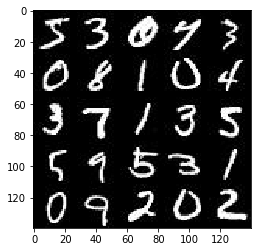

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

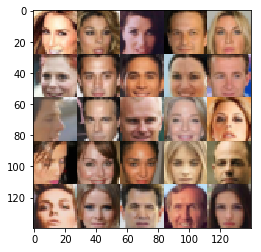

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_placeholder = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_input')
    z_placeholder = tf.placeholder(tf.float32, shape=[None, z_dim], name='z_input')
    lr_placeholder = tf.placeholder(tf.float32, name='learning_rate')
    return real_placeholder, z_placeholder, lr_placeholder


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    
    with(tf.variable_scope('discriminator', reuse=reuse)):
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        
        logits = tf.layers.dense(tf.reshape(x, (-1, 4*4*256)), 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, [-1,7,7,256])
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.maximum(alpha*x, x)
                   
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images, input_z: batch_z})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    _ = show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.2469... Generator Loss: 1.2715


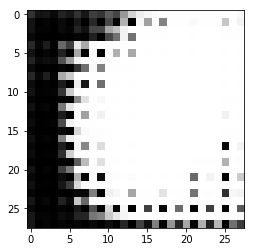

Epoch 1/2... Discriminator Loss: 0.8171... Generator Loss: 2.1590


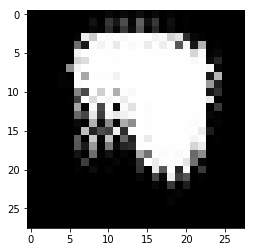

Epoch 1/2... Discriminator Loss: 2.3667... Generator Loss: 0.6629


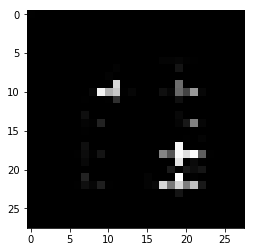

Epoch 1/2... Discriminator Loss: 7.0959... Generator Loss: 0.0023


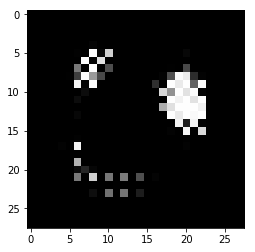

Epoch 1/2... Discriminator Loss: 1.1467... Generator Loss: 1.2016


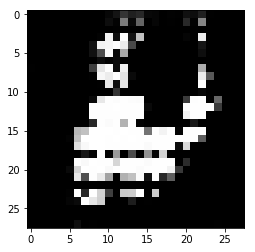

Epoch 1/2... Discriminator Loss: 1.3585... Generator Loss: 0.6260


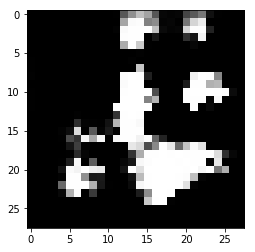

Epoch 1/2... Discriminator Loss: 4.3336... Generator Loss: 5.5702


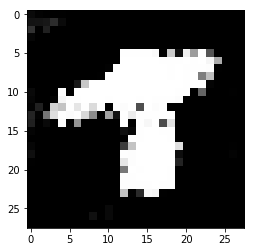

Epoch 1/2... Discriminator Loss: 1.4480... Generator Loss: 0.5329


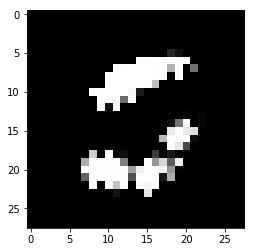

Epoch 1/2... Discriminator Loss: 3.5603... Generator Loss: 0.0633


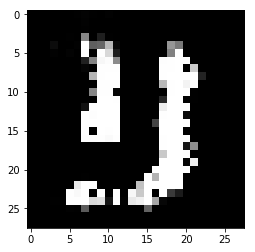

Epoch 1/2... Discriminator Loss: 1.5553... Generator Loss: 0.6671


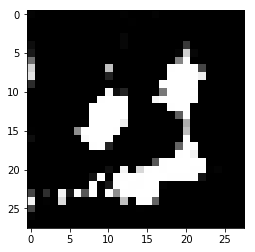

Epoch 1/2... Discriminator Loss: 1.3516... Generator Loss: 1.2823


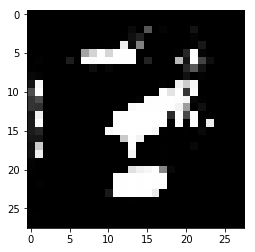

Epoch 1/2... Discriminator Loss: 1.2595... Generator Loss: 2.1449


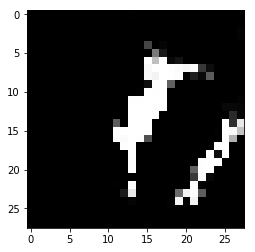

Epoch 1/2... Discriminator Loss: 2.0089... Generator Loss: 0.2416


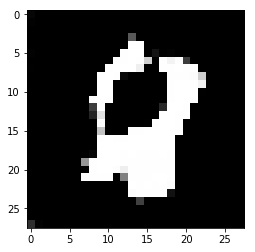

Epoch 1/2... Discriminator Loss: 0.8676... Generator Loss: 1.2768


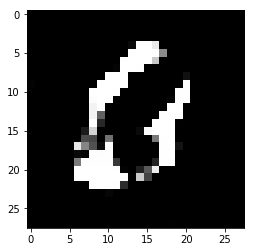

Epoch 1/2... Discriminator Loss: 2.2094... Generator Loss: 0.2336


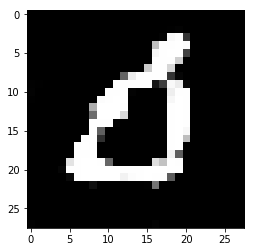

Epoch 1/2... Discriminator Loss: 1.7778... Generator Loss: 0.3009


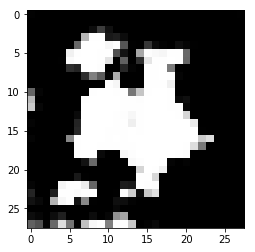

Epoch 1/2... Discriminator Loss: 0.8420... Generator Loss: 1.7074


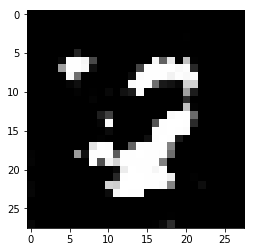

Epoch 1/2... Discriminator Loss: 0.7842... Generator Loss: 1.2995


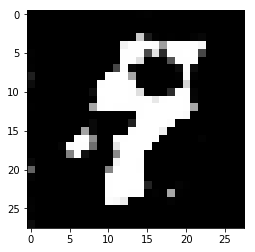

Epoch 1/2... Discriminator Loss: 1.2348... Generator Loss: 1.9566


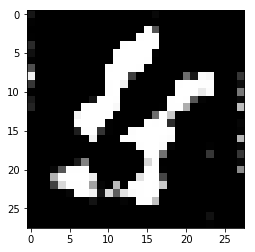

Epoch 1/2... Discriminator Loss: 1.0255... Generator Loss: 0.7060


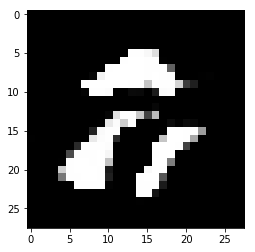

Epoch 1/2... Discriminator Loss: 1.1632... Generator Loss: 0.7569


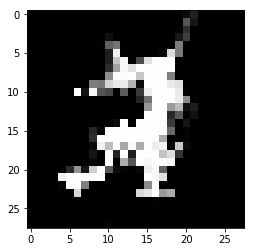

Epoch 1/2... Discriminator Loss: 0.4062... Generator Loss: 3.4881


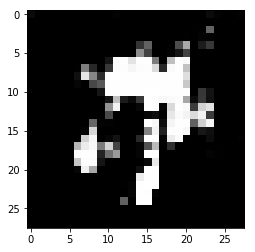

Epoch 1/2... Discriminator Loss: 1.4950... Generator Loss: 4.9270


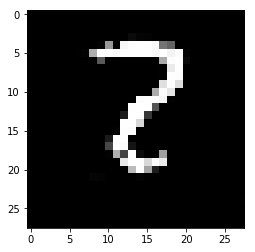

Epoch 1/2... Discriminator Loss: 1.4458... Generator Loss: 0.5463


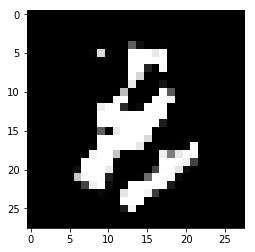

Epoch 1/2... Discriminator Loss: 2.9486... Generator Loss: 0.0923


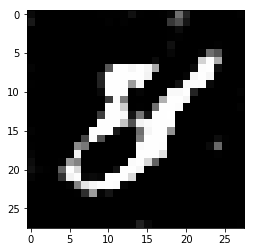

Epoch 1/2... Discriminator Loss: 1.6787... Generator Loss: 0.6152


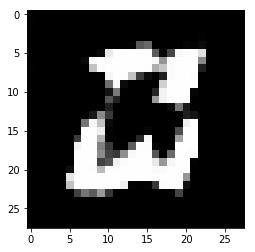

Epoch 1/2... Discriminator Loss: 1.8824... Generator Loss: 0.2245


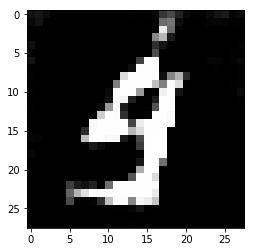

Epoch 1/2... Discriminator Loss: 1.8260... Generator Loss: 1.7784


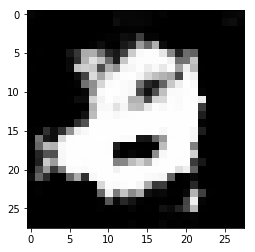

Epoch 1/2... Discriminator Loss: 1.3027... Generator Loss: 0.6675


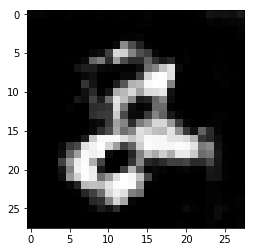

Epoch 1/2... Discriminator Loss: 1.8900... Generator Loss: 0.3159


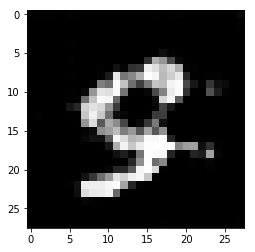

Epoch 1/2... Discriminator Loss: 1.5823... Generator Loss: 0.9959


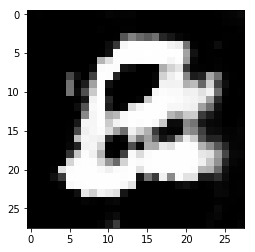

Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 1.2506


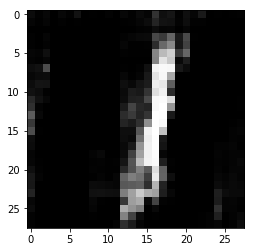

Epoch 1/2... Discriminator Loss: 1.8104... Generator Loss: 0.3622


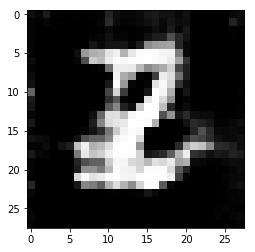

Epoch 1/2... Discriminator Loss: 1.8496... Generator Loss: 0.2424


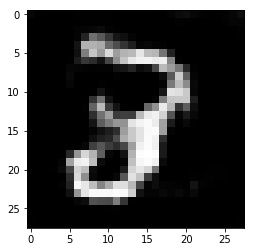

Epoch 1/2... Discriminator Loss: 1.5522... Generator Loss: 0.4473


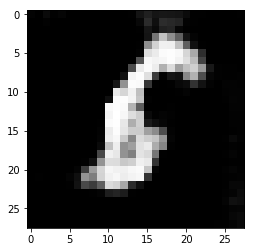

Epoch 1/2... Discriminator Loss: 1.4450... Generator Loss: 0.9287


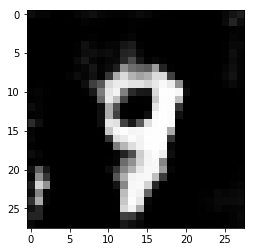

Epoch 1/2... Discriminator Loss: 1.2344... Generator Loss: 0.6851


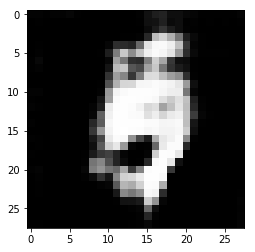

Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.5951


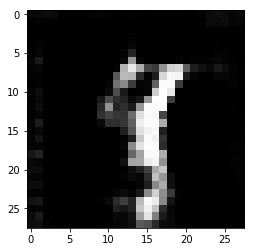

Epoch 1/2... Discriminator Loss: 1.4375... Generator Loss: 0.5158


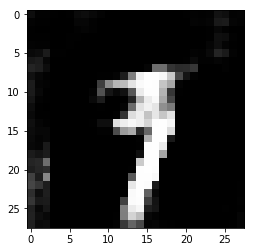

Epoch 1/2... Discriminator Loss: 1.5712... Generator Loss: 0.4544


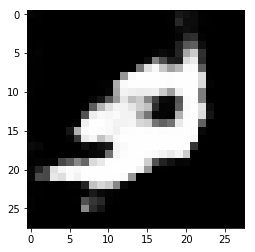

Epoch 1/2... Discriminator Loss: 2.1952... Generator Loss: 0.1809


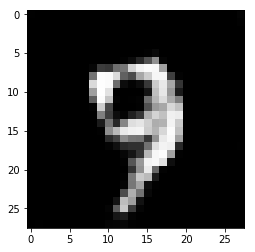

Epoch 1/2... Discriminator Loss: 1.6390... Generator Loss: 0.4641


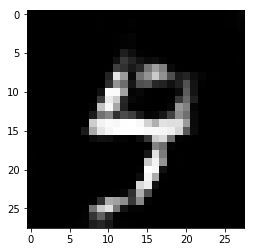

Epoch 1/2... Discriminator Loss: 1.5555... Generator Loss: 0.4370


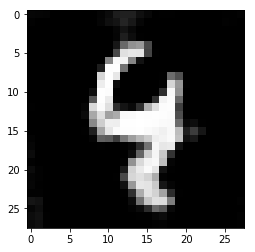

Epoch 1/2... Discriminator Loss: 1.8375... Generator Loss: 0.3629


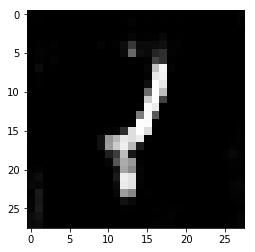

Epoch 1/2... Discriminator Loss: 1.3643... Generator Loss: 0.9982


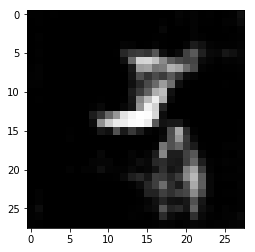

Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.8614


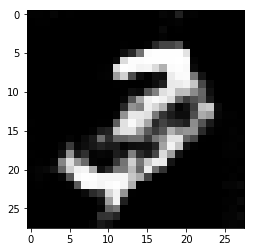

Epoch 1/2... Discriminator Loss: 1.9165... Generator Loss: 0.2144


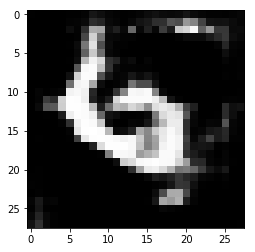

Epoch 1/2... Discriminator Loss: 1.1817... Generator Loss: 1.2085


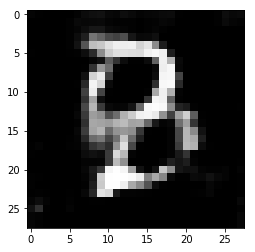

Epoch 1/2... Discriminator Loss: 2.2844... Generator Loss: 0.1628


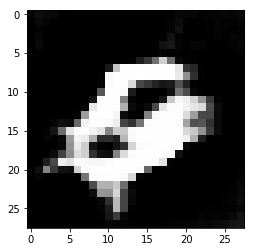

Epoch 1/2... Discriminator Loss: 1.7179... Generator Loss: 0.3920


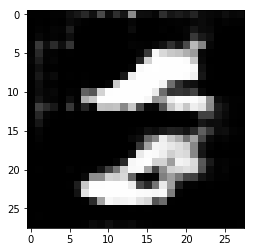

Epoch 1/2... Discriminator Loss: 1.8782... Generator Loss: 1.1828


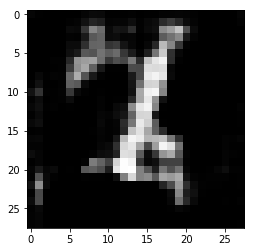

Epoch 1/2... Discriminator Loss: 1.2929... Generator Loss: 0.8029


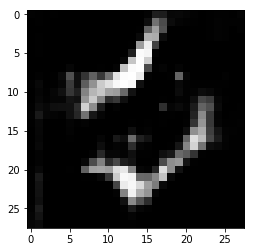

Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 0.6133


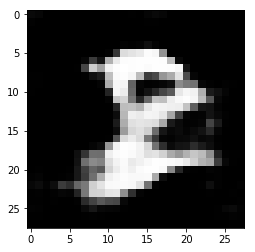

Epoch 1/2... Discriminator Loss: 1.6576... Generator Loss: 0.4017


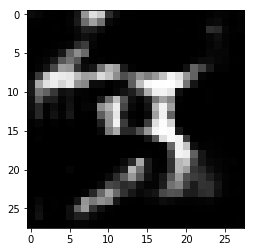

Epoch 1/2... Discriminator Loss: 1.5388... Generator Loss: 0.5056


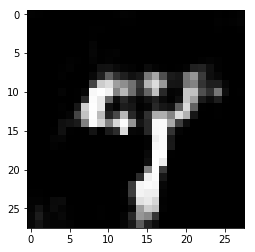

Epoch 1/2... Discriminator Loss: 1.8911... Generator Loss: 0.2808


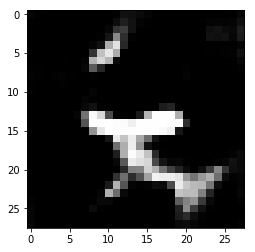

Epoch 1/2... Discriminator Loss: 1.7628... Generator Loss: 0.4067


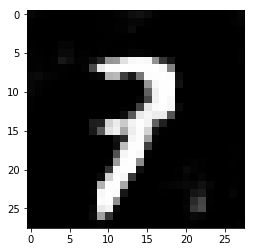

Epoch 1/2... Discriminator Loss: 1.5305... Generator Loss: 0.3735


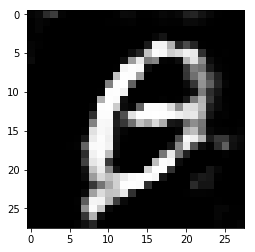

Epoch 1/2... Discriminator Loss: 1.2009... Generator Loss: 0.7505


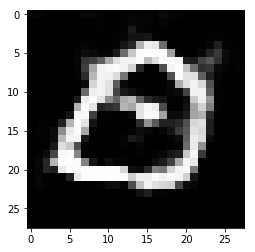

Epoch 1/2... Discriminator Loss: 1.2850... Generator Loss: 0.8940


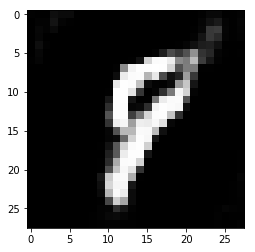

Epoch 1/2... Discriminator Loss: 0.9046... Generator Loss: 1.1667


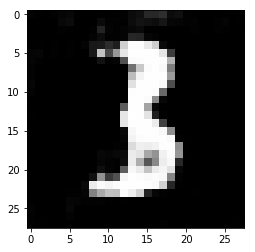

Epoch 1/2... Discriminator Loss: 2.0780... Generator Loss: 0.1750


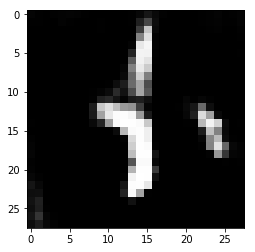

Epoch 1/2... Discriminator Loss: 1.0386... Generator Loss: 1.0773


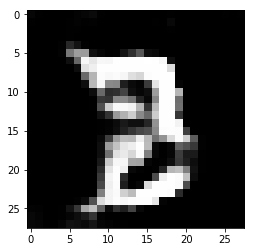

Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 1.2657


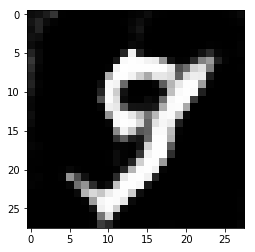

Epoch 1/2... Discriminator Loss: 0.9577... Generator Loss: 1.3216


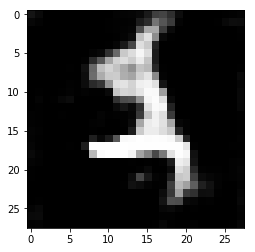

Epoch 1/2... Discriminator Loss: 1.1835... Generator Loss: 0.7177


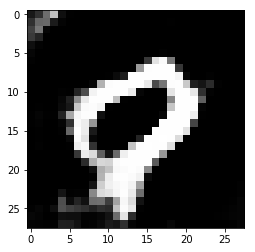

Epoch 1/2... Discriminator Loss: 2.4995... Generator Loss: 0.1465


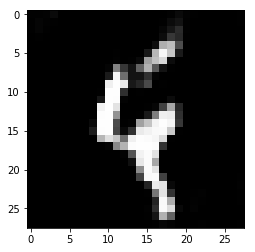

Epoch 1/2... Discriminator Loss: 1.1117... Generator Loss: 0.6322


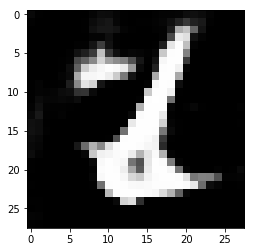

Epoch 1/2... Discriminator Loss: 1.2154... Generator Loss: 0.9864


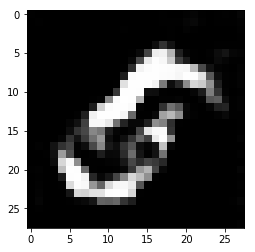

Epoch 1/2... Discriminator Loss: 1.7923... Generator Loss: 0.4118


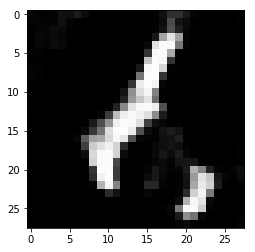

Epoch 1/2... Discriminator Loss: 0.9314... Generator Loss: 0.9774


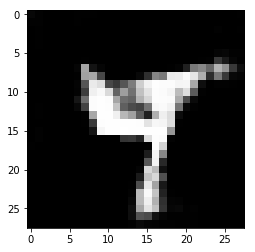

Epoch 1/2... Discriminator Loss: 0.9809... Generator Loss: 1.1400


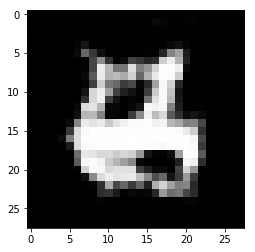

Epoch 1/2... Discriminator Loss: 0.9984... Generator Loss: 1.1963


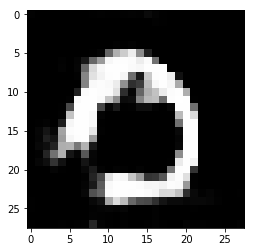

Epoch 1/2... Discriminator Loss: 1.0698... Generator Loss: 0.7624


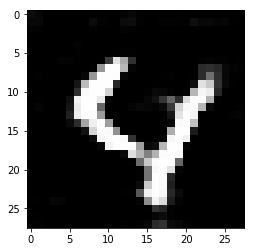

Epoch 1/2... Discriminator Loss: 2.6166... Generator Loss: 0.1484


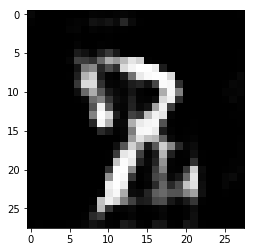

Epoch 1/2... Discriminator Loss: 1.0103... Generator Loss: 1.0198


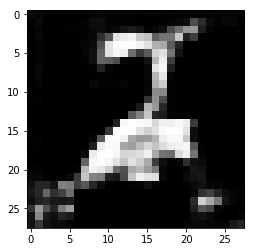

Epoch 1/2... Discriminator Loss: 1.2563... Generator Loss: 0.5900


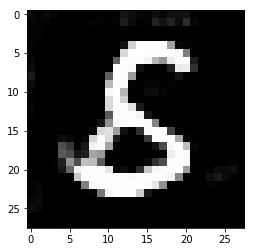

Epoch 1/2... Discriminator Loss: 0.9040... Generator Loss: 1.4351


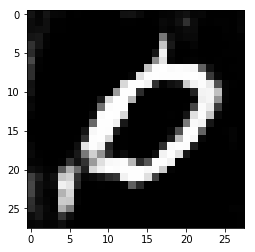

Epoch 1/2... Discriminator Loss: 1.9384... Generator Loss: 0.2548


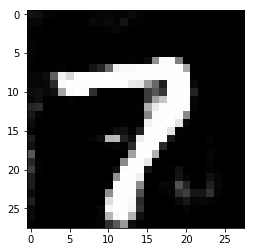

Epoch 1/2... Discriminator Loss: 1.4035... Generator Loss: 0.5771


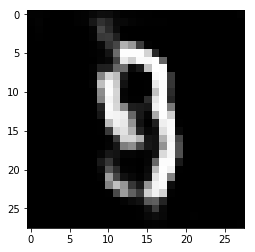

Epoch 1/2... Discriminator Loss: 2.1961... Generator Loss: 0.2238


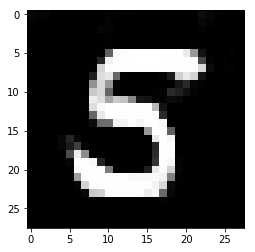

Epoch 1/2... Discriminator Loss: 1.3625... Generator Loss: 1.9310


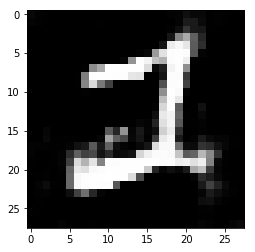

Epoch 1/2... Discriminator Loss: 0.9976... Generator Loss: 1.0287


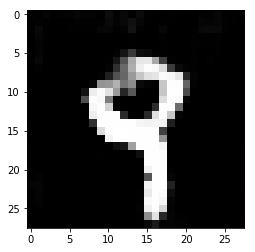

Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 1.6669


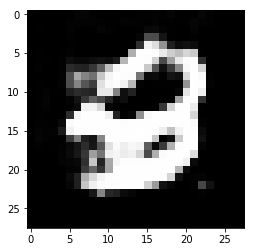

Epoch 1/2... Discriminator Loss: 1.1928... Generator Loss: 0.8198


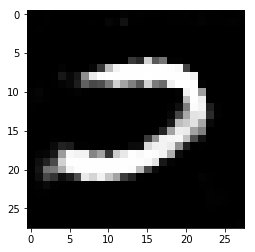

Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 1.3781


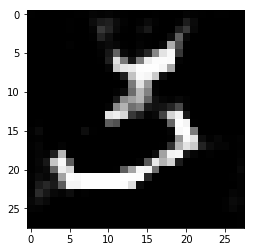

Epoch 1/2... Discriminator Loss: 1.4320... Generator Loss: 0.8781


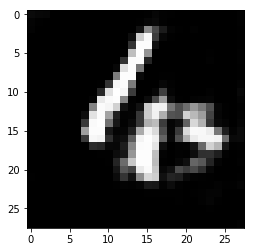

Epoch 1/2... Discriminator Loss: 1.6181... Generator Loss: 0.4362


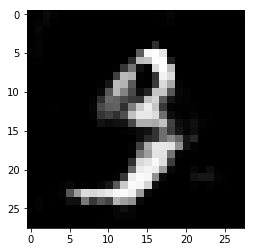

Epoch 1/2... Discriminator Loss: 1.3677... Generator Loss: 0.5237


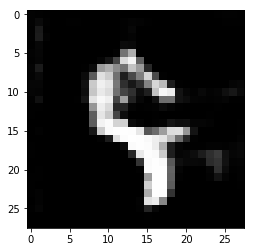

Epoch 1/2... Discriminator Loss: 0.9398... Generator Loss: 0.9216


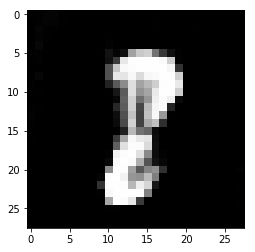

Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 0.5875


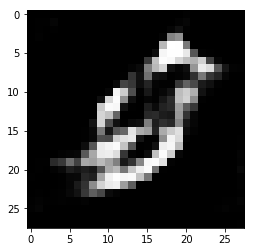

Epoch 1/2... Discriminator Loss: 2.3340... Generator Loss: 0.1706


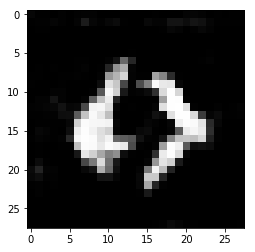

Epoch 1/2... Discriminator Loss: 2.4205... Generator Loss: 0.1764


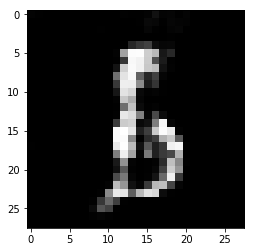

Epoch 1/2... Discriminator Loss: 1.1199... Generator Loss: 1.0867


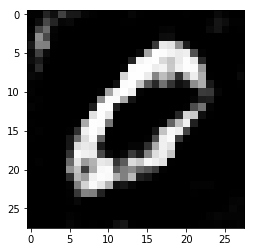

Epoch 1/2... Discriminator Loss: 4.4860... Generator Loss: 0.0261


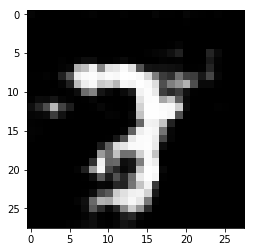

Epoch 1/2... Discriminator Loss: 0.9493... Generator Loss: 0.9214


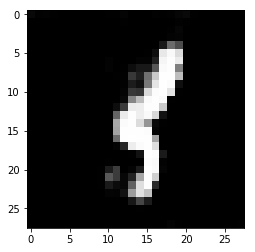

Epoch 1/2... Discriminator Loss: 1.7674... Generator Loss: 0.3352


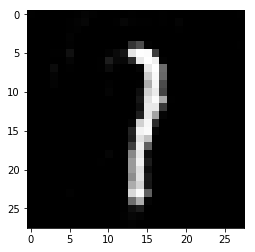

Epoch 1/2... Discriminator Loss: 1.4811... Generator Loss: 0.4052


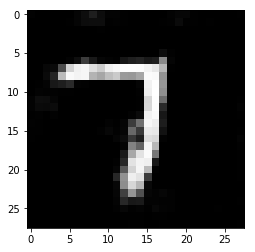

Epoch 1/2... Discriminator Loss: 1.0293... Generator Loss: 0.7505


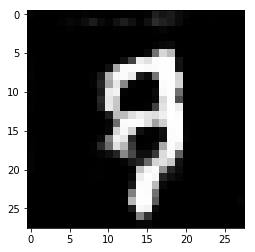

Epoch 1/2... Discriminator Loss: 1.2683... Generator Loss: 1.3099


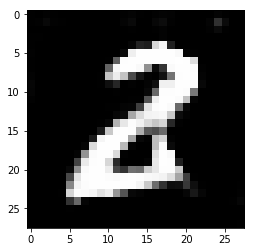

Epoch 1/2... Discriminator Loss: 1.2187... Generator Loss: 1.2108


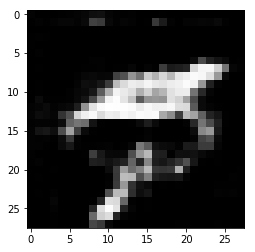

Epoch 1/2... Discriminator Loss: 1.3084... Generator Loss: 0.5189


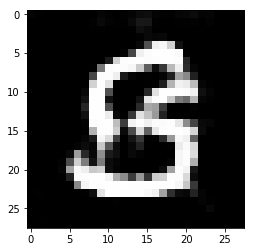

Epoch 1/2... Discriminator Loss: 1.3537... Generator Loss: 0.4890


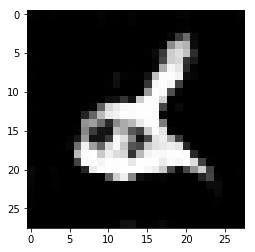

Epoch 1/2... Discriminator Loss: 1.5744... Generator Loss: 0.3183


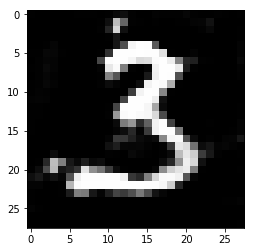

Epoch 1/2... Discriminator Loss: 2.2350... Generator Loss: 0.1797


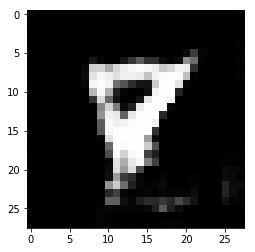

Epoch 1/2... Discriminator Loss: 0.8424... Generator Loss: 2.0142


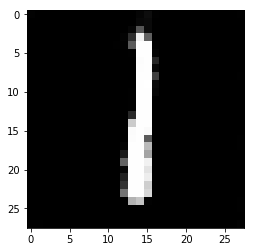

Epoch 1/2... Discriminator Loss: 2.1556... Generator Loss: 0.2762


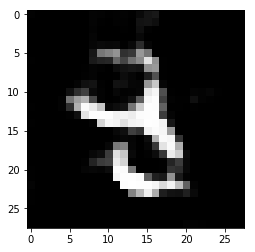

Epoch 1/2... Discriminator Loss: 1.2331... Generator Loss: 0.6339


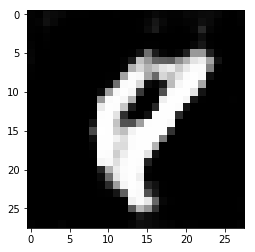

Epoch 1/2... Discriminator Loss: 2.4064... Generator Loss: 0.3397


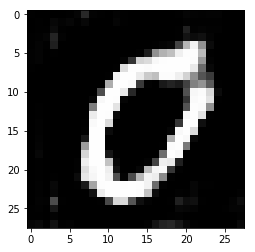

Epoch 1/2... Discriminator Loss: 1.6011... Generator Loss: 0.4168


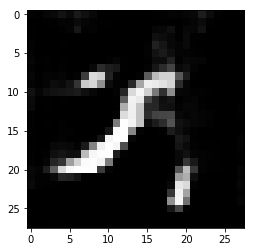

Epoch 1/2... Discriminator Loss: 1.8562... Generator Loss: 0.3875


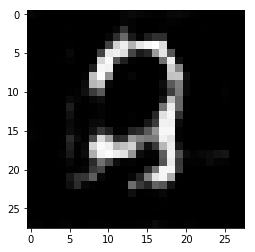

Epoch 1/2... Discriminator Loss: 1.3173... Generator Loss: 0.5491


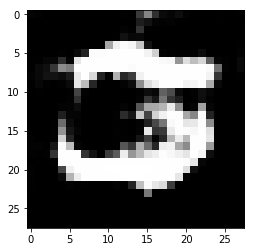

Epoch 1/2... Discriminator Loss: 1.1869... Generator Loss: 0.7452


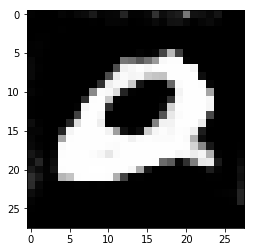

Epoch 1/2... Discriminator Loss: 4.2299... Generator Loss: 0.0248


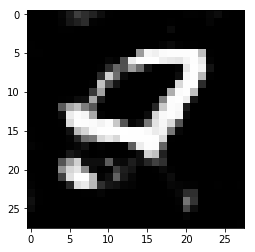

Epoch 1/2... Discriminator Loss: 1.0060... Generator Loss: 1.4020


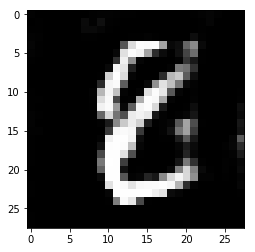

Epoch 1/2... Discriminator Loss: 0.8781... Generator Loss: 1.3444


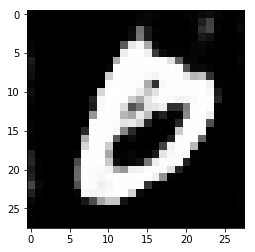

Epoch 1/2... Discriminator Loss: 1.0232... Generator Loss: 1.0014


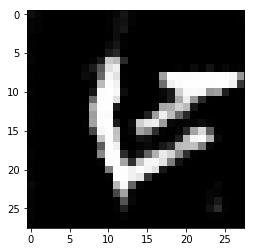

Epoch 1/2... Discriminator Loss: 1.7798... Generator Loss: 0.3512


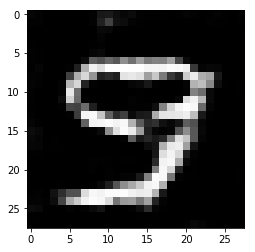

Epoch 1/2... Discriminator Loss: 1.2258... Generator Loss: 0.6455


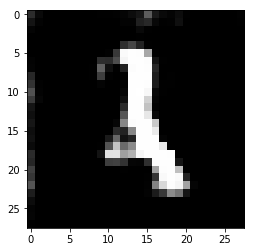

Epoch 1/2... Discriminator Loss: 0.9268... Generator Loss: 0.8537


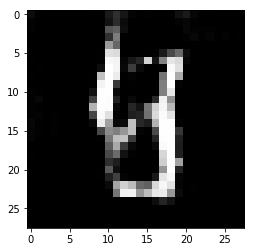

Epoch 1/2... Discriminator Loss: 2.7364... Generator Loss: 0.1026


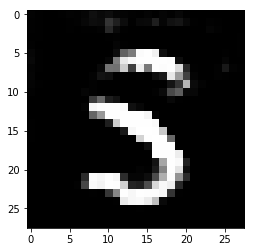

Epoch 1/2... Discriminator Loss: 0.8930... Generator Loss: 0.8223


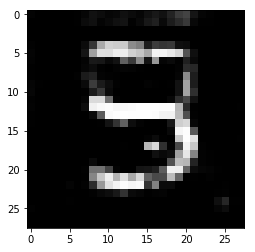

Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 0.5154


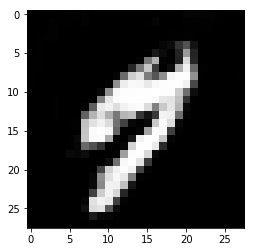

Epoch 1/2... Discriminator Loss: 1.3902... Generator Loss: 0.5067


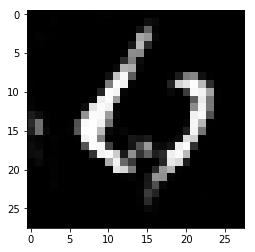

Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 0.8810


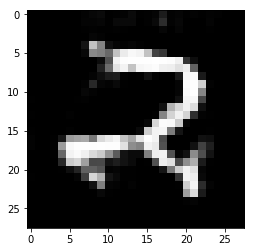

Epoch 1/2... Discriminator Loss: 1.0334... Generator Loss: 0.8781


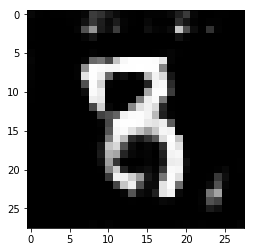

Epoch 1/2... Discriminator Loss: 2.5078... Generator Loss: 0.1720


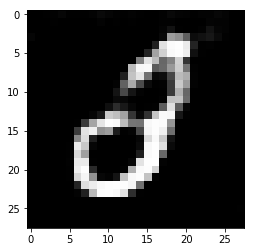

Epoch 1/2... Discriminator Loss: 1.3916... Generator Loss: 0.4831


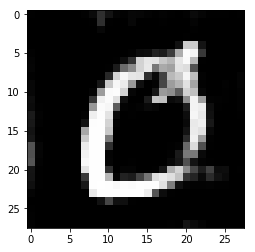

Epoch 1/2... Discriminator Loss: 1.0018... Generator Loss: 1.0994


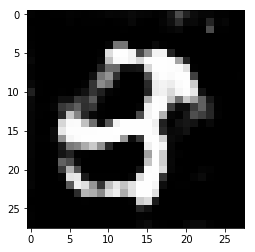

Epoch 1/2... Discriminator Loss: 1.3537... Generator Loss: 0.6180


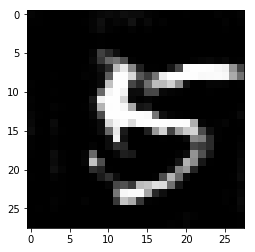

Epoch 1/2... Discriminator Loss: 1.7037... Generator Loss: 0.4054


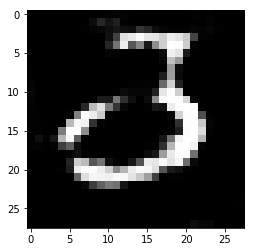

Epoch 1/2... Discriminator Loss: 1.3085... Generator Loss: 0.7605


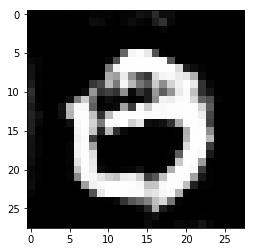

Epoch 1/2... Discriminator Loss: 1.7415... Generator Loss: 0.9558


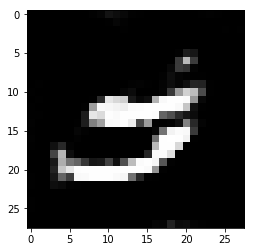

Epoch 1/2... Discriminator Loss: 2.1708... Generator Loss: 0.3211


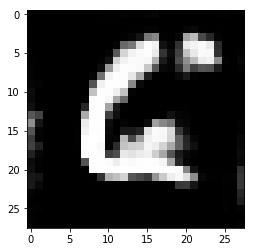

Epoch 1/2... Discriminator Loss: 0.9195... Generator Loss: 1.1833


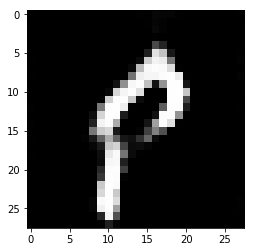

Epoch 1/2... Discriminator Loss: 1.5050... Generator Loss: 0.6809


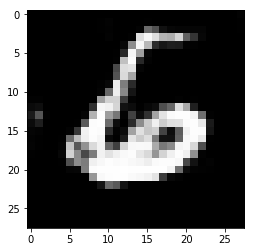

Epoch 1/2... Discriminator Loss: 0.9385... Generator Loss: 1.2505


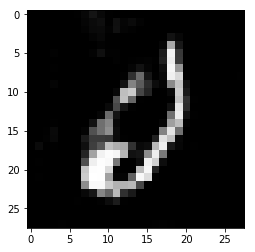

Epoch 1/2... Discriminator Loss: 0.9503... Generator Loss: 0.8513


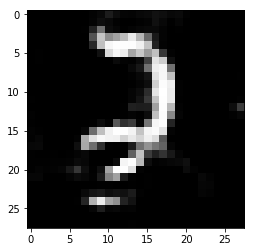

Epoch 1/2... Discriminator Loss: 1.3969... Generator Loss: 1.0523


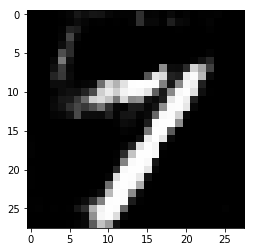

Epoch 1/2... Discriminator Loss: 2.2512... Generator Loss: 0.2498


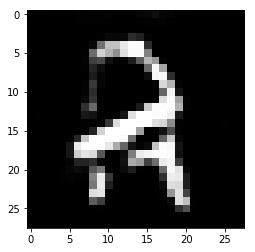

Epoch 1/2... Discriminator Loss: 1.0776... Generator Loss: 1.1017


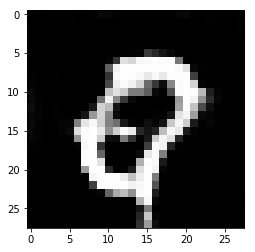

Epoch 1/2... Discriminator Loss: 1.7390... Generator Loss: 0.3352


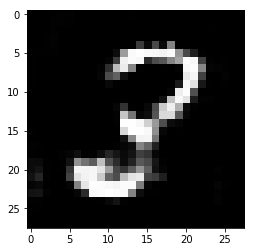

Epoch 1/2... Discriminator Loss: 2.0659... Generator Loss: 0.2823


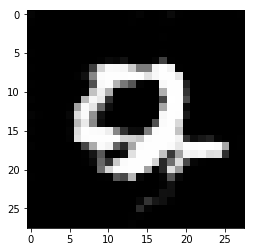

Epoch 1/2... Discriminator Loss: 0.8910... Generator Loss: 1.5294


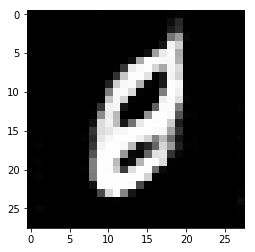

Epoch 1/2... Discriminator Loss: 0.8939... Generator Loss: 1.7327


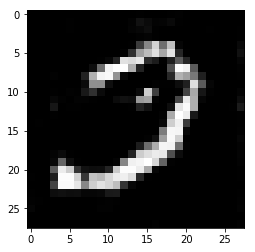

Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 0.8281


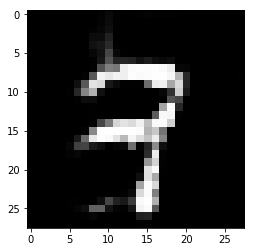

Epoch 1/2... Discriminator Loss: 1.1601... Generator Loss: 0.6370


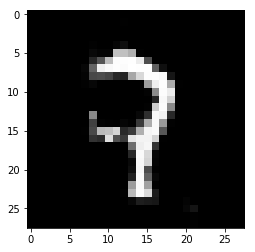

Epoch 1/2... Discriminator Loss: 2.6804... Generator Loss: 0.2089


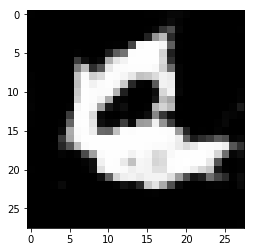

Epoch 1/2... Discriminator Loss: 0.7123... Generator Loss: 1.2590


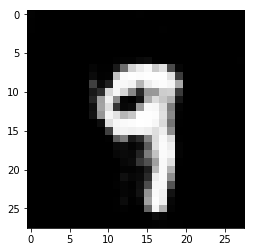

Epoch 1/2... Discriminator Loss: 2.2318... Generator Loss: 0.2076


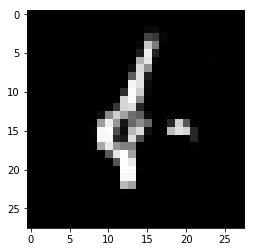

Epoch 1/2... Discriminator Loss: 2.4918... Generator Loss: 0.1993


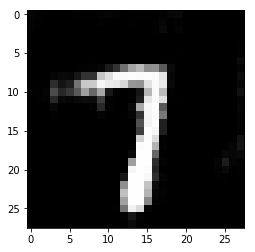

Epoch 1/2... Discriminator Loss: 2.0130... Generator Loss: 0.3687


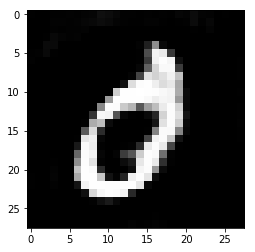

Epoch 1/2... Discriminator Loss: 1.8022... Generator Loss: 0.3329


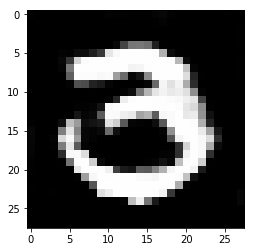

Epoch 1/2... Discriminator Loss: 2.0744... Generator Loss: 0.2634


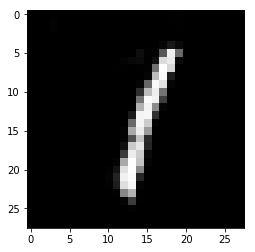

Epoch 1/2... Discriminator Loss: 1.2144... Generator Loss: 0.6392


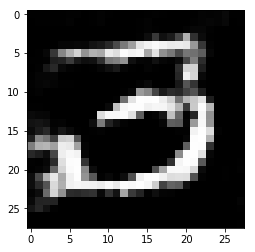

Epoch 1/2... Discriminator Loss: 1.2489... Generator Loss: 0.7736


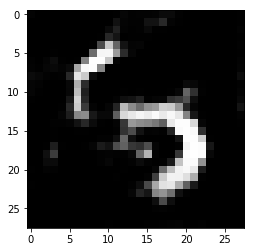

Epoch 1/2... Discriminator Loss: 2.2056... Generator Loss: 0.2242


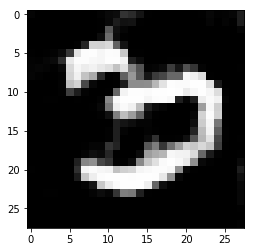

Epoch 1/2... Discriminator Loss: 1.2127... Generator Loss: 0.6886


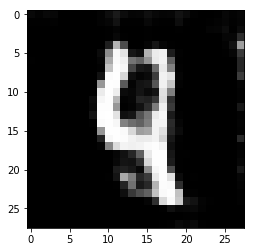

Epoch 1/2... Discriminator Loss: 2.3687... Generator Loss: 0.1942


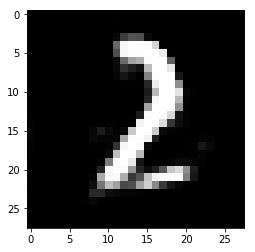

Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 1.2249


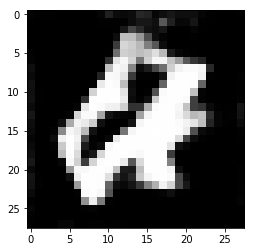

Epoch 1/2... Discriminator Loss: 1.0868... Generator Loss: 0.8062


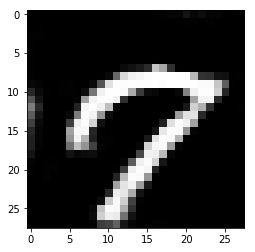

Epoch 1/2... Discriminator Loss: 1.7375... Generator Loss: 0.3501


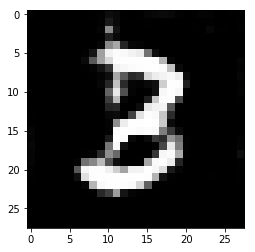

Epoch 1/2... Discriminator Loss: 1.8957... Generator Loss: 0.2806


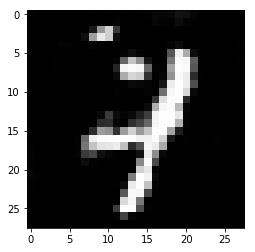

Epoch 1/2... Discriminator Loss: 0.9200... Generator Loss: 1.3636


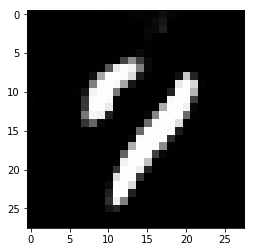

Epoch 1/2... Discriminator Loss: 1.6974... Generator Loss: 0.5509


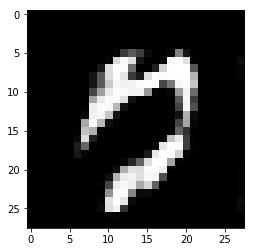

Epoch 1/2... Discriminator Loss: 1.2548... Generator Loss: 1.0025


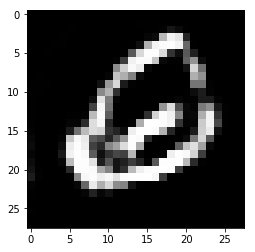

Epoch 1/2... Discriminator Loss: 2.4158... Generator Loss: 0.2570


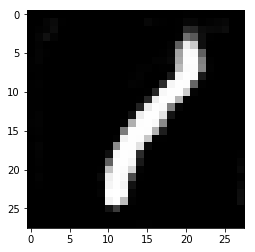

Epoch 1/2... Discriminator Loss: 0.8906... Generator Loss: 0.8929


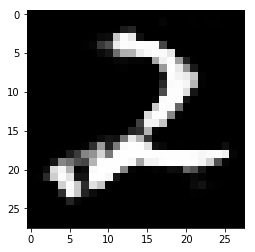

Epoch 1/2... Discriminator Loss: 0.7248... Generator Loss: 1.0247


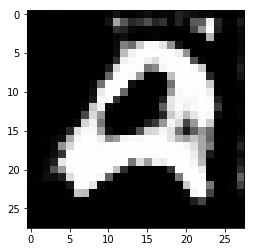

Epoch 1/2... Discriminator Loss: 1.5216... Generator Loss: 0.6618


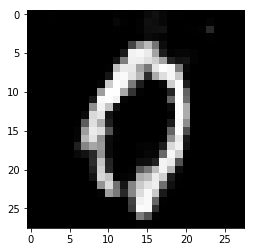

Epoch 1/2... Discriminator Loss: 2.4413... Generator Loss: 0.2275


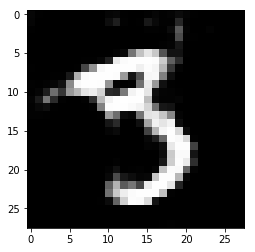

Epoch 1/2... Discriminator Loss: 1.6497... Generator Loss: 0.5480


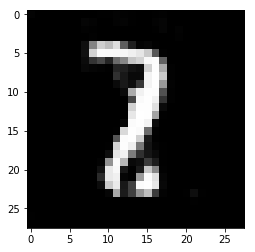

Epoch 1/2... Discriminator Loss: 1.1225... Generator Loss: 0.7283


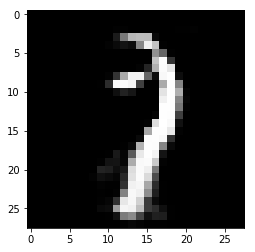

Epoch 1/2... Discriminator Loss: 1.0036... Generator Loss: 1.0362


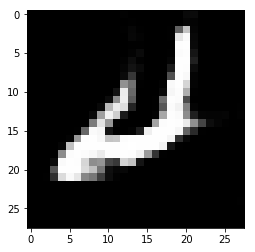

Epoch 1/2... Discriminator Loss: 1.7427... Generator Loss: 0.5575


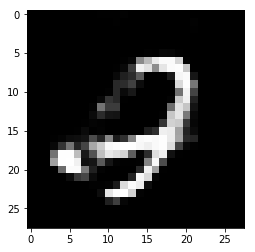

Epoch 1/2... Discriminator Loss: 1.5202... Generator Loss: 0.5289


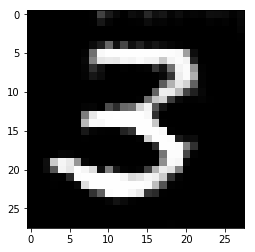

Epoch 1/2... Discriminator Loss: 0.5761... Generator Loss: 1.9295


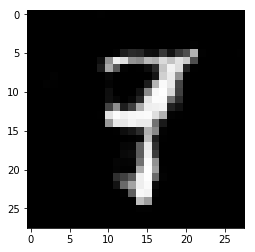

Epoch 1/2... Discriminator Loss: 1.6449... Generator Loss: 0.4630


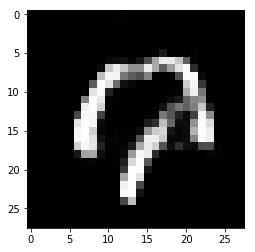

Epoch 1/2... Discriminator Loss: 1.6037... Generator Loss: 0.3736


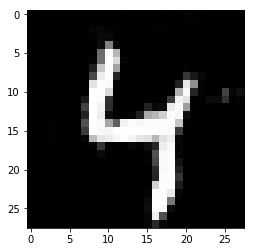

Epoch 1/2... Discriminator Loss: 0.7406... Generator Loss: 1.6486


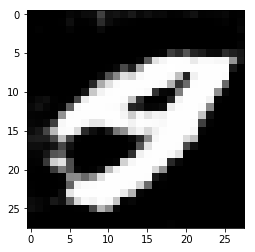

Epoch 1/2... Discriminator Loss: 0.8593... Generator Loss: 0.8544


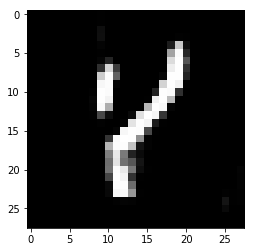

Epoch 1/2... Discriminator Loss: 1.4387... Generator Loss: 0.6184


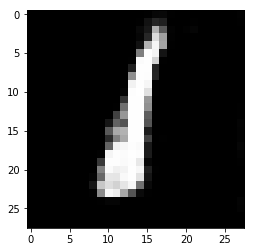

Epoch 1/2... Discriminator Loss: 0.8323... Generator Loss: 2.4705


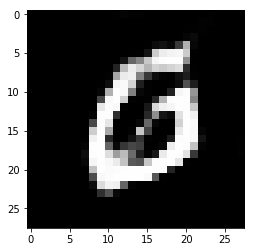

Epoch 1/2... Discriminator Loss: 1.2068... Generator Loss: 0.7866


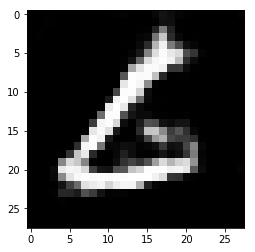

Epoch 1/2... Discriminator Loss: 2.4057... Generator Loss: 0.2171


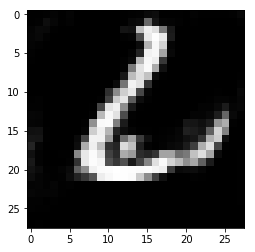

Epoch 1/2... Discriminator Loss: 0.6523... Generator Loss: 2.0129


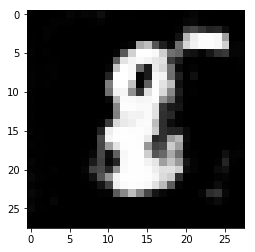

Epoch 1/2... Discriminator Loss: 1.1896... Generator Loss: 0.7687


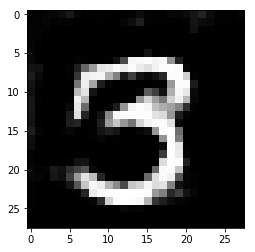

Epoch 2/2... Discriminator Loss: 1.5284... Generator Loss: 0.7102


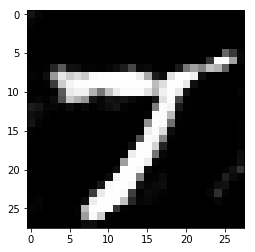

Epoch 2/2... Discriminator Loss: 1.2569... Generator Loss: 0.8432


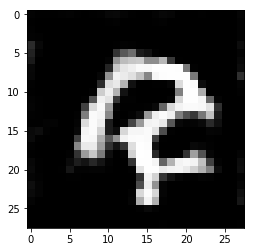

Epoch 2/2... Discriminator Loss: 2.7645... Generator Loss: 0.1501


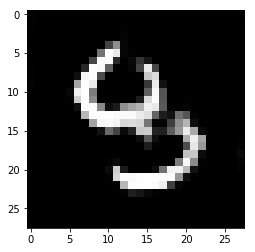

Epoch 2/2... Discriminator Loss: 1.0723... Generator Loss: 0.9129


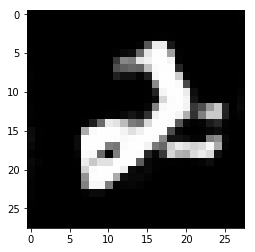

Epoch 2/2... Discriminator Loss: 2.2696... Generator Loss: 0.2555


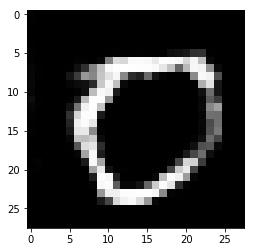

Epoch 2/2... Discriminator Loss: 2.7116... Generator Loss: 0.1189


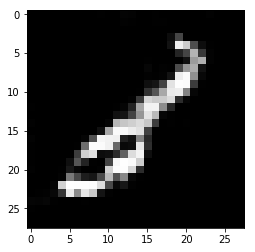

Epoch 2/2... Discriminator Loss: 1.5328... Generator Loss: 0.5035


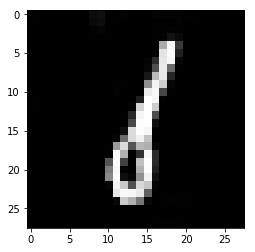

Epoch 2/2... Discriminator Loss: 1.8819... Generator Loss: 0.4094


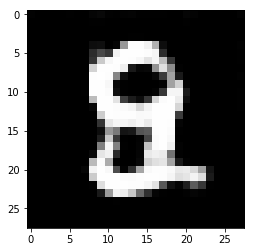

Epoch 2/2... Discriminator Loss: 0.9466... Generator Loss: 0.8362


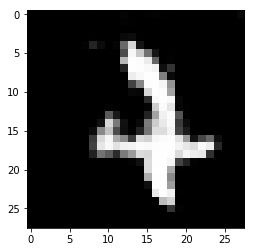

Epoch 2/2... Discriminator Loss: 1.4242... Generator Loss: 0.6402


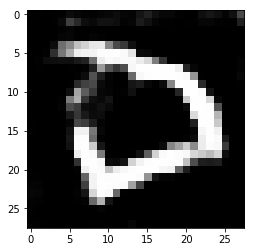

Epoch 2/2... Discriminator Loss: 2.1286... Generator Loss: 0.3619


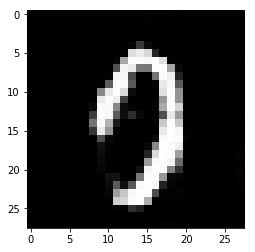

Epoch 2/2... Discriminator Loss: 1.6301... Generator Loss: 3.5538


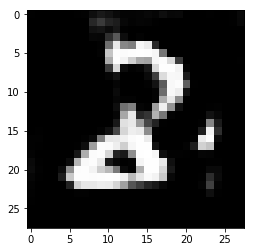

Epoch 2/2... Discriminator Loss: 1.7597... Generator Loss: 0.4868


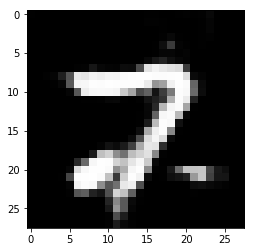

Epoch 2/2... Discriminator Loss: 3.0797... Generator Loss: 0.1231


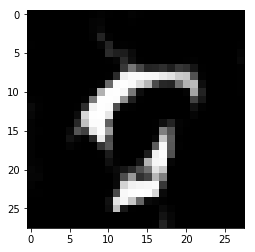

Epoch 2/2... Discriminator Loss: 1.5514... Generator Loss: 0.8730


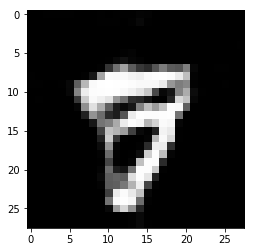

Epoch 2/2... Discriminator Loss: 1.3126... Generator Loss: 0.7559


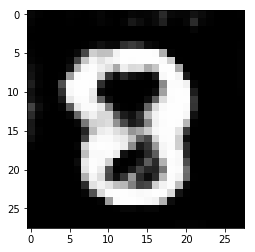

Epoch 2/2... Discriminator Loss: 1.5564... Generator Loss: 0.5995


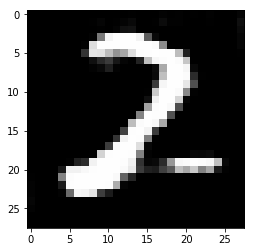

Epoch 2/2... Discriminator Loss: 1.7130... Generator Loss: 0.4064


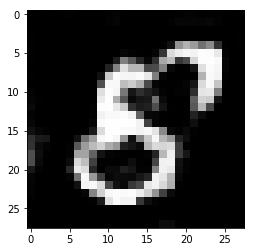

Epoch 2/2... Discriminator Loss: 2.2338... Generator Loss: 0.3021


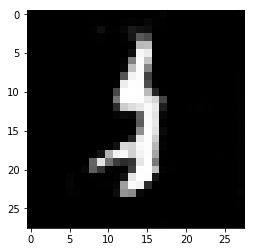

Epoch 2/2... Discriminator Loss: 1.0685... Generator Loss: 1.1505


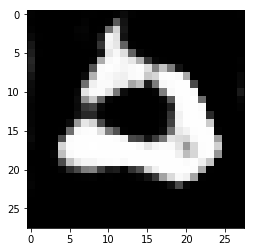

Epoch 2/2... Discriminator Loss: 2.0434... Generator Loss: 0.2622


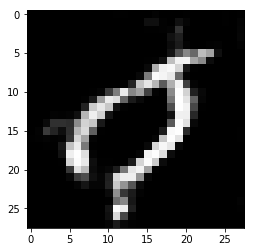

Epoch 2/2... Discriminator Loss: 1.7577... Generator Loss: 0.6441


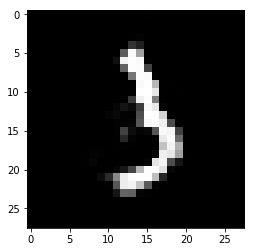

Epoch 2/2... Discriminator Loss: 1.7234... Generator Loss: 0.5210


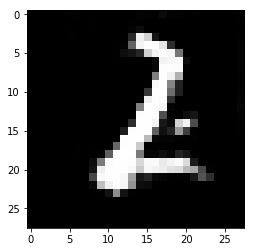

Epoch 2/2... Discriminator Loss: 1.0628... Generator Loss: 1.1898


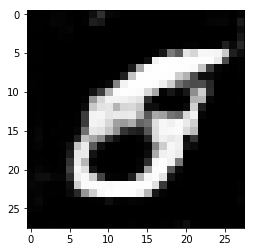

Epoch 2/2... Discriminator Loss: 1.5228... Generator Loss: 0.4625


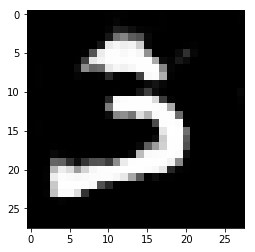

Epoch 2/2... Discriminator Loss: 2.1367... Generator Loss: 0.2605


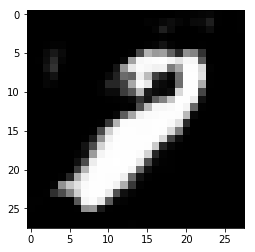

Epoch 2/2... Discriminator Loss: 0.8972... Generator Loss: 0.7717


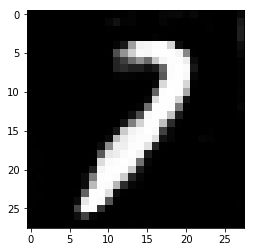

Epoch 2/2... Discriminator Loss: 0.8362... Generator Loss: 1.1516


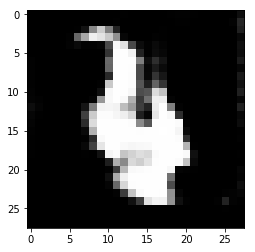

Epoch 2/2... Discriminator Loss: 1.1062... Generator Loss: 1.0969


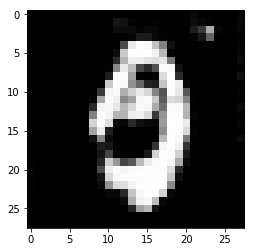

Epoch 2/2... Discriminator Loss: 0.8847... Generator Loss: 0.9978


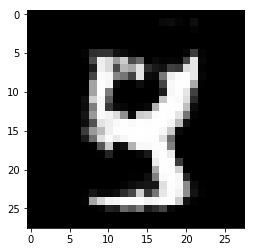

Epoch 2/2... Discriminator Loss: 2.0879... Generator Loss: 0.2424


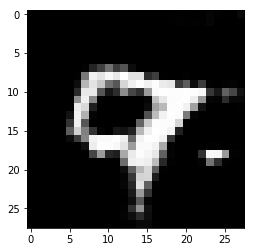

Epoch 2/2... Discriminator Loss: 2.2010... Generator Loss: 0.2180


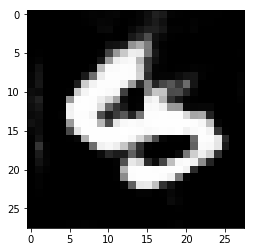

Epoch 2/2... Discriminator Loss: 2.9564... Generator Loss: 0.1166


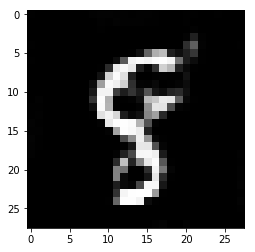

Epoch 2/2... Discriminator Loss: 1.1264... Generator Loss: 1.5795


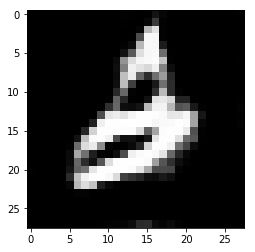

Epoch 2/2... Discriminator Loss: 1.2287... Generator Loss: 0.8319


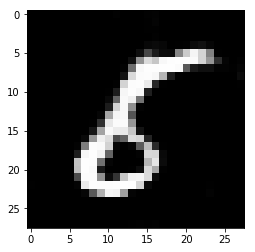

Epoch 2/2... Discriminator Loss: 1.0776... Generator Loss: 0.8131


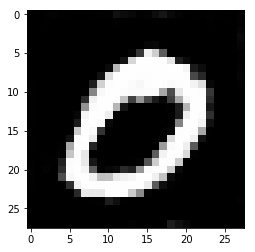

Epoch 2/2... Discriminator Loss: 1.2678... Generator Loss: 3.5282


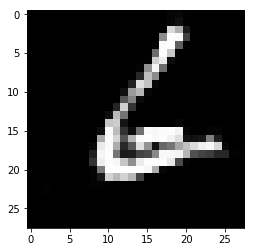

Epoch 2/2... Discriminator Loss: 1.1287... Generator Loss: 0.7698


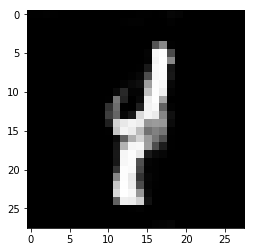

Epoch 2/2... Discriminator Loss: 0.9344... Generator Loss: 0.9720


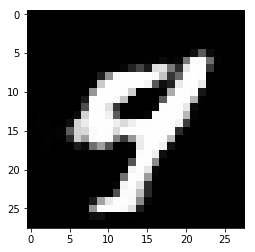

Epoch 2/2... Discriminator Loss: 0.6618... Generator Loss: 1.4911


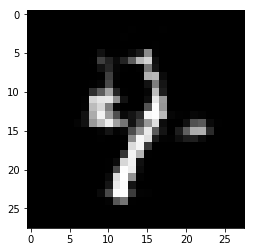

Epoch 2/2... Discriminator Loss: 1.1743... Generator Loss: 0.7691


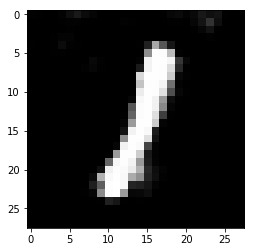

Epoch 2/2... Discriminator Loss: 0.7475... Generator Loss: 1.4384


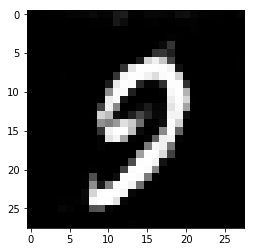

Epoch 2/2... Discriminator Loss: 0.8740... Generator Loss: 1.3468


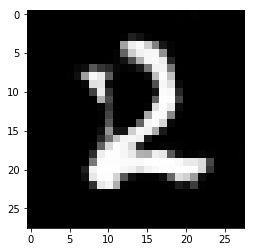

Epoch 2/2... Discriminator Loss: 1.2307... Generator Loss: 0.6487


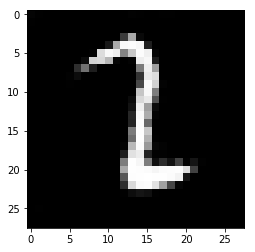

Epoch 2/2... Discriminator Loss: 1.4179... Generator Loss: 0.5611


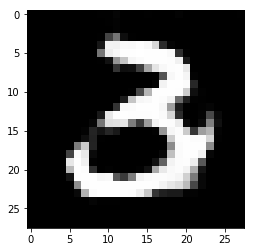

Epoch 2/2... Discriminator Loss: 1.6131... Generator Loss: 0.3969


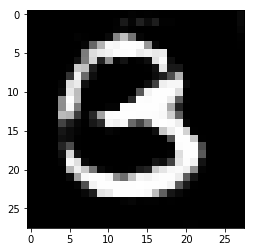

Epoch 2/2... Discriminator Loss: 0.7883... Generator Loss: 1.3567


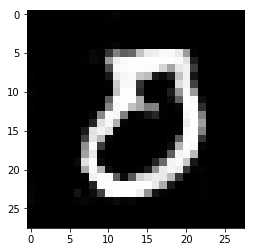

Epoch 2/2... Discriminator Loss: 0.4543... Generator Loss: 1.5927


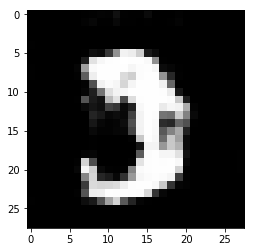

Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 0.6991


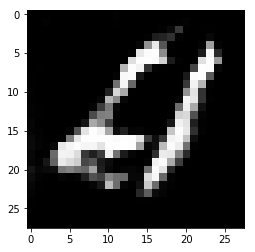

Epoch 2/2... Discriminator Loss: 1.1252... Generator Loss: 0.6736


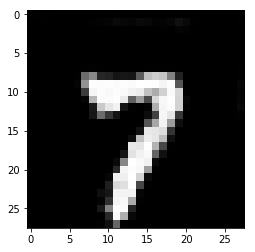

Epoch 2/2... Discriminator Loss: 0.8468... Generator Loss: 0.9948


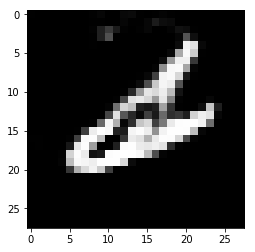

Epoch 2/2... Discriminator Loss: 1.5562... Generator Loss: 0.4222


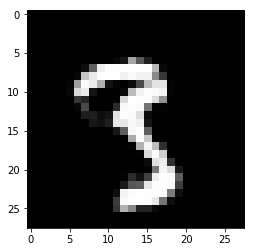

Epoch 2/2... Discriminator Loss: 1.2466... Generator Loss: 1.4079


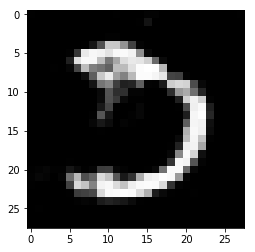

Epoch 2/2... Discriminator Loss: 2.5129... Generator Loss: 5.4428


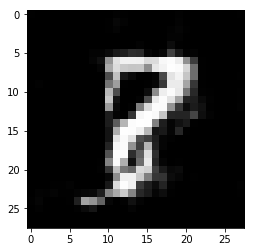

Epoch 2/2... Discriminator Loss: 0.8725... Generator Loss: 1.8040


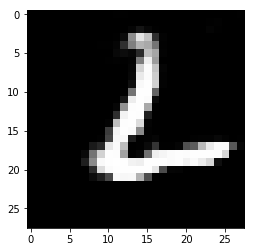

Epoch 2/2... Discriminator Loss: 1.0221... Generator Loss: 1.0074


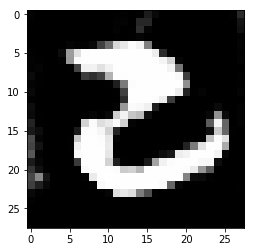

Epoch 2/2... Discriminator Loss: 0.6198... Generator Loss: 2.8216


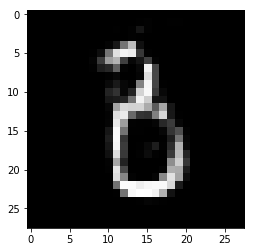

Epoch 2/2... Discriminator Loss: 0.8936... Generator Loss: 1.1254


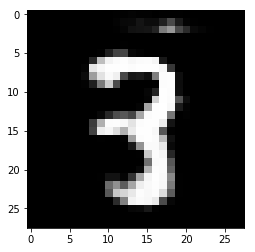

Epoch 2/2... Discriminator Loss: 0.8699... Generator Loss: 1.0820


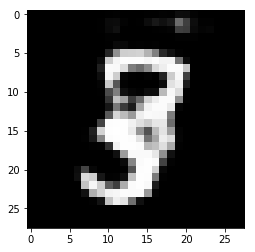

Epoch 2/2... Discriminator Loss: 1.0427... Generator Loss: 0.7834


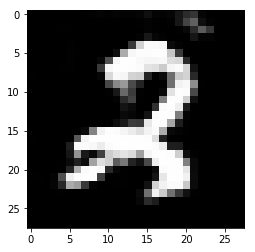

Epoch 2/2... Discriminator Loss: 0.9712... Generator Loss: 0.9145


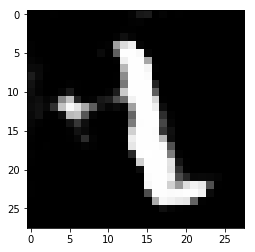

Epoch 2/2... Discriminator Loss: 1.2545... Generator Loss: 0.7362


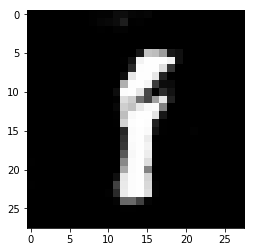

Epoch 2/2... Discriminator Loss: 0.7964... Generator Loss: 1.9702


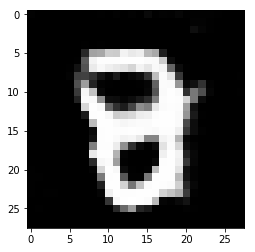

Epoch 2/2... Discriminator Loss: 1.4943... Generator Loss: 0.5985


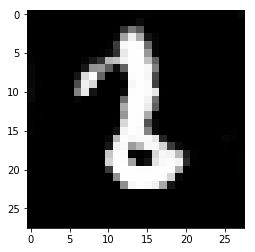

Epoch 2/2... Discriminator Loss: 0.5787... Generator Loss: 1.3907


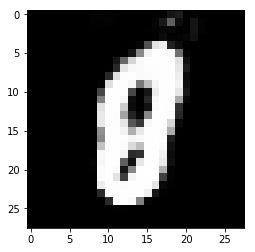

Epoch 2/2... Discriminator Loss: 0.8453... Generator Loss: 0.9282


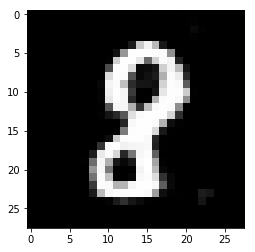

Epoch 2/2... Discriminator Loss: 1.5916... Generator Loss: 0.4209


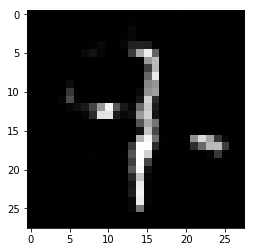

Epoch 2/2... Discriminator Loss: 1.4549... Generator Loss: 2.9821


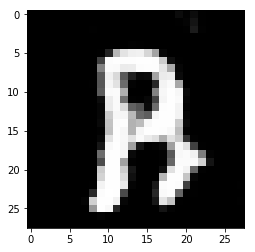

Epoch 2/2... Discriminator Loss: 0.6398... Generator Loss: 1.3739


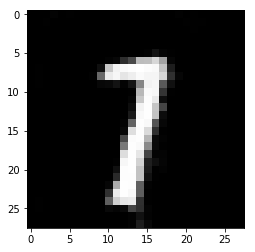

Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.7073


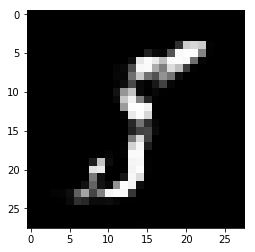

Epoch 2/2... Discriminator Loss: 2.6296... Generator Loss: 0.2132


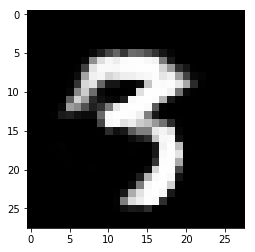

Epoch 2/2... Discriminator Loss: 0.6237... Generator Loss: 2.0658


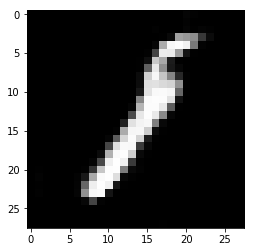

Epoch 2/2... Discriminator Loss: 2.2106... Generator Loss: 0.2648


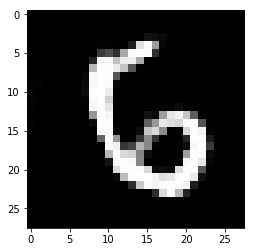

Epoch 2/2... Discriminator Loss: 1.1914... Generator Loss: 0.7525


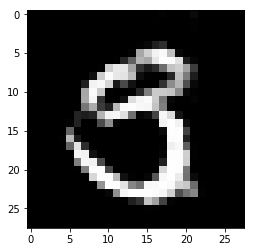

Epoch 2/2... Discriminator Loss: 1.1327... Generator Loss: 0.9725


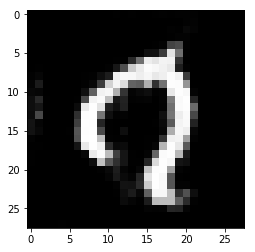

Epoch 2/2... Discriminator Loss: 1.3640... Generator Loss: 0.5843


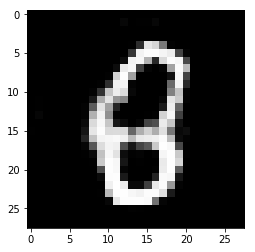

Epoch 2/2... Discriminator Loss: 2.8225... Generator Loss: 0.1595


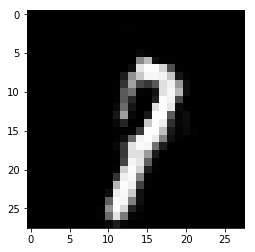

Epoch 2/2... Discriminator Loss: 0.9234... Generator Loss: 4.3670


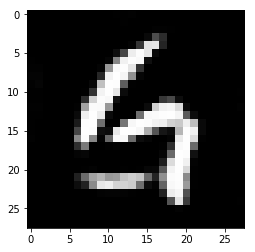

Epoch 2/2... Discriminator Loss: 1.2102... Generator Loss: 0.8944


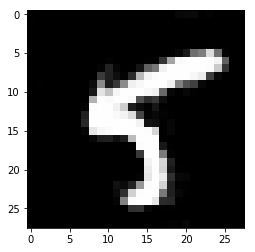

Epoch 2/2... Discriminator Loss: 0.9517... Generator Loss: 1.1110


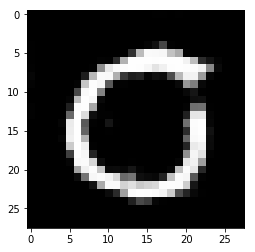

Epoch 2/2... Discriminator Loss: 1.2067... Generator Loss: 0.7198


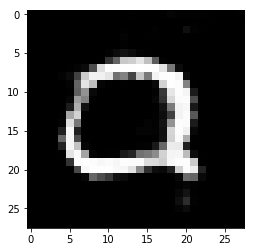

Epoch 2/2... Discriminator Loss: 0.8201... Generator Loss: 1.2750


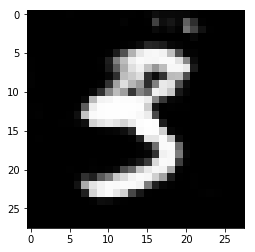

Epoch 2/2... Discriminator Loss: 1.6364... Generator Loss: 0.5733


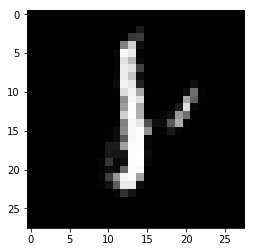

Epoch 2/2... Discriminator Loss: 1.2075... Generator Loss: 4.3406


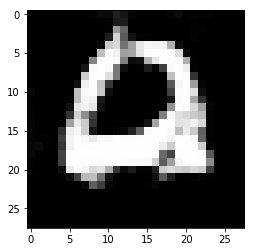

Epoch 2/2... Discriminator Loss: 0.9593... Generator Loss: 0.9340


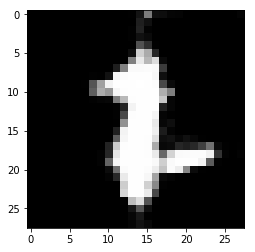

Epoch 2/2... Discriminator Loss: 1.0448... Generator Loss: 1.2591


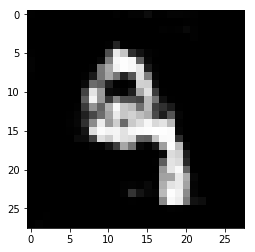

Epoch 2/2... Discriminator Loss: 0.8399... Generator Loss: 1.5583


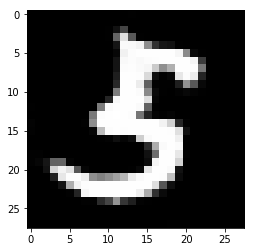

Epoch 2/2... Discriminator Loss: 2.0929... Generator Loss: 0.3606


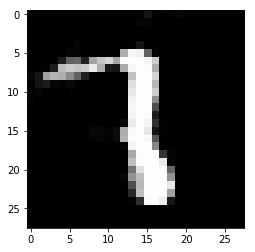

Epoch 2/2... Discriminator Loss: 2.4074... Generator Loss: 0.2128


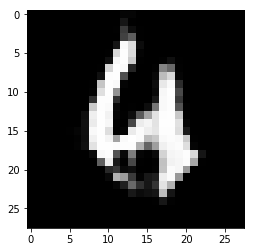

Epoch 2/2... Discriminator Loss: 1.6022... Generator Loss: 0.5125


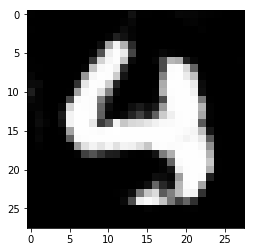

Epoch 2/2... Discriminator Loss: 1.0845... Generator Loss: 0.8539


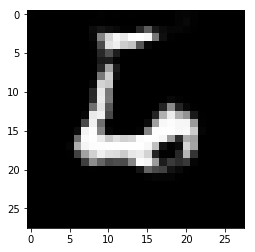

Epoch 2/2... Discriminator Loss: 1.1579... Generator Loss: 0.8442


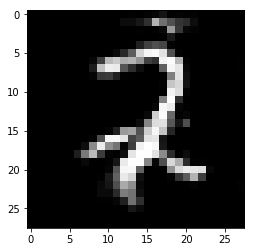

Epoch 2/2... Discriminator Loss: 2.1900... Generator Loss: 0.4136


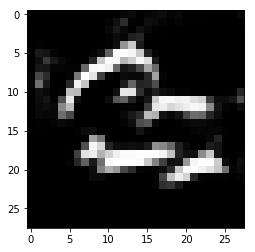

Epoch 2/2... Discriminator Loss: 2.3219... Generator Loss: 0.3211


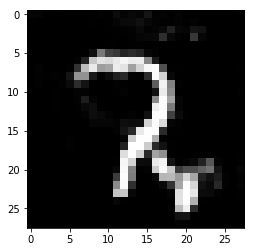

Epoch 2/2... Discriminator Loss: 1.0800... Generator Loss: 2.2771


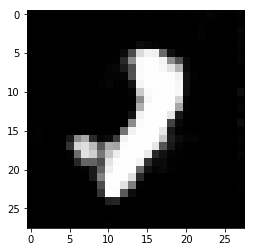

Epoch 2/2... Discriminator Loss: 3.3473... Generator Loss: 0.0791


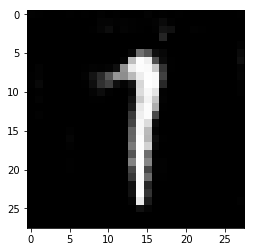

Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 0.8839


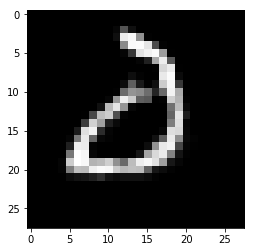

Epoch 2/2... Discriminator Loss: 0.7419... Generator Loss: 1.5090


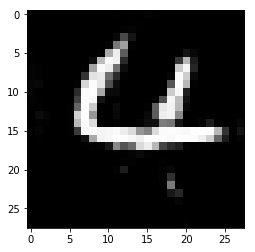

Epoch 2/2... Discriminator Loss: 1.2103... Generator Loss: 0.7069


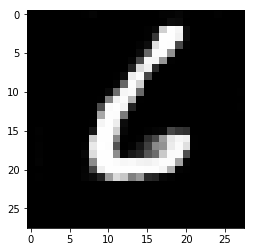

Epoch 2/2... Discriminator Loss: 2.4186... Generator Loss: 0.2063


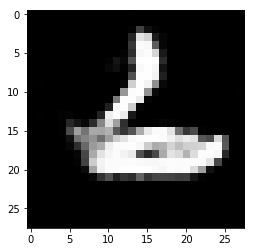

Epoch 2/2... Discriminator Loss: 4.0385... Generator Loss: 0.0495


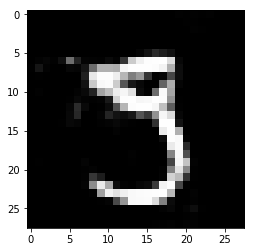

Epoch 2/2... Discriminator Loss: 1.9902... Generator Loss: 0.3872


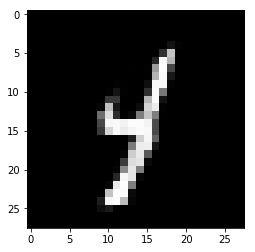

Epoch 2/2... Discriminator Loss: 3.3893... Generator Loss: 0.0780


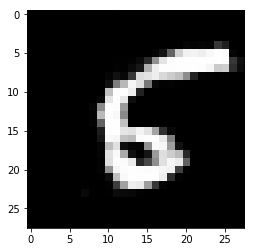

Epoch 2/2... Discriminator Loss: 2.3186... Generator Loss: 0.2512


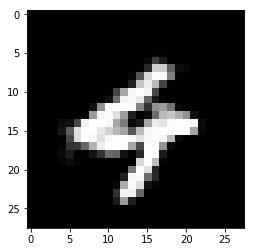

Epoch 2/2... Discriminator Loss: 3.0589... Generator Loss: 0.1081


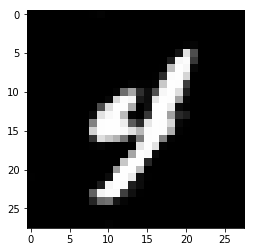

Epoch 2/2... Discriminator Loss: 0.8426... Generator Loss: 1.3592


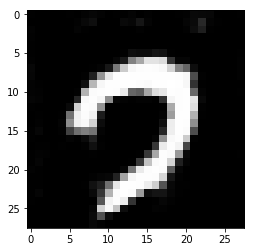

Epoch 2/2... Discriminator Loss: 0.8291... Generator Loss: 1.0747


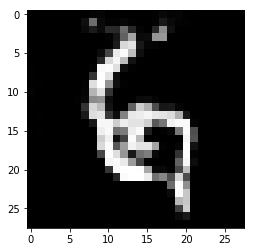

Epoch 2/2... Discriminator Loss: 0.8195... Generator Loss: 1.2585


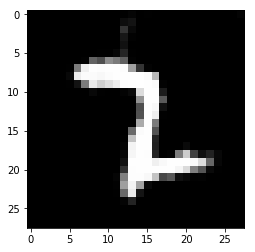

Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.6431


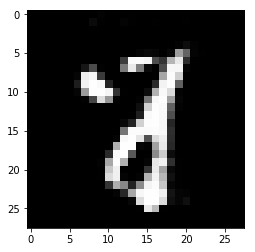

Epoch 2/2... Discriminator Loss: 0.7626... Generator Loss: 1.2522


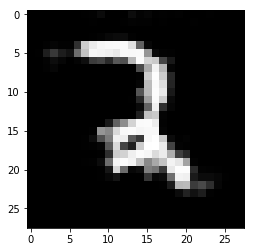

Epoch 2/2... Discriminator Loss: 0.1983... Generator Loss: 3.3482


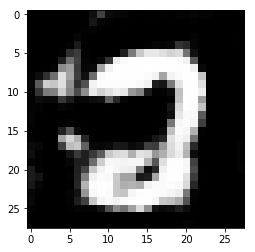

Epoch 2/2... Discriminator Loss: 0.7351... Generator Loss: 1.0687


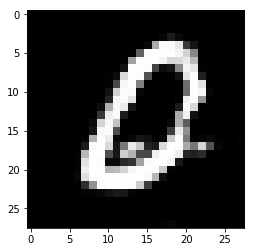

Epoch 2/2... Discriminator Loss: 0.9475... Generator Loss: 0.8943


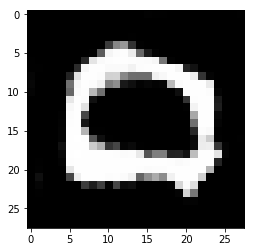

Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 1.0687


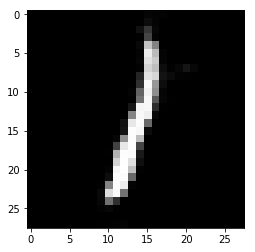

Epoch 2/2... Discriminator Loss: 3.7555... Generator Loss: 0.0674


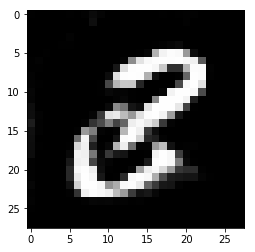

Epoch 2/2... Discriminator Loss: 1.6060... Generator Loss: 0.4711


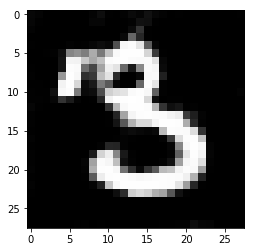

Epoch 2/2... Discriminator Loss: 1.3992... Generator Loss: 0.6840


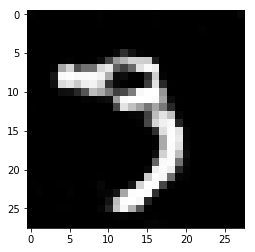

Epoch 2/2... Discriminator Loss: 1.4226... Generator Loss: 0.5270


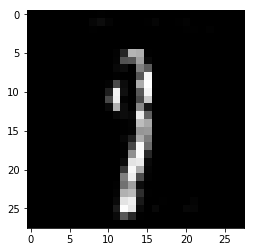

Epoch 2/2... Discriminator Loss: 0.4599... Generator Loss: 1.7040


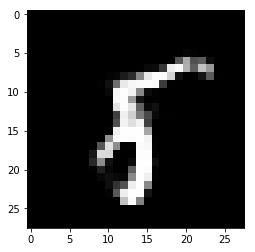

Epoch 2/2... Discriminator Loss: 1.5126... Generator Loss: 0.7640


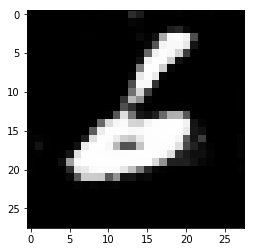

Epoch 2/2... Discriminator Loss: 2.7524... Generator Loss: 0.2157


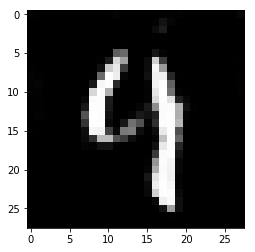

Epoch 2/2... Discriminator Loss: 1.4776... Generator Loss: 0.5955


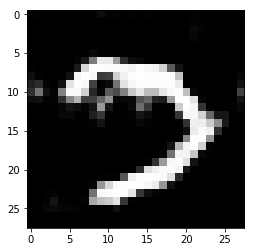

Epoch 2/2... Discriminator Loss: 2.2597... Generator Loss: 0.2429


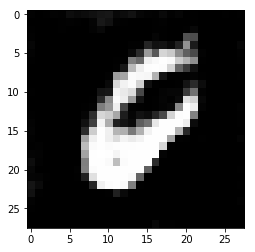

Epoch 2/2... Discriminator Loss: 0.7990... Generator Loss: 1.4766


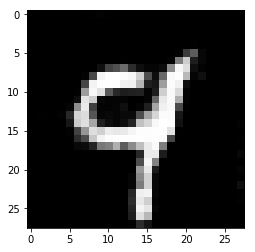

Epoch 2/2... Discriminator Loss: 2.3973... Generator Loss: 0.2414


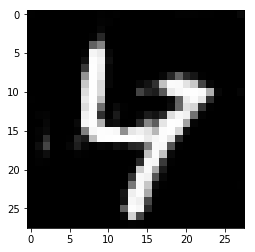

Epoch 2/2... Discriminator Loss: 0.9560... Generator Loss: 2.6982


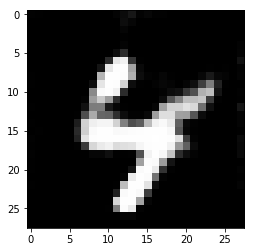

Epoch 2/2... Discriminator Loss: 1.9047... Generator Loss: 0.3096


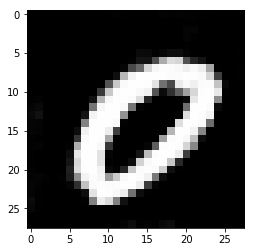

Epoch 2/2... Discriminator Loss: 0.6642... Generator Loss: 1.1983


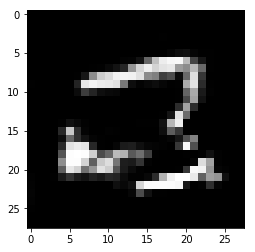

Epoch 2/2... Discriminator Loss: 1.7604... Generator Loss: 0.3621


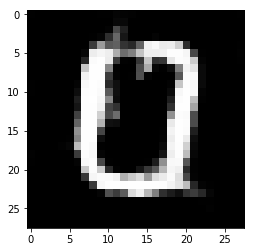

Epoch 2/2... Discriminator Loss: 4.0436... Generator Loss: 0.0915


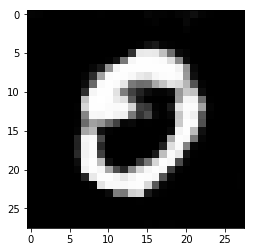

Epoch 2/2... Discriminator Loss: 1.7333... Generator Loss: 0.4725


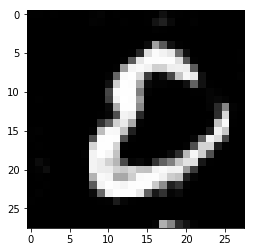

Epoch 2/2... Discriminator Loss: 0.1592... Generator Loss: 3.9051


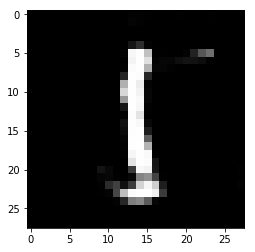

Epoch 2/2... Discriminator Loss: 1.0782... Generator Loss: 0.9256


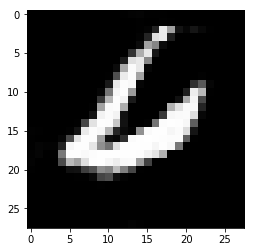

Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 1.1051


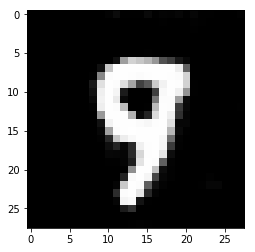

Epoch 2/2... Discriminator Loss: 1.8046... Generator Loss: 0.4417


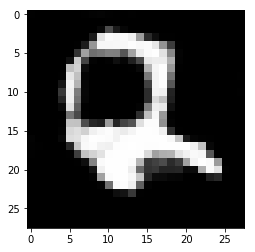

Epoch 2/2... Discriminator Loss: 0.8349... Generator Loss: 0.9549


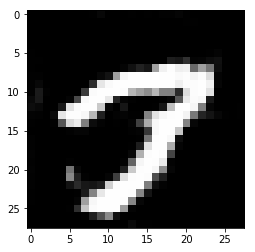

Epoch 2/2... Discriminator Loss: 0.5266... Generator Loss: 1.5383


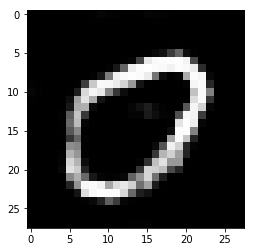

Epoch 2/2... Discriminator Loss: 0.5957... Generator Loss: 1.3336


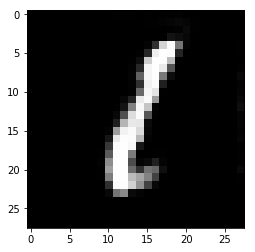

Epoch 2/2... Discriminator Loss: 2.2844... Generator Loss: 0.3870


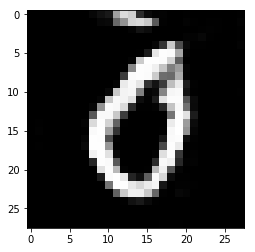

Epoch 2/2... Discriminator Loss: 0.8920... Generator Loss: 0.8431


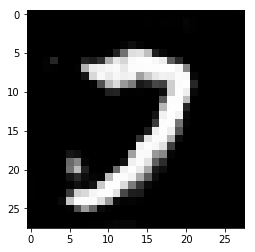

Epoch 2/2... Discriminator Loss: 1.0662... Generator Loss: 0.6853


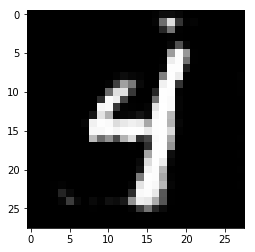

Epoch 2/2... Discriminator Loss: 0.8319... Generator Loss: 1.0182


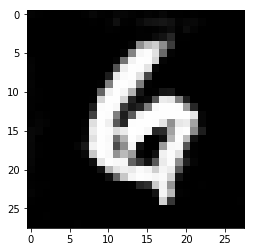

Epoch 2/2... Discriminator Loss: 1.0144... Generator Loss: 0.7409


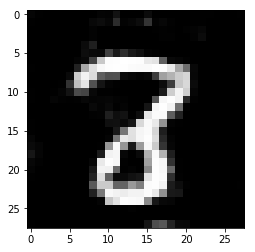

Epoch 2/2... Discriminator Loss: 3.7013... Generator Loss: 0.0640


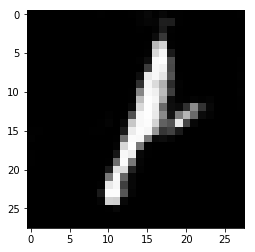

Epoch 2/2... Discriminator Loss: 1.3317... Generator Loss: 0.7203


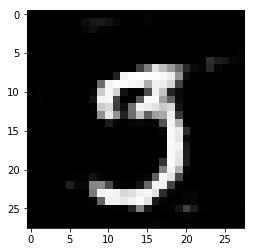

Epoch 2/2... Discriminator Loss: 1.0087... Generator Loss: 1.0501


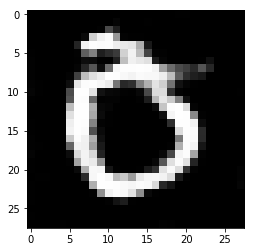

Epoch 2/2... Discriminator Loss: 0.3877... Generator Loss: 2.2506


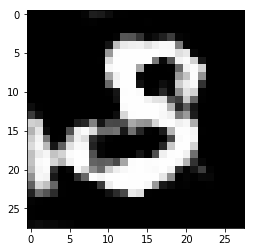

Epoch 2/2... Discriminator Loss: 1.0043... Generator Loss: 0.9984


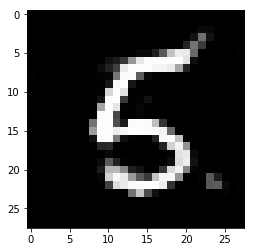

Epoch 2/2... Discriminator Loss: 1.4075... Generator Loss: 0.8820


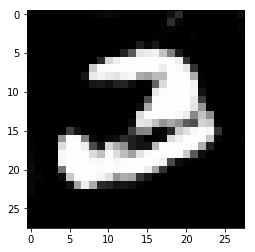

Epoch 2/2... Discriminator Loss: 0.9230... Generator Loss: 1.0184


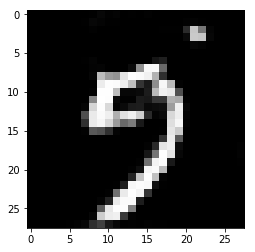

Epoch 2/2... Discriminator Loss: 1.3180... Generator Loss: 0.7197


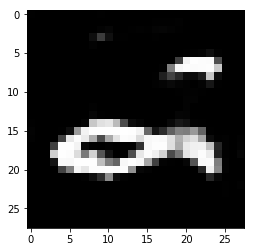

Epoch 2/2... Discriminator Loss: 3.3192... Generator Loss: 0.1310


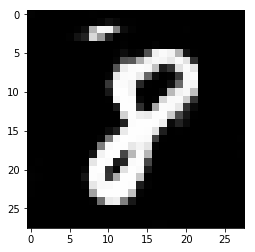

Epoch 2/2... Discriminator Loss: 1.5808... Generator Loss: 0.4865


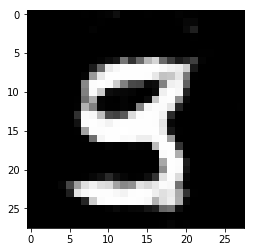

Epoch 2/2... Discriminator Loss: 0.9164... Generator Loss: 1.9370


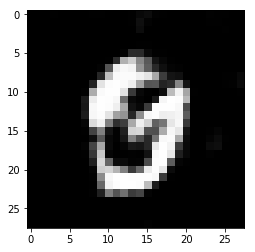

Epoch 2/2... Discriminator Loss: 0.7304... Generator Loss: 1.2962


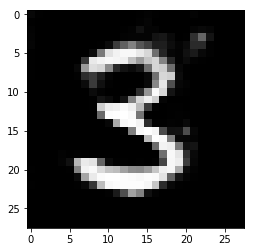

Epoch 2/2... Discriminator Loss: 1.6016... Generator Loss: 0.4437


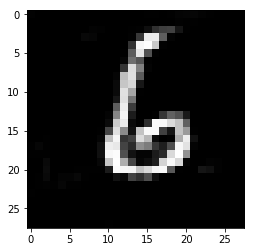

Epoch 2/2... Discriminator Loss: 0.7694... Generator Loss: 2.8621


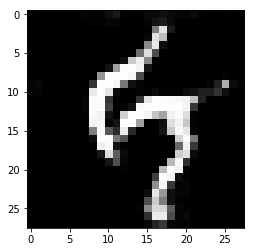

Epoch 2/2... Discriminator Loss: 2.1339... Generator Loss: 0.3518


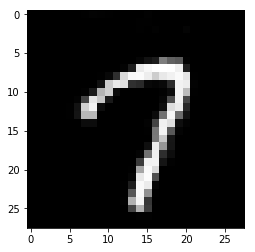

Epoch 2/2... Discriminator Loss: 0.6651... Generator Loss: 1.2259


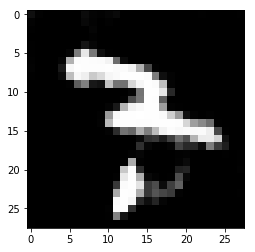

Epoch 2/2... Discriminator Loss: 0.6696... Generator Loss: 1.2096


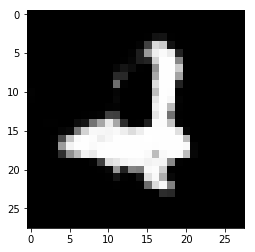

Epoch 2/2... Discriminator Loss: 2.9621... Generator Loss: 0.1705


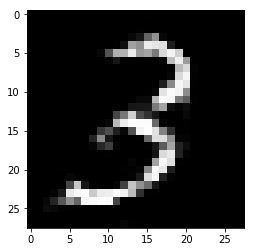

Epoch 2/2... Discriminator Loss: 3.0641... Generator Loss: 0.1630


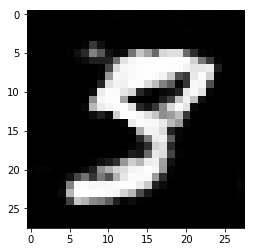

Epoch 2/2... Discriminator Loss: 1.9984... Generator Loss: 0.4610


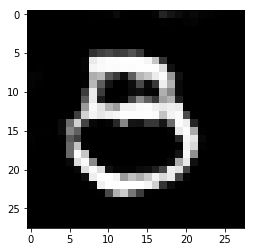

Epoch 2/2... Discriminator Loss: 0.7930... Generator Loss: 1.2030


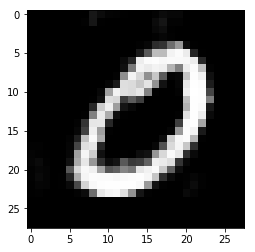

Epoch 2/2... Discriminator Loss: 0.4600... Generator Loss: 1.6505


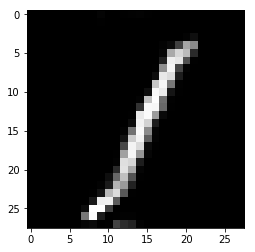

Epoch 2/2... Discriminator Loss: 1.0805... Generator Loss: 0.8878


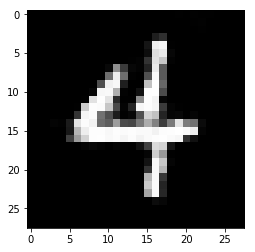

Epoch 2/2... Discriminator Loss: 1.6612... Generator Loss: 0.5456


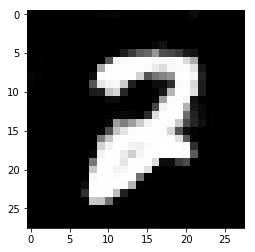

Epoch 2/2... Discriminator Loss: 0.5501... Generator Loss: 2.0994


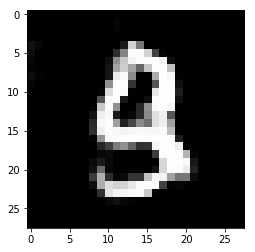

Epoch 2/2... Discriminator Loss: 0.7765... Generator Loss: 1.0991


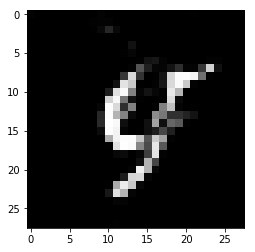

Epoch 2/2... Discriminator Loss: 0.2513... Generator Loss: 2.3306


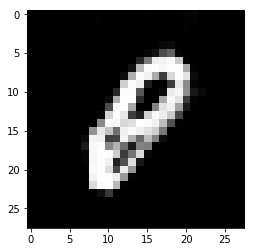

Epoch 2/2... Discriminator Loss: 0.6619... Generator Loss: 1.3009


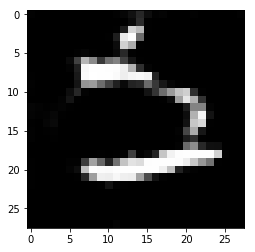

Epoch 2/2... Discriminator Loss: 3.0043... Generator Loss: 0.2410


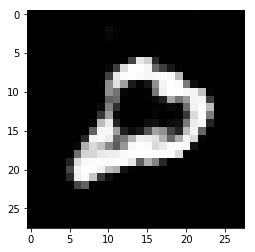

Epoch 2/2... Discriminator Loss: 2.0168... Generator Loss: 0.3702


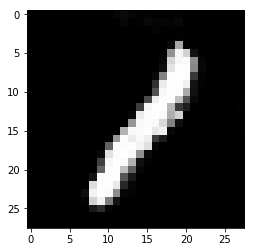

Epoch 2/2... Discriminator Loss: 0.6471... Generator Loss: 1.2344


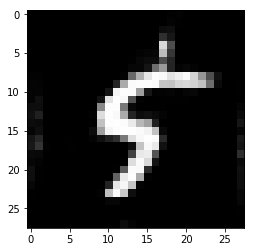

Epoch 2/2... Discriminator Loss: 1.7413... Generator Loss: 0.8676


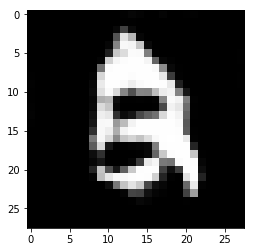

Epoch 2/2... Discriminator Loss: 1.3366... Generator Loss: 0.6492


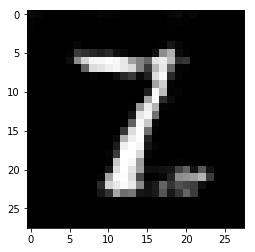

Epoch 2/2... Discriminator Loss: 3.2833... Generator Loss: 0.3351


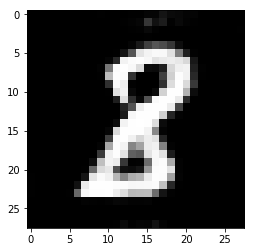

Epoch 2/2... Discriminator Loss: 0.6134... Generator Loss: 1.5640


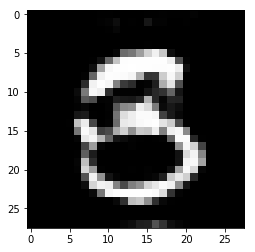

Epoch 2/2... Discriminator Loss: 0.9632... Generator Loss: 1.5635


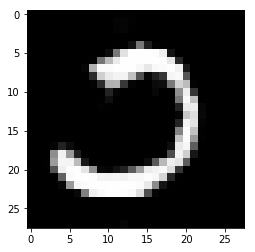

Epoch 2/2... Discriminator Loss: 0.8318... Generator Loss: 1.4591


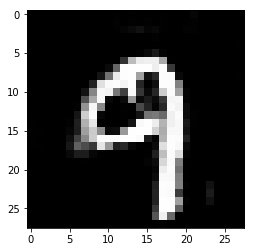

Epoch 2/2... Discriminator Loss: 1.0461... Generator Loss: 1.1178


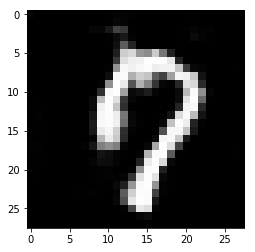

Epoch 2/2... Discriminator Loss: 0.4973... Generator Loss: 3.5534


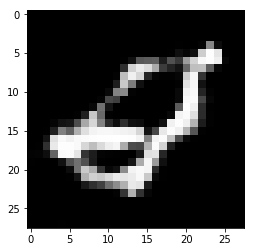

Epoch 2/2... Discriminator Loss: 0.5662... Generator Loss: 1.5014


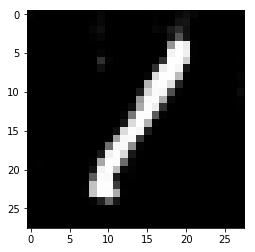

Epoch 2/2... Discriminator Loss: 0.7245... Generator Loss: 1.4546


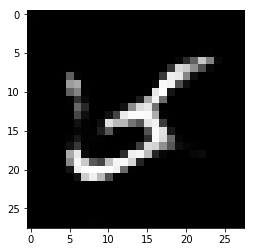

Epoch 2/2... Discriminator Loss: 1.5032... Generator Loss: 0.5652


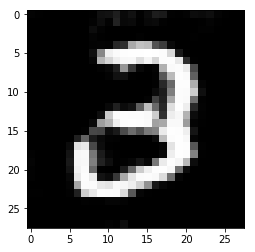

Epoch 2/2... Discriminator Loss: 3.3782... Generator Loss: 0.1100


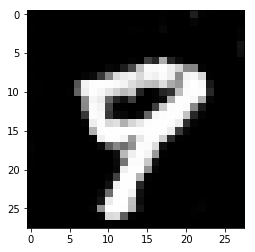

Epoch 2/2... Discriminator Loss: 1.8186... Generator Loss: 1.7261


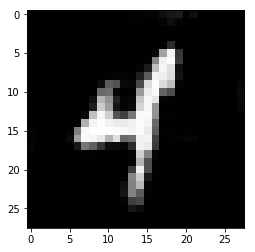

Epoch 2/2... Discriminator Loss: 0.4966... Generator Loss: 2.2768


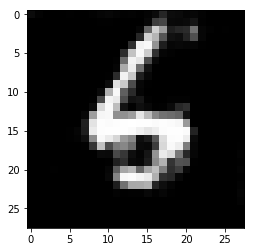

In [13]:
batch_size = 32
z_dim = 512
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2137... Generator Loss: 2.4255


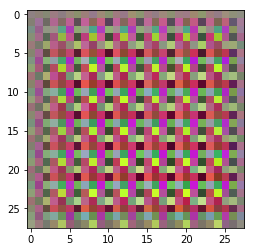

Epoch 1/1... Discriminator Loss: 0.1688... Generator Loss: 22.0642


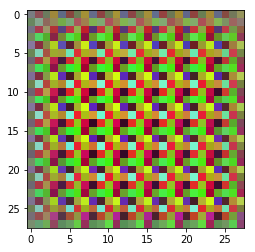

Epoch 1/1... Discriminator Loss: 0.0049... Generator Loss: 8.4062


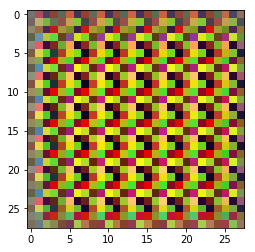

Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 18.4648


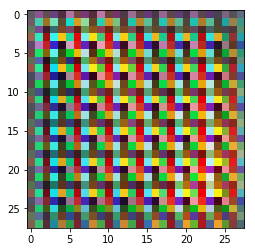

Epoch 1/1... Discriminator Loss: 8.5818... Generator Loss: 0.0011


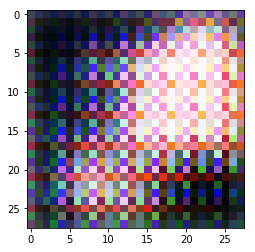

Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.8757


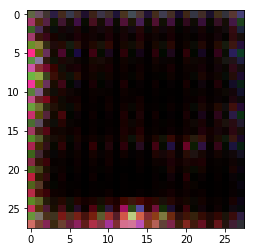

Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 1.3527


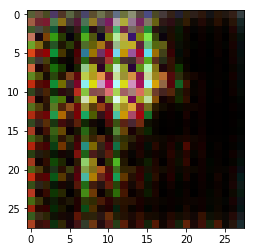

Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 2.8668


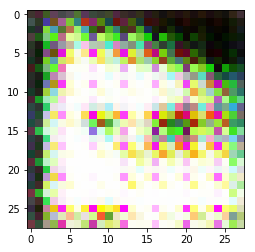

Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 0.8599


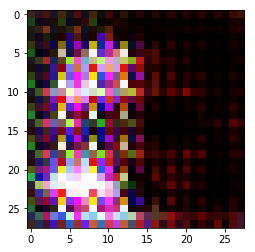

Epoch 1/1... Discriminator Loss: 0.7892... Generator Loss: 1.1838


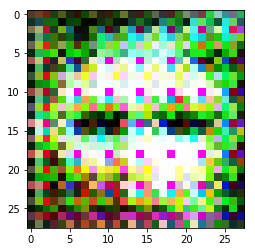

Epoch 1/1... Discriminator Loss: 0.3699... Generator Loss: 2.2444


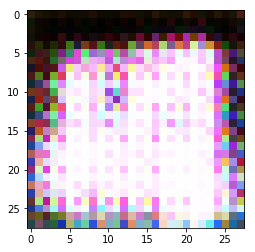

Epoch 1/1... Discriminator Loss: 1.5393... Generator Loss: 0.5552


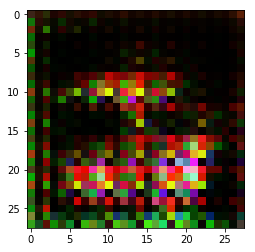

Epoch 1/1... Discriminator Loss: 0.6192... Generator Loss: 1.5727


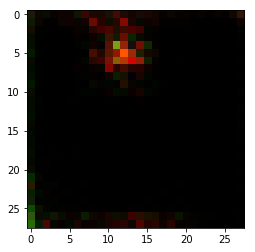

Epoch 1/1... Discriminator Loss: 0.6416... Generator Loss: 1.0771


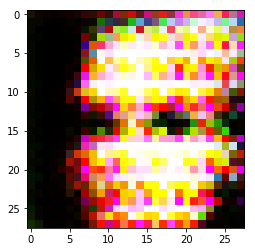

Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 0.9089


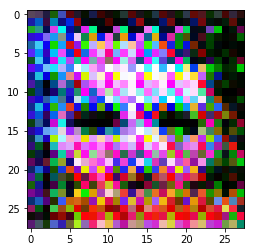

Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 0.8737


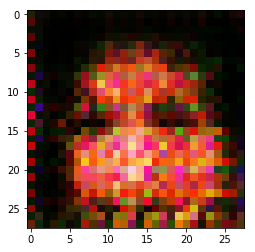

Epoch 1/1... Discriminator Loss: 2.0159... Generator Loss: 0.1919


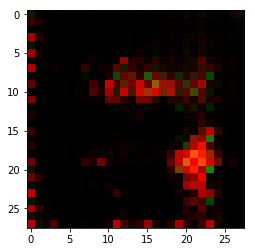

Epoch 1/1... Discriminator Loss: 0.2026... Generator Loss: 2.9702


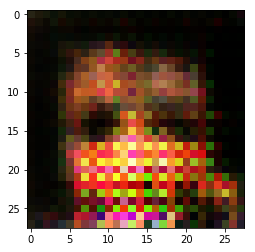

Epoch 1/1... Discriminator Loss: 7.4828... Generator Loss: 9.9437


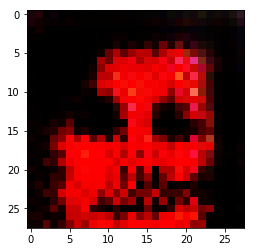

Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 1.2385


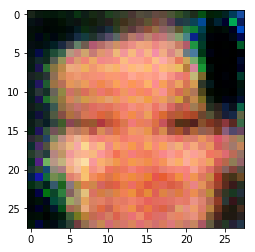

Epoch 1/1... Discriminator Loss: 0.5733... Generator Loss: 1.6804


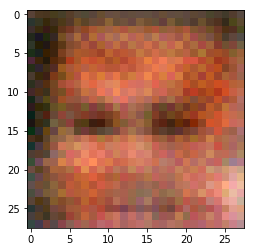

Epoch 1/1... Discriminator Loss: 1.7907... Generator Loss: 0.5452


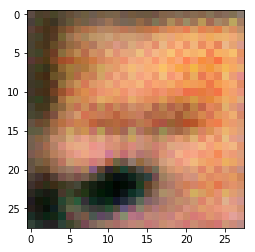

Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 0.9562


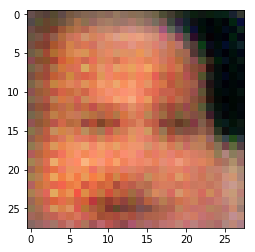

Epoch 1/1... Discriminator Loss: 1.6061... Generator Loss: 0.5477


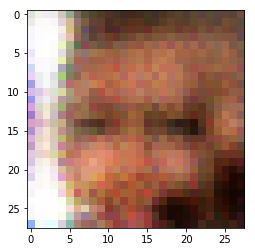

Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.6322


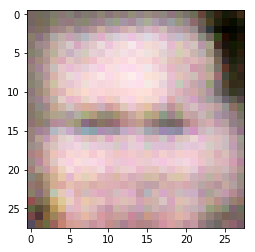

Epoch 1/1... Discriminator Loss: 2.0572... Generator Loss: 0.3904


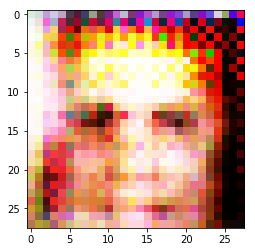

Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.8953


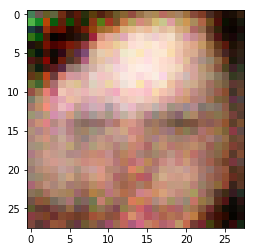

Epoch 1/1... Discriminator Loss: 2.1415... Generator Loss: 1.8563


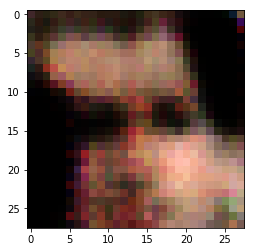

Epoch 1/1... Discriminator Loss: 1.7874... Generator Loss: 1.2280


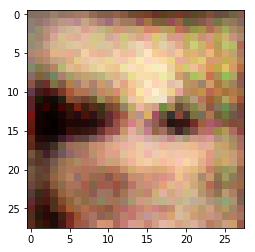

Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.8963


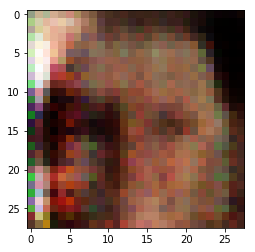

Epoch 1/1... Discriminator Loss: 1.5672... Generator Loss: 0.3485


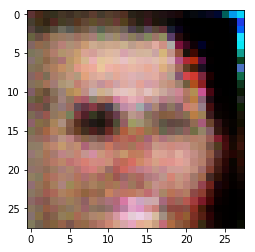

Epoch 1/1... Discriminator Loss: 1.6497... Generator Loss: 0.3228


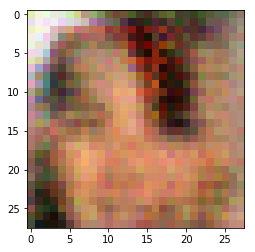

Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6376


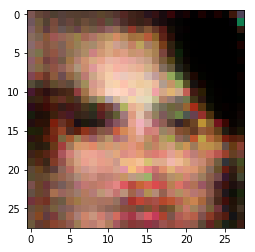

Epoch 1/1... Discriminator Loss: 2.1725... Generator Loss: 0.1886


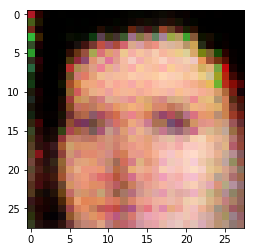

Epoch 1/1... Discriminator Loss: 1.6413... Generator Loss: 0.8494


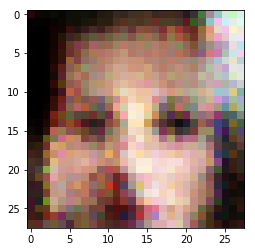

Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.8727


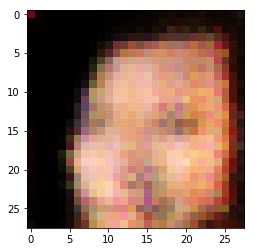

Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.7573


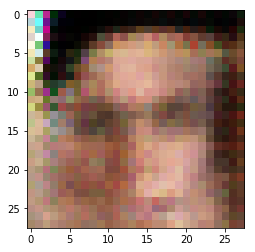

Epoch 1/1... Discriminator Loss: 2.7429... Generator Loss: 0.0764


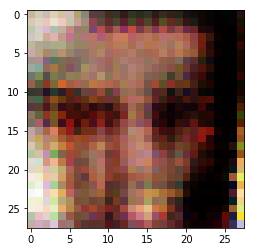

Epoch 1/1... Discriminator Loss: 1.6700... Generator Loss: 0.4394


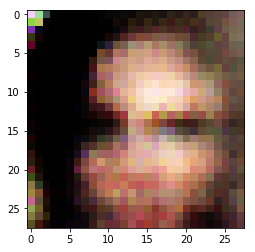

Epoch 1/1... Discriminator Loss: 1.9785... Generator Loss: 0.2244


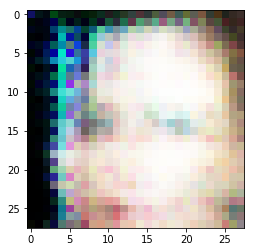

Epoch 1/1... Discriminator Loss: 1.6725... Generator Loss: 0.4990


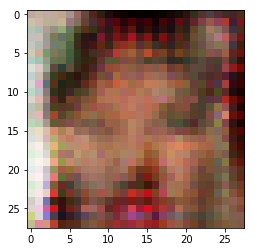

Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 1.9927


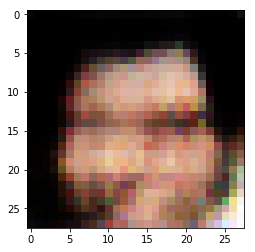

Epoch 1/1... Discriminator Loss: 1.8955... Generator Loss: 0.2793


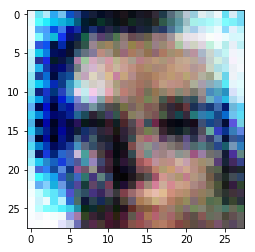

Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 0.8638


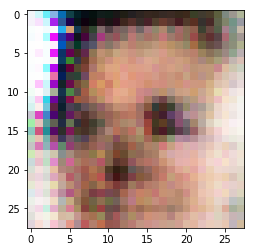

Epoch 1/1... Discriminator Loss: 1.6048... Generator Loss: 0.4425


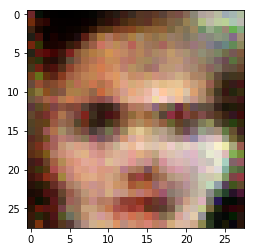

Epoch 1/1... Discriminator Loss: 1.6789... Generator Loss: 1.8763


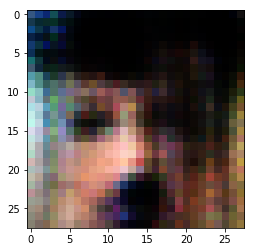

Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 1.2449


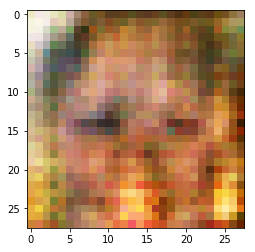

Epoch 1/1... Discriminator Loss: 1.7956... Generator Loss: 0.3555


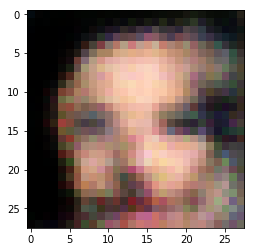

Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6130


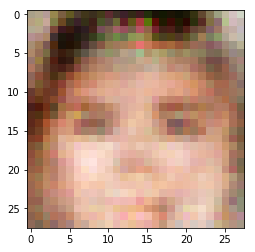

Epoch 1/1... Discriminator Loss: 1.8069... Generator Loss: 0.2859


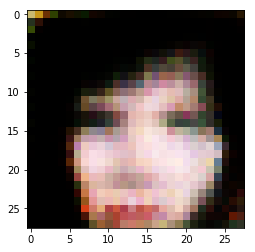

Epoch 1/1... Discriminator Loss: 2.7801... Generator Loss: 3.5531


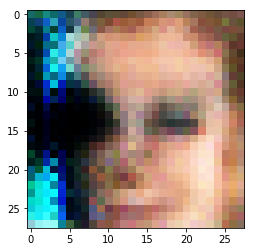

Epoch 1/1... Discriminator Loss: 1.7567... Generator Loss: 0.4954


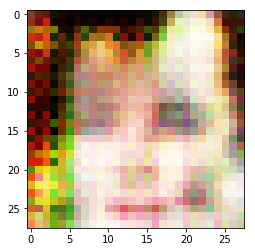

Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.4819


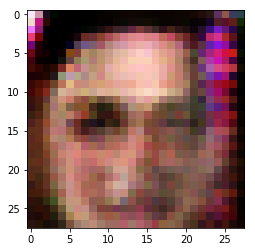

Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.8855


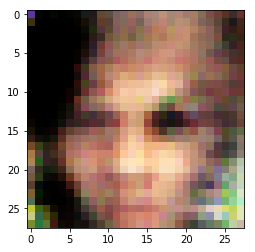

Epoch 1/1... Discriminator Loss: 1.5727... Generator Loss: 0.3857


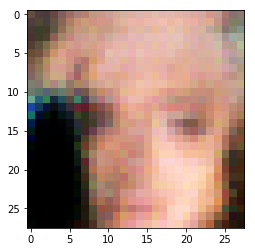

Epoch 1/1... Discriminator Loss: 1.5811... Generator Loss: 0.4138


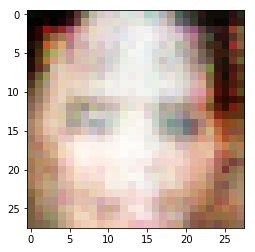

Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.9180


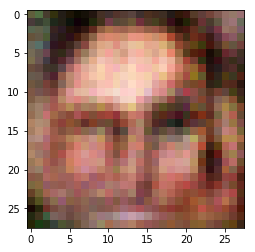

Epoch 1/1... Discriminator Loss: 1.6273... Generator Loss: 0.4097


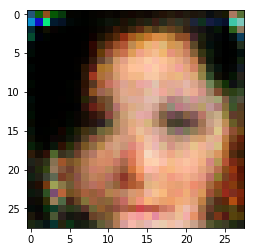

Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.6646


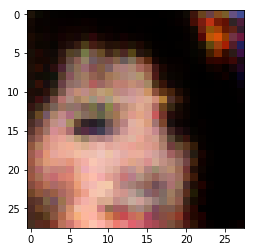

Epoch 1/1... Discriminator Loss: 1.9813... Generator Loss: 0.2072


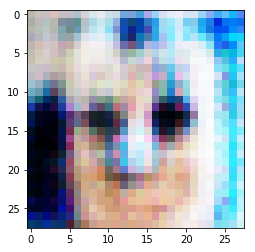

Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.5539


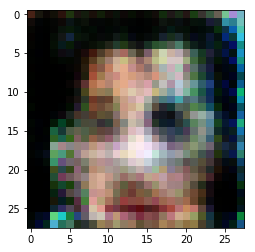

Epoch 1/1... Discriminator Loss: 2.4133... Generator Loss: 2.5451


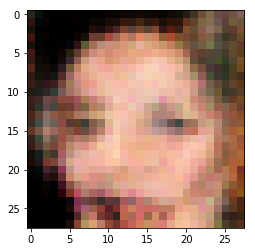

Epoch 1/1... Discriminator Loss: 2.1908... Generator Loss: 0.2046


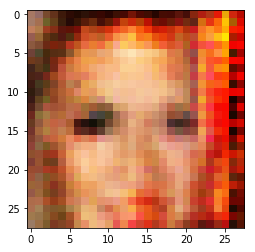

Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 1.1077


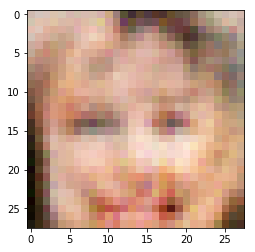

Epoch 1/1... Discriminator Loss: 1.8544... Generator Loss: 0.2428


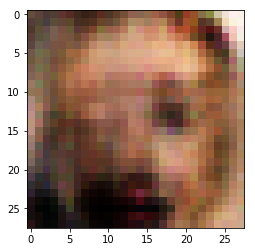

Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.4987


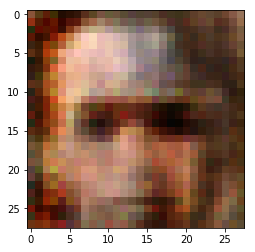

Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.9392


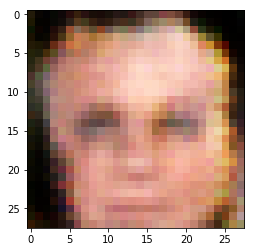

Epoch 1/1... Discriminator Loss: 2.4363... Generator Loss: 0.1339


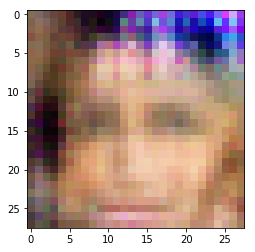

Epoch 1/1... Discriminator Loss: 2.1288... Generator Loss: 0.3285


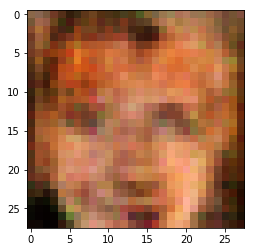

Epoch 1/1... Discriminator Loss: 1.6184... Generator Loss: 0.5117


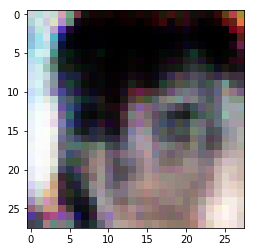

Epoch 1/1... Discriminator Loss: 1.6137... Generator Loss: 0.4060


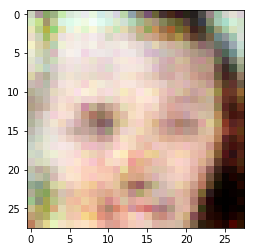

Epoch 1/1... Discriminator Loss: 1.6921... Generator Loss: 0.4119


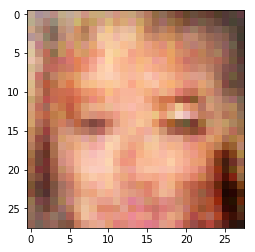

Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 1.6448


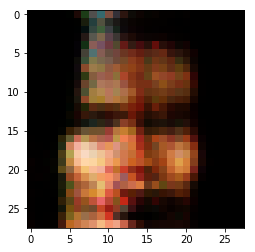

Epoch 1/1... Discriminator Loss: 1.6419... Generator Loss: 0.5196


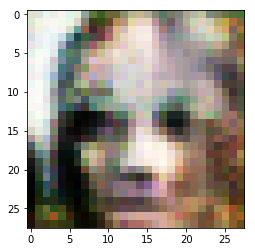

Epoch 1/1... Discriminator Loss: 1.7051... Generator Loss: 0.5212


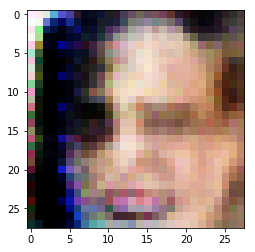

Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.7157


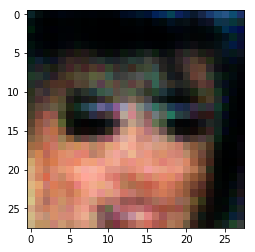

Epoch 1/1... Discriminator Loss: 1.5393... Generator Loss: 0.5436


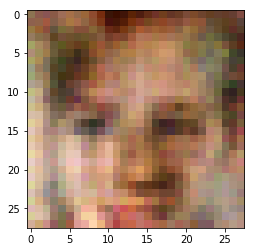

Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.3711


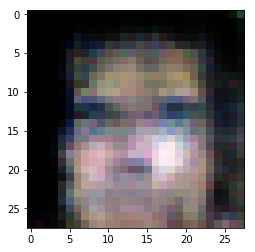

Epoch 1/1... Discriminator Loss: 1.6880... Generator Loss: 0.3269


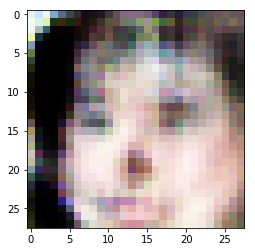

Epoch 1/1... Discriminator Loss: 1.8019... Generator Loss: 0.2850


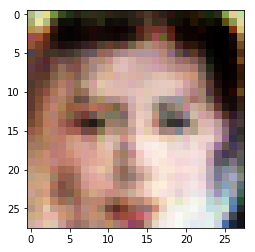

Epoch 1/1... Discriminator Loss: 1.7624... Generator Loss: 0.4540


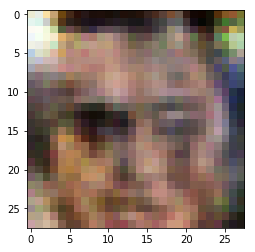

Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 0.8986


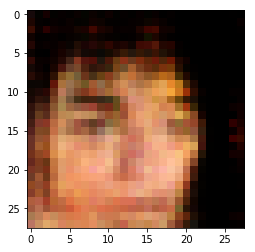

Epoch 1/1... Discriminator Loss: 1.7051... Generator Loss: 1.6404


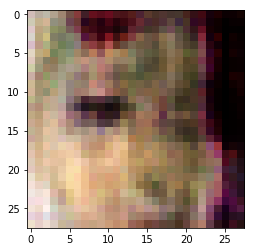

Epoch 1/1... Discriminator Loss: 1.6508... Generator Loss: 0.4406


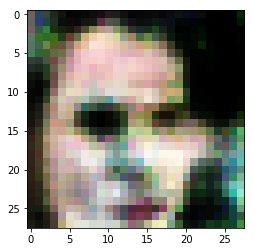

Epoch 1/1... Discriminator Loss: 1.7599... Generator Loss: 1.5648


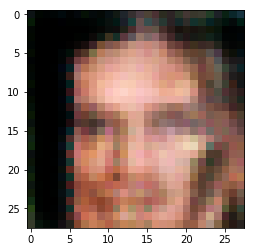

Epoch 1/1... Discriminator Loss: 2.1271... Generator Loss: 0.1666


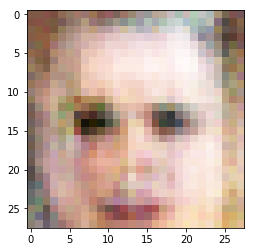

Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.6231


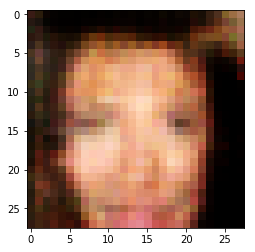

Epoch 1/1... Discriminator Loss: 2.6385... Generator Loss: 0.0900


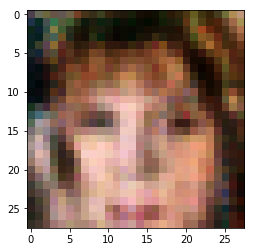

Epoch 1/1... Discriminator Loss: 1.8684... Generator Loss: 0.4158


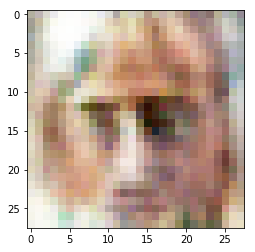

Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.5998


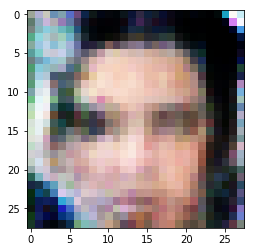

Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 1.2856


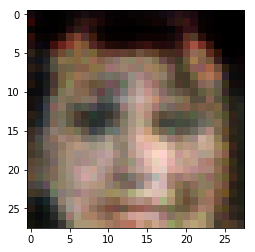

Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.4759


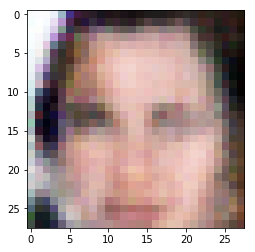

Epoch 1/1... Discriminator Loss: 1.6177... Generator Loss: 0.3395


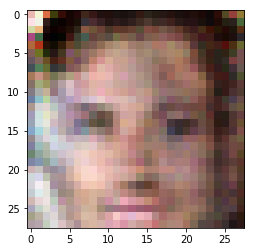

Epoch 1/1... Discriminator Loss: 2.3057... Generator Loss: 0.1496


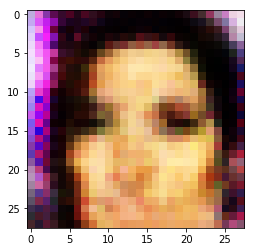

Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.4579


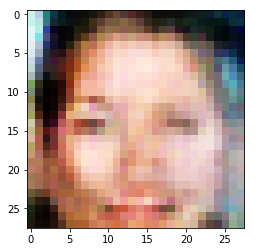

Epoch 1/1... Discriminator Loss: 2.1780... Generator Loss: 0.1865


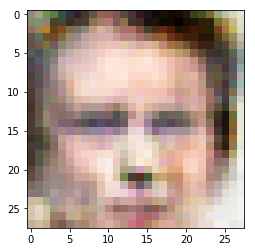

Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 0.4856


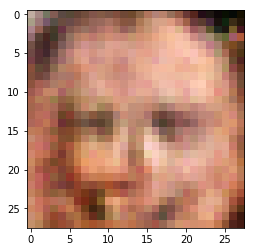

Epoch 1/1... Discriminator Loss: 1.9064... Generator Loss: 0.3137


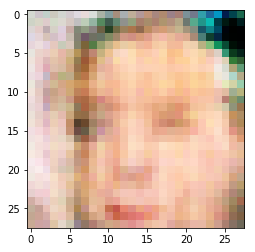

Epoch 1/1... Discriminator Loss: 1.8229... Generator Loss: 0.2778


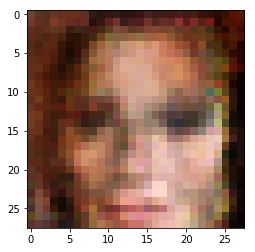

Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.6650


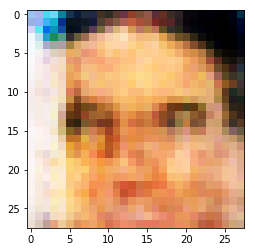

Epoch 1/1... Discriminator Loss: 1.9611... Generator Loss: 0.2098


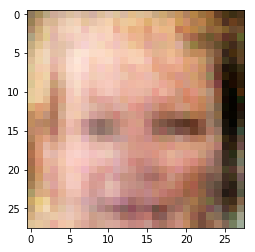

Epoch 1/1... Discriminator Loss: 1.8700... Generator Loss: 0.3709


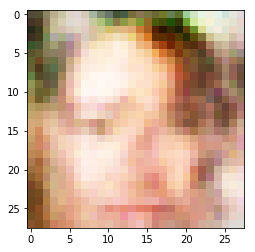

Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.4213


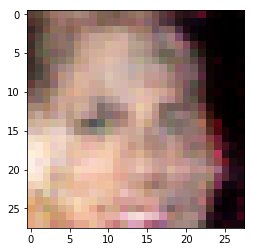

Epoch 1/1... Discriminator Loss: 1.6132... Generator Loss: 0.5845


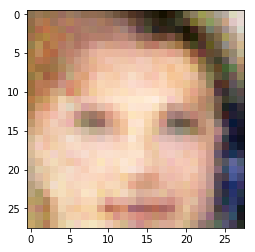

Epoch 1/1... Discriminator Loss: 1.7520... Generator Loss: 0.5115


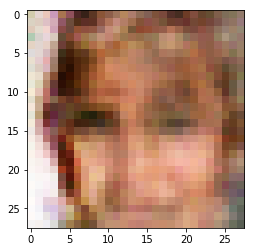

Epoch 1/1... Discriminator Loss: 1.9433... Generator Loss: 0.3106


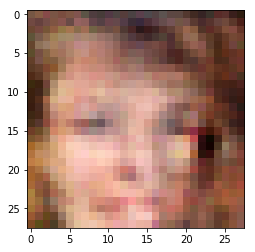

Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.7679


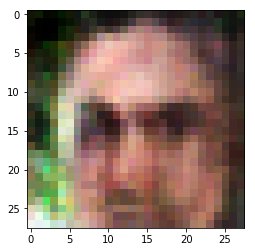

Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.5359


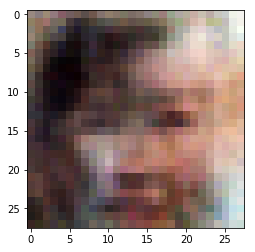

Epoch 1/1... Discriminator Loss: 1.8974... Generator Loss: 1.0462


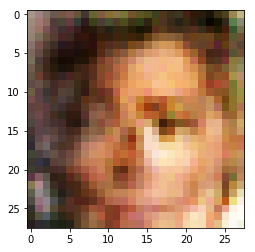

Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.4414


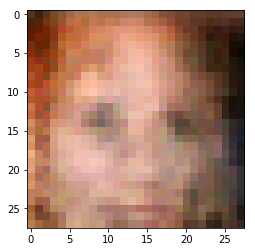

Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.9761


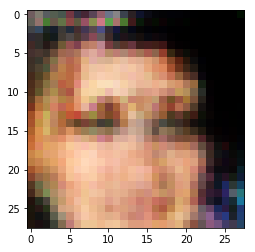

Epoch 1/1... Discriminator Loss: 1.8101... Generator Loss: 0.4045


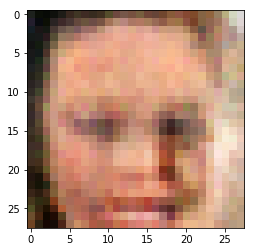

Epoch 1/1... Discriminator Loss: 2.2116... Generator Loss: 1.0118


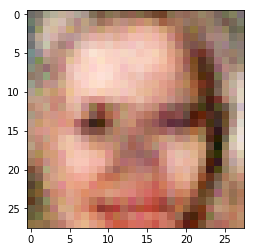

Epoch 1/1... Discriminator Loss: 2.2552... Generator Loss: 0.6731


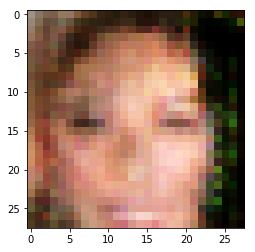

Epoch 1/1... Discriminator Loss: 1.9121... Generator Loss: 0.2419


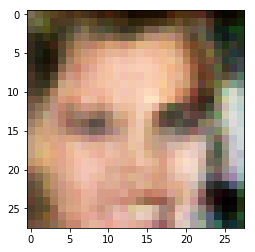

Epoch 1/1... Discriminator Loss: 1.7661... Generator Loss: 0.3166


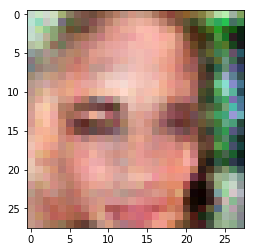

Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.5759


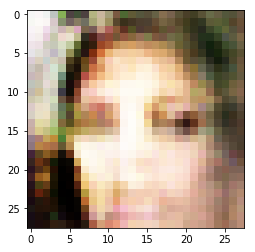

Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.5584


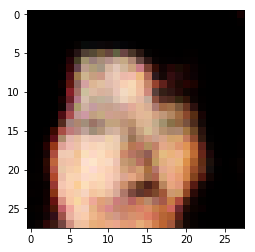

Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.4219


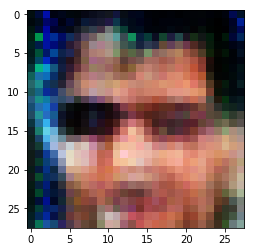

Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.4581


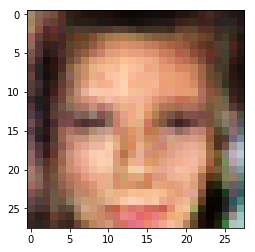

Epoch 1/1... Discriminator Loss: 1.7466... Generator Loss: 0.3228


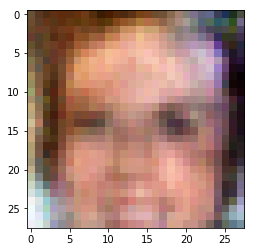

Epoch 1/1... Discriminator Loss: 1.9812... Generator Loss: 0.2980


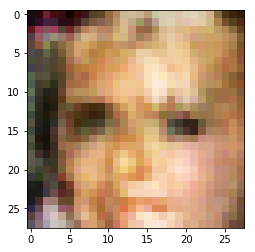

Epoch 1/1... Discriminator Loss: 1.5843... Generator Loss: 0.3911


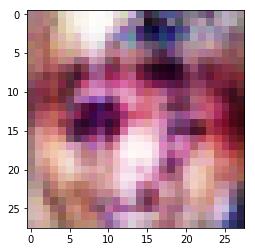

Epoch 1/1... Discriminator Loss: 1.9872... Generator Loss: 0.2862


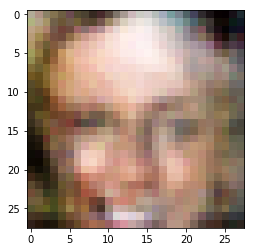

Epoch 1/1... Discriminator Loss: 1.7750... Generator Loss: 0.2792


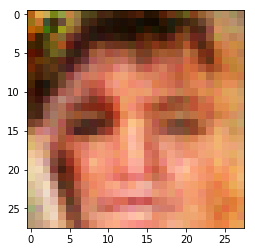

Epoch 1/1... Discriminator Loss: 1.6812... Generator Loss: 0.3295


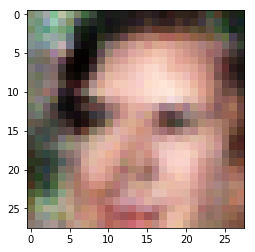

Epoch 1/1... Discriminator Loss: 1.6596... Generator Loss: 0.4816


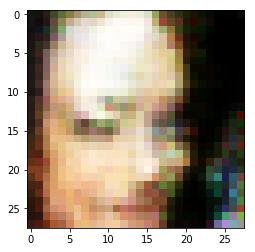

Epoch 1/1... Discriminator Loss: 2.1249... Generator Loss: 0.2571


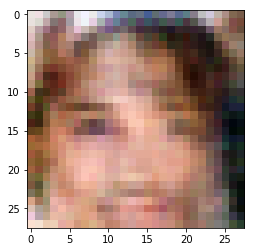

Epoch 1/1... Discriminator Loss: 1.8660... Generator Loss: 0.3462


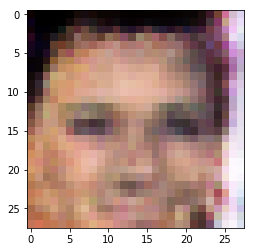

Epoch 1/1... Discriminator Loss: 1.6419... Generator Loss: 0.6446


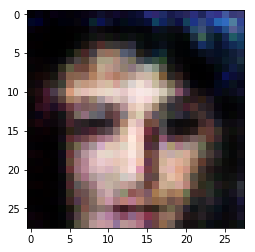

Epoch 1/1... Discriminator Loss: 1.6873... Generator Loss: 0.4219


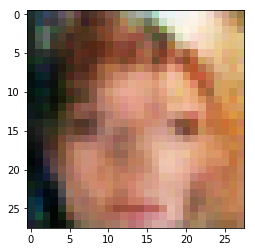

Epoch 1/1... Discriminator Loss: 1.6347... Generator Loss: 0.3678


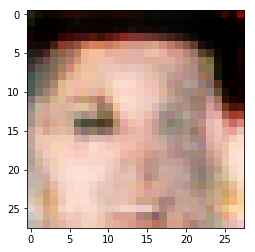

Epoch 1/1... Discriminator Loss: 1.6202... Generator Loss: 0.6580


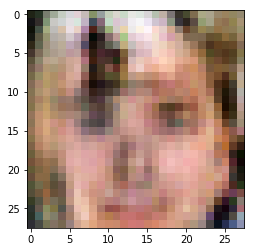

Epoch 1/1... Discriminator Loss: 2.1682... Generator Loss: 0.2033


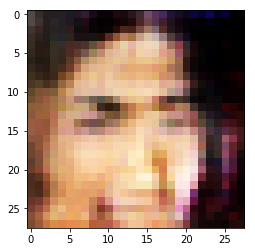

Epoch 1/1... Discriminator Loss: 1.7222... Generator Loss: 0.3549


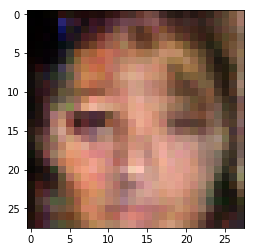

Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.7000


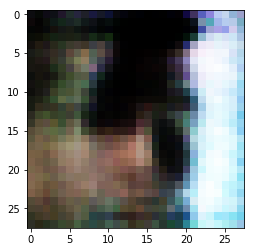

Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.4254


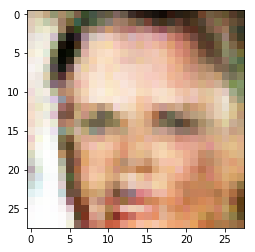

Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.4182


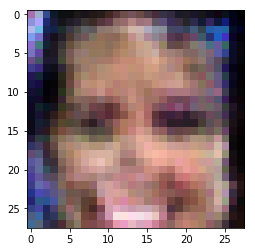

Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.5823


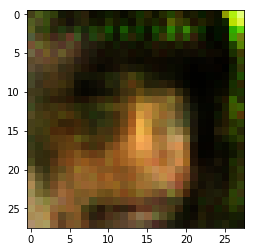

Epoch 1/1... Discriminator Loss: 1.6137... Generator Loss: 0.4964


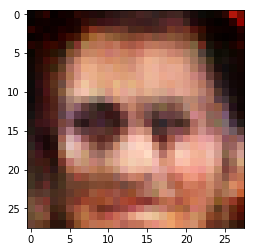

Epoch 1/1... Discriminator Loss: 1.6909... Generator Loss: 0.3074


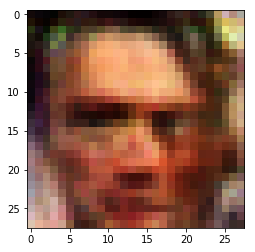

Epoch 1/1... Discriminator Loss: 1.8476... Generator Loss: 0.2413


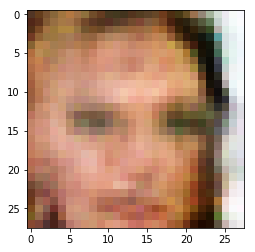

Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.5930


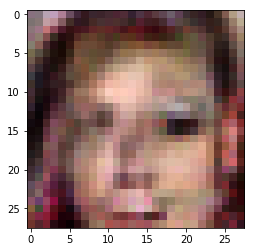

Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.9983


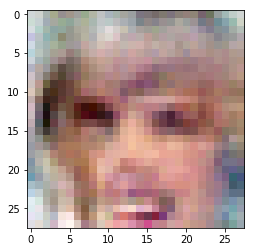

Epoch 1/1... Discriminator Loss: 1.7403... Generator Loss: 0.2953


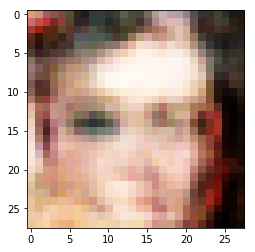

Epoch 1/1... Discriminator Loss: 1.6625... Generator Loss: 0.4289


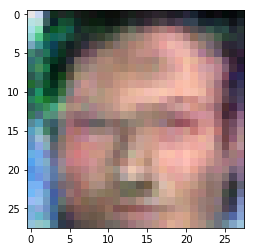

Epoch 1/1... Discriminator Loss: 1.6465... Generator Loss: 0.4479


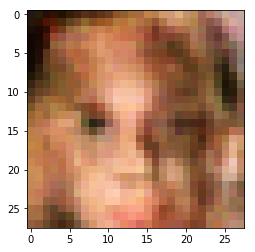

Epoch 1/1... Discriminator Loss: 1.6654... Generator Loss: 0.3413


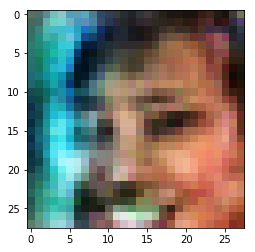

Epoch 1/1... Discriminator Loss: 2.2129... Generator Loss: 0.1773


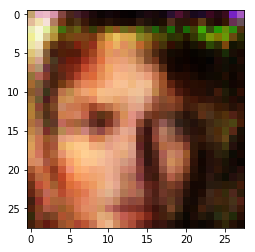

Epoch 1/1... Discriminator Loss: 1.7020... Generator Loss: 0.3216


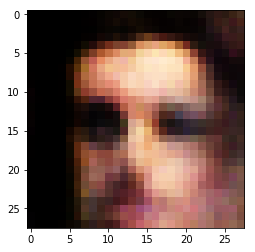

Epoch 1/1... Discriminator Loss: 1.8350... Generator Loss: 0.4237


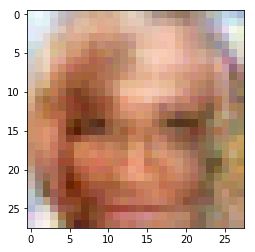

Epoch 1/1... Discriminator Loss: 1.8570... Generator Loss: 0.3667


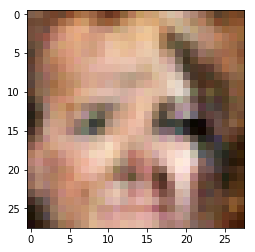

Epoch 1/1... Discriminator Loss: 1.9396... Generator Loss: 0.2429


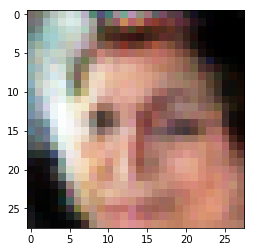

Epoch 1/1... Discriminator Loss: 1.5801... Generator Loss: 0.5430


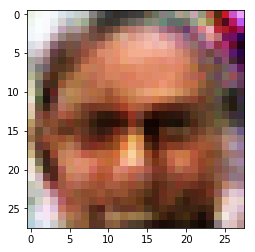

Epoch 1/1... Discriminator Loss: 1.5556... Generator Loss: 0.4253


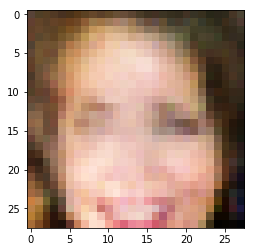

Epoch 1/1... Discriminator Loss: 1.8971... Generator Loss: 0.4287


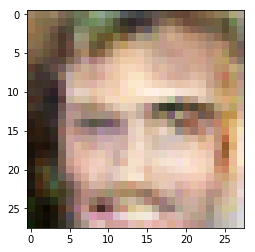

Epoch 1/1... Discriminator Loss: 2.0365... Generator Loss: 0.2436


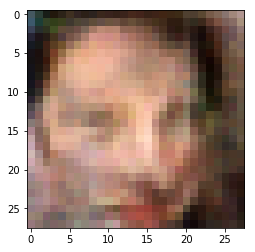

Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 1.1047


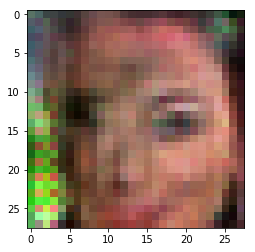

Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.5842


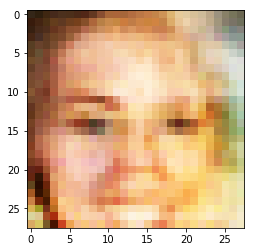

Epoch 1/1... Discriminator Loss: 1.9098... Generator Loss: 0.3299


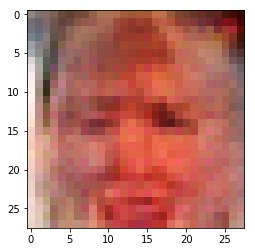

Epoch 1/1... Discriminator Loss: 1.6039... Generator Loss: 0.3827


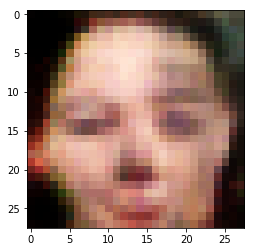

Epoch 1/1... Discriminator Loss: 1.7048... Generator Loss: 0.5668


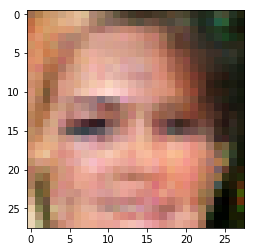

Epoch 1/1... Discriminator Loss: 1.6869... Generator Loss: 0.4046


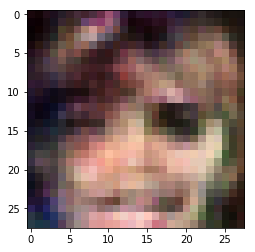

Epoch 1/1... Discriminator Loss: 1.8530... Generator Loss: 0.3331


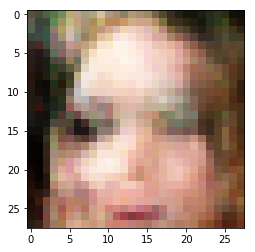

Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.5910


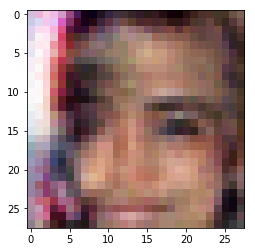

Epoch 1/1... Discriminator Loss: 1.8726... Generator Loss: 0.3770


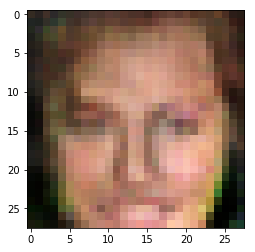

Epoch 1/1... Discriminator Loss: 1.6737... Generator Loss: 0.3255


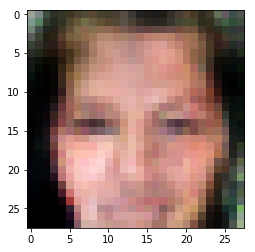

Epoch 1/1... Discriminator Loss: 1.5497... Generator Loss: 0.5963


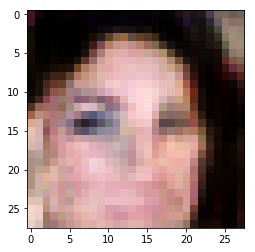

Epoch 1/1... Discriminator Loss: 1.9116... Generator Loss: 0.8821


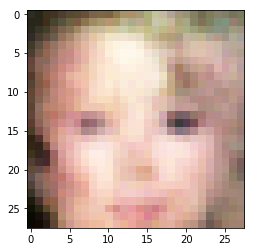

Epoch 1/1... Discriminator Loss: 1.6758... Generator Loss: 0.3747


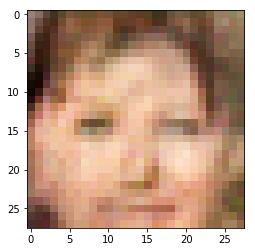

Epoch 1/1... Discriminator Loss: 1.5657... Generator Loss: 0.6847


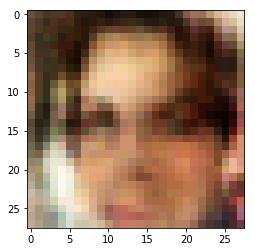

Epoch 1/1... Discriminator Loss: 1.6534... Generator Loss: 0.3774


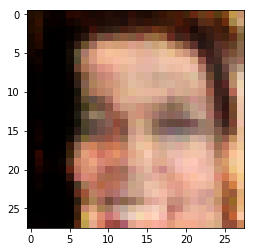

Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.6019


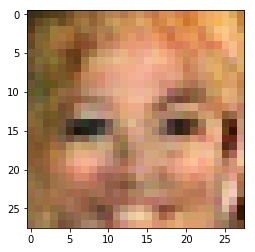

Epoch 1/1... Discriminator Loss: 1.8020... Generator Loss: 0.3714


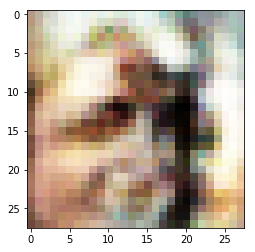

Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.6320


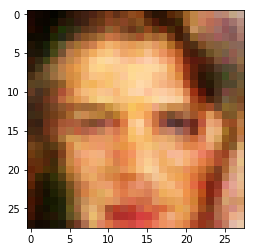

Epoch 1/1... Discriminator Loss: 2.1095... Generator Loss: 0.1792


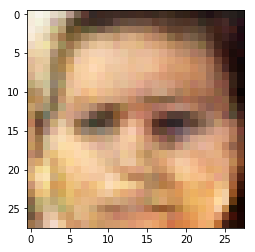

Epoch 1/1... Discriminator Loss: 1.7514... Generator Loss: 0.2991


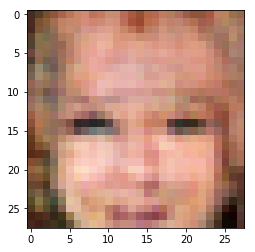

Epoch 1/1... Discriminator Loss: 1.6277... Generator Loss: 0.3846


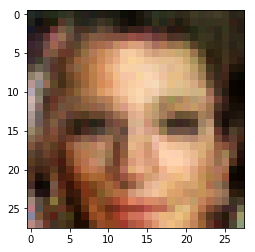

Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.3419


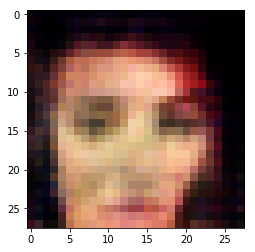

Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.7252


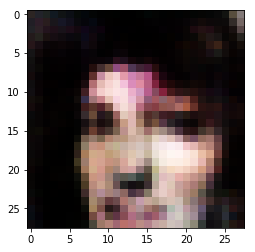

Epoch 1/1... Discriminator Loss: 1.6127... Generator Loss: 0.3831


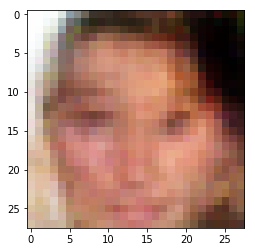

Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.5706


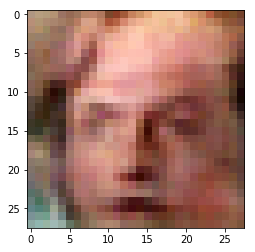

Epoch 1/1... Discriminator Loss: 2.2809... Generator Loss: 0.1484


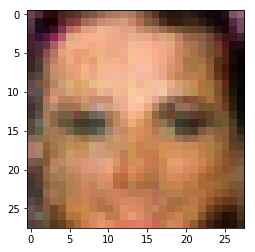

Epoch 1/1... Discriminator Loss: 1.8671... Generator Loss: 0.2453


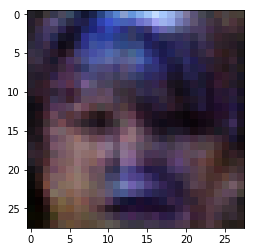

Epoch 1/1... Discriminator Loss: 1.6466... Generator Loss: 0.3555


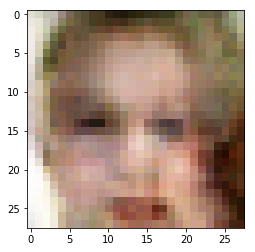

Epoch 1/1... Discriminator Loss: 1.5794... Generator Loss: 0.4452


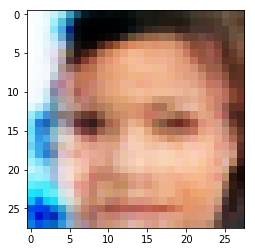

Epoch 1/1... Discriminator Loss: 2.0511... Generator Loss: 0.2056


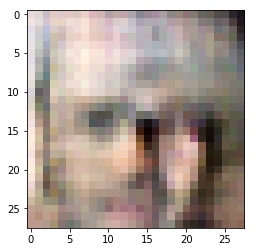

Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.3983


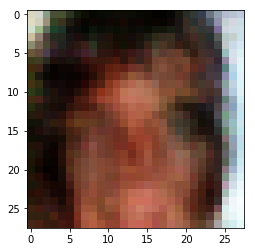

Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.3565


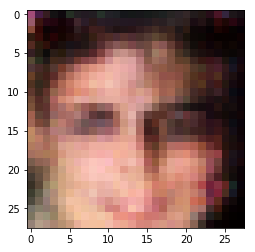

Epoch 1/1... Discriminator Loss: 1.6253... Generator Loss: 0.3766


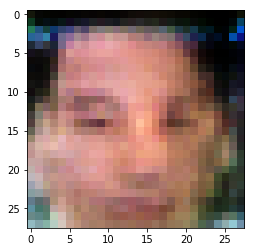

Epoch 1/1... Discriminator Loss: 1.8212... Generator Loss: 0.3554


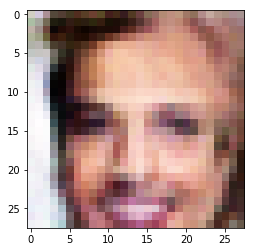

Epoch 1/1... Discriminator Loss: 1.8498... Generator Loss: 0.2836


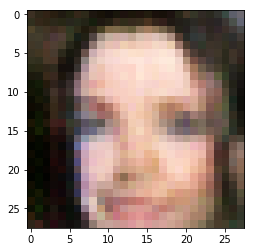

Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 0.3546


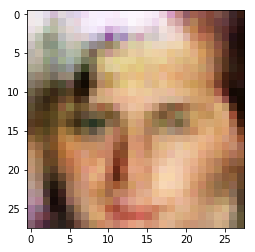

Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.5856


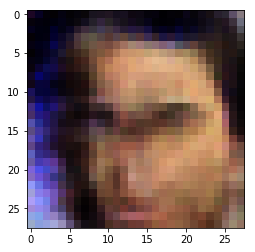

Epoch 1/1... Discriminator Loss: 1.7918... Generator Loss: 0.3033


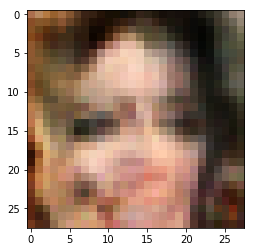

Epoch 1/1... Discriminator Loss: 1.6329... Generator Loss: 0.5947


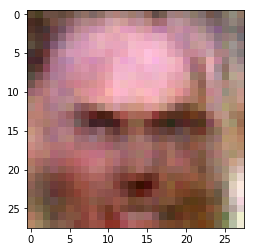

Epoch 1/1... Discriminator Loss: 1.7273... Generator Loss: 0.7542


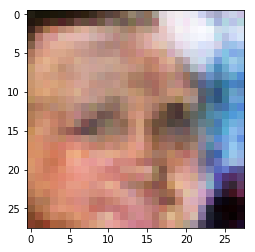

Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.3871


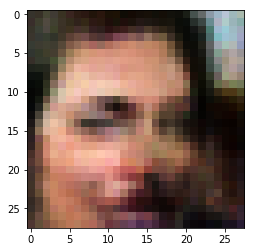

Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.5062


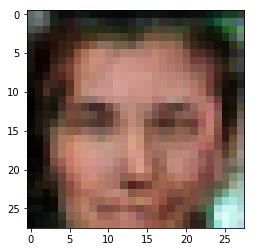

Epoch 1/1... Discriminator Loss: 1.5642... Generator Loss: 0.4799


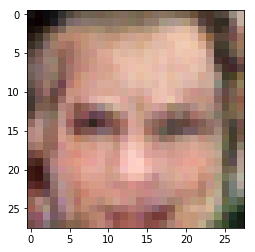

Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.4108


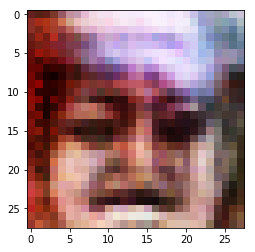

Epoch 1/1... Discriminator Loss: 1.8329... Generator Loss: 0.2846


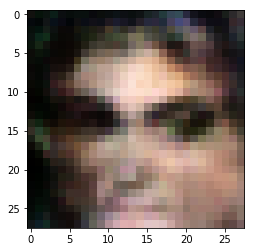

Epoch 1/1... Discriminator Loss: 1.7786... Generator Loss: 0.4104


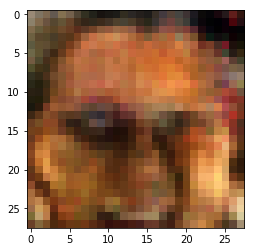

Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.3358


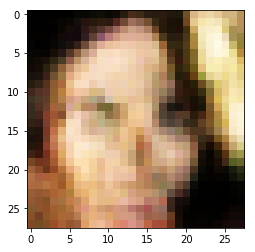

Epoch 1/1... Discriminator Loss: 1.7914... Generator Loss: 0.3293


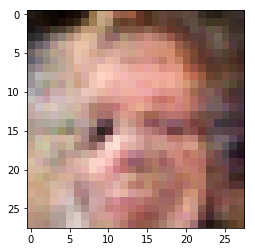

Epoch 1/1... Discriminator Loss: 1.8879... Generator Loss: 0.3277


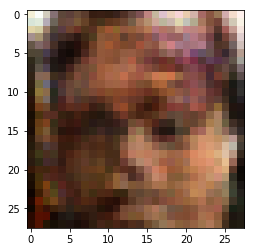

Epoch 1/1... Discriminator Loss: 1.7155... Generator Loss: 0.6312


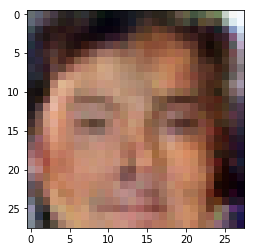

Epoch 1/1... Discriminator Loss: 1.8500... Generator Loss: 0.3343


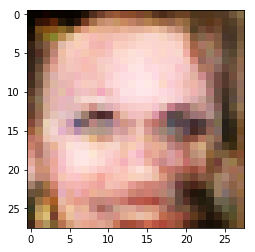

Epoch 1/1... Discriminator Loss: 1.7440... Generator Loss: 0.2844


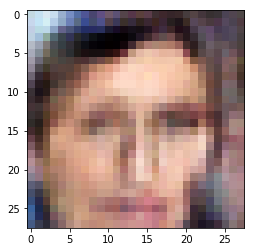

Epoch 1/1... Discriminator Loss: 1.8440... Generator Loss: 0.6069


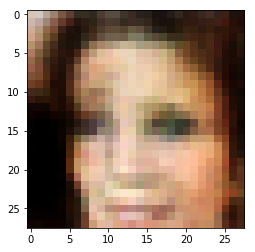

Epoch 1/1... Discriminator Loss: 1.8377... Generator Loss: 0.3416


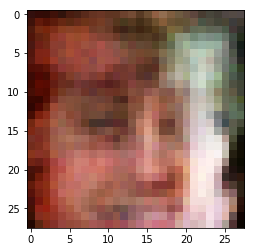

Epoch 1/1... Discriminator Loss: 1.7693... Generator Loss: 0.4614


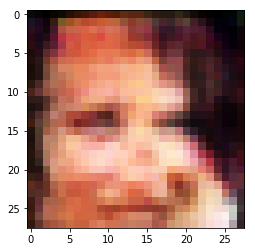

Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.9806


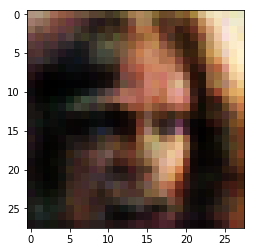

Epoch 1/1... Discriminator Loss: 1.9966... Generator Loss: 0.2158


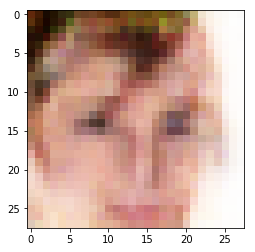

Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.5322


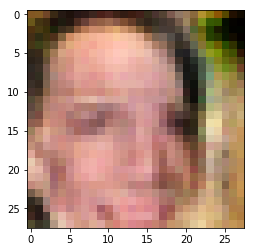

Epoch 1/1... Discriminator Loss: 1.9744... Generator Loss: 0.2067


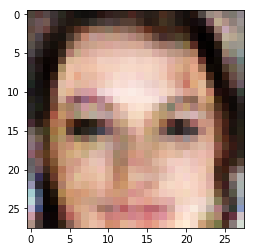

Epoch 1/1... Discriminator Loss: 1.9152... Generator Loss: 0.2620


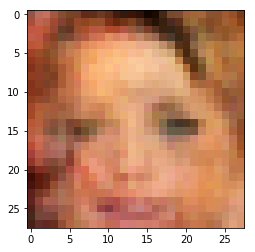

Epoch 1/1... Discriminator Loss: 1.8247... Generator Loss: 0.2334


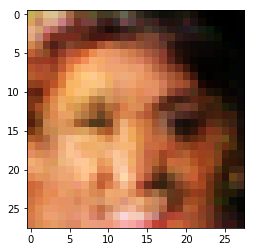

Epoch 1/1... Discriminator Loss: 2.1803... Generator Loss: 0.2025


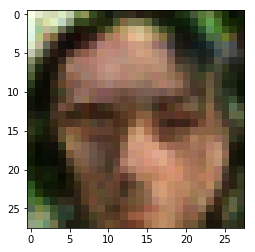

Epoch 1/1... Discriminator Loss: 1.6561... Generator Loss: 0.3731


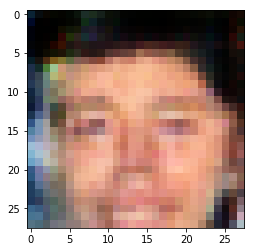

Epoch 1/1... Discriminator Loss: 1.9614... Generator Loss: 0.2192


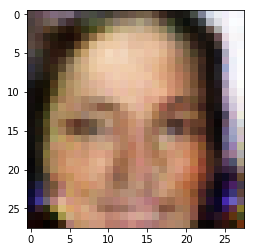

Epoch 1/1... Discriminator Loss: 1.6425... Generator Loss: 0.5767


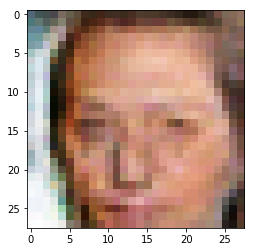

Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.3777


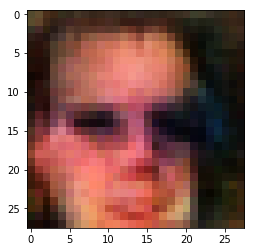

Epoch 1/1... Discriminator Loss: 1.9988... Generator Loss: 0.3095


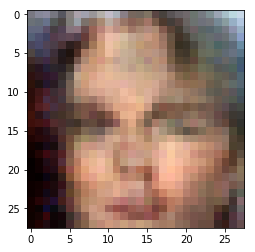

Epoch 1/1... Discriminator Loss: 1.5868... Generator Loss: 0.3780


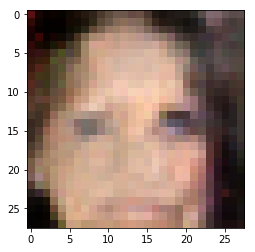

Epoch 1/1... Discriminator Loss: 2.0464... Generator Loss: 0.2787


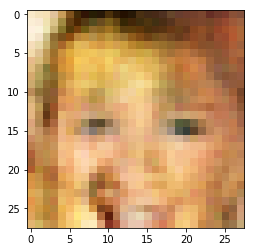

Epoch 1/1... Discriminator Loss: 1.6985... Generator Loss: 0.3321


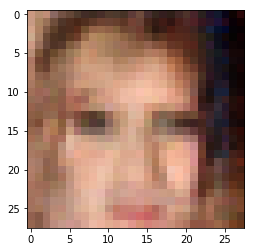

Epoch 1/1... Discriminator Loss: 1.8044... Generator Loss: 0.3762


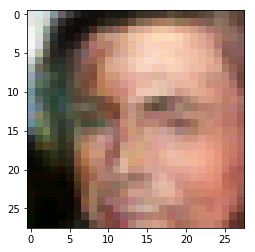

Epoch 1/1... Discriminator Loss: 1.9757... Generator Loss: 0.2617


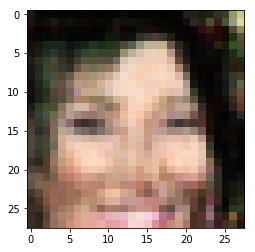

Epoch 1/1... Discriminator Loss: 1.7334... Generator Loss: 0.4169


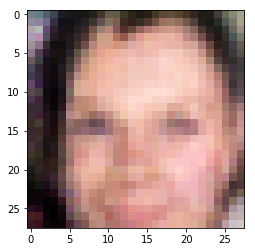

Epoch 1/1... Discriminator Loss: 1.9376... Generator Loss: 0.2420


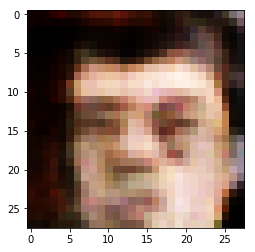

Epoch 1/1... Discriminator Loss: 2.0611... Generator Loss: 0.2858


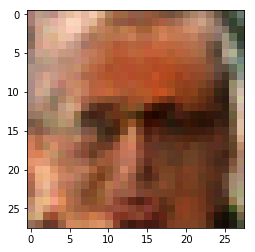

Epoch 1/1... Discriminator Loss: 1.7735... Generator Loss: 0.3810


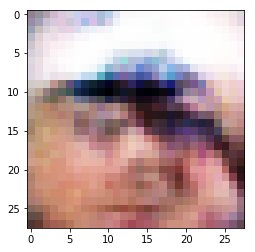

Epoch 1/1... Discriminator Loss: 1.6682... Generator Loss: 0.5672


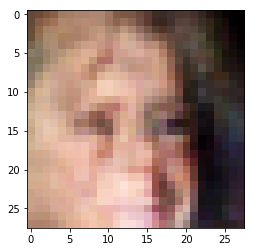

Epoch 1/1... Discriminator Loss: 1.9558... Generator Loss: 0.2719


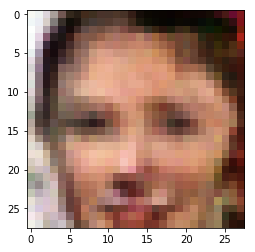

Epoch 1/1... Discriminator Loss: 2.0634... Generator Loss: 0.2167


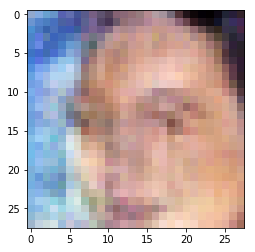

Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.6772


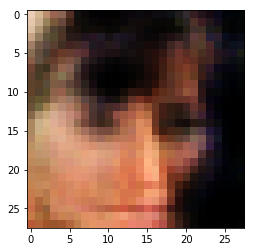

Epoch 1/1... Discriminator Loss: 2.2223... Generator Loss: 0.1802


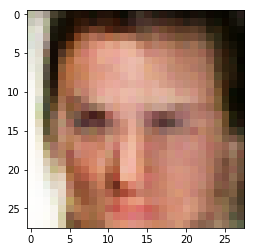

Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.5397


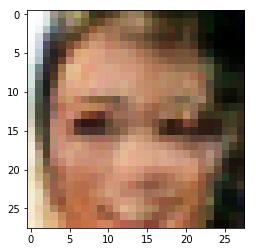

Epoch 1/1... Discriminator Loss: 1.8855... Generator Loss: 0.2657


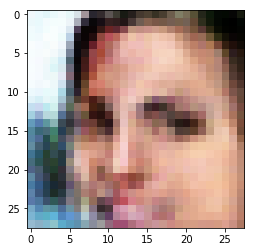

Epoch 1/1... Discriminator Loss: 1.7967... Generator Loss: 0.3379


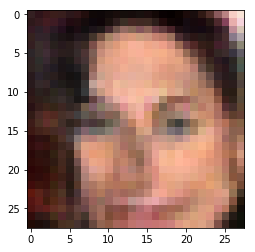

Epoch 1/1... Discriminator Loss: 1.8271... Generator Loss: 0.3129


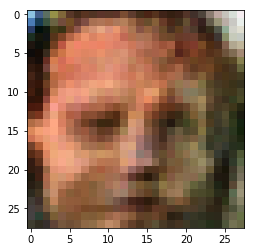

Epoch 1/1... Discriminator Loss: 1.8055... Generator Loss: 0.2846


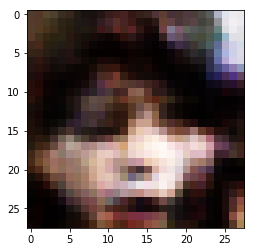

Epoch 1/1... Discriminator Loss: 2.2508... Generator Loss: 0.1965


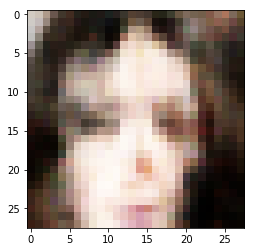

Epoch 1/1... Discriminator Loss: 2.0010... Generator Loss: 0.2402


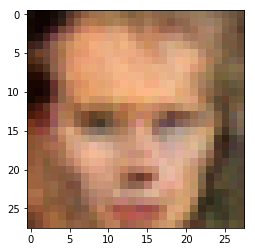

Epoch 1/1... Discriminator Loss: 2.3596... Generator Loss: 0.2391


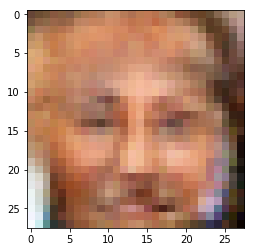

Epoch 1/1... Discriminator Loss: 2.1897... Generator Loss: 0.1454


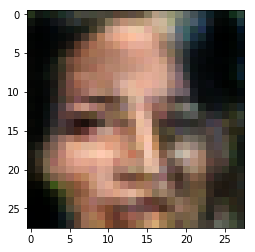

Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.4849


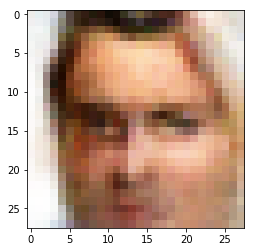

Epoch 1/1... Discriminator Loss: 1.8087... Generator Loss: 0.3369


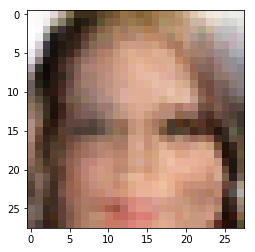

Epoch 1/1... Discriminator Loss: 1.9784... Generator Loss: 0.3753


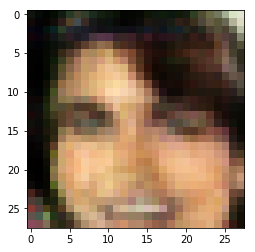

Epoch 1/1... Discriminator Loss: 2.1066... Generator Loss: 0.2426


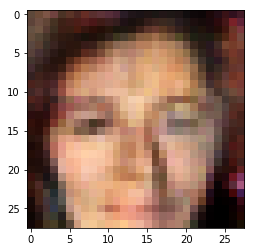

Epoch 1/1... Discriminator Loss: 2.1925... Generator Loss: 0.2559


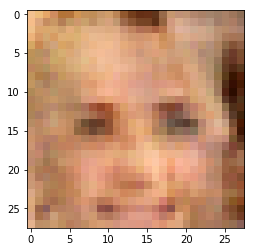

Epoch 1/1... Discriminator Loss: 1.5976... Generator Loss: 0.3696


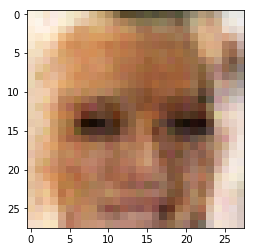

Epoch 1/1... Discriminator Loss: 1.6399... Generator Loss: 0.4828


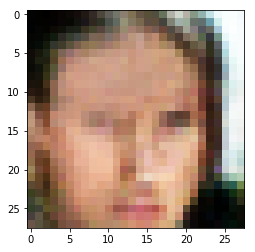

Epoch 1/1... Discriminator Loss: 1.9797... Generator Loss: 0.2097


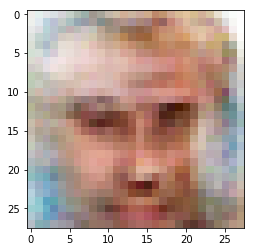

Epoch 1/1... Discriminator Loss: 1.7535... Generator Loss: 0.2991


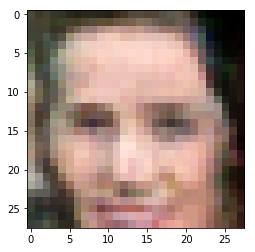

Epoch 1/1... Discriminator Loss: 1.7371... Generator Loss: 0.3160


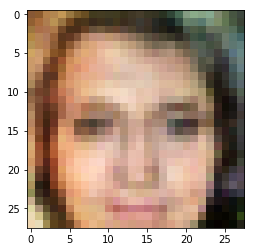

Epoch 1/1... Discriminator Loss: 2.0827... Generator Loss: 0.2043


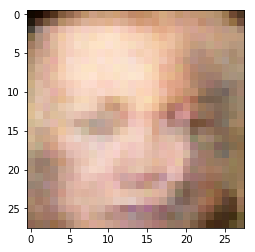

Epoch 1/1... Discriminator Loss: 1.5406... Generator Loss: 0.3987


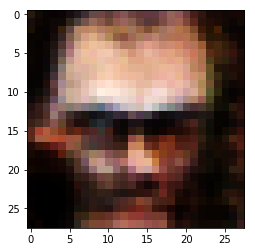

Epoch 1/1... Discriminator Loss: 1.7977... Generator Loss: 0.2773


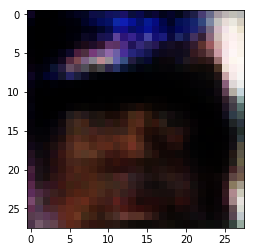

Epoch 1/1... Discriminator Loss: 1.6761... Generator Loss: 0.3744


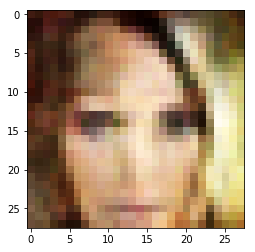

Epoch 1/1... Discriminator Loss: 1.6440... Generator Loss: 0.3727


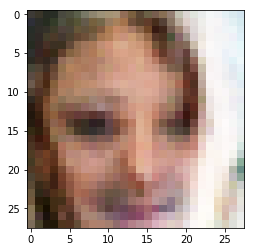

Epoch 1/1... Discriminator Loss: 1.6419... Generator Loss: 0.3304


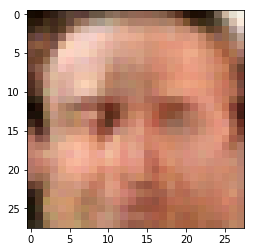

Epoch 1/1... Discriminator Loss: 1.7549... Generator Loss: 0.2817


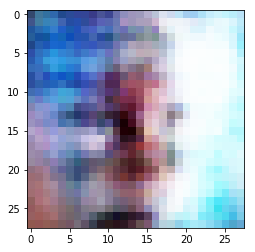

Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.3695


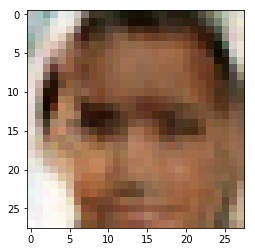

Epoch 1/1... Discriminator Loss: 1.5609... Generator Loss: 0.7036


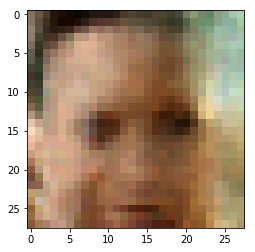

Epoch 1/1... Discriminator Loss: 1.5836... Generator Loss: 0.3422


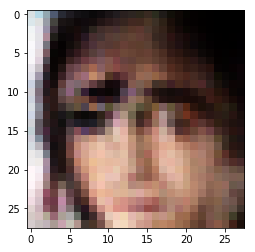

Epoch 1/1... Discriminator Loss: 1.8559... Generator Loss: 0.3776


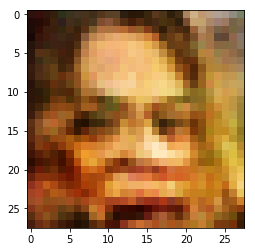

Epoch 1/1... Discriminator Loss: 1.8089... Generator Loss: 0.3180


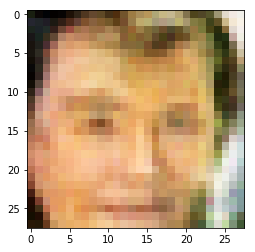

Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.3841


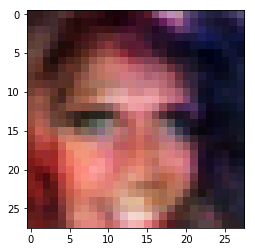

Epoch 1/1... Discriminator Loss: 2.0990... Generator Loss: 0.2864


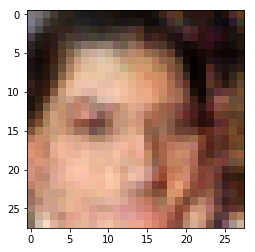

Epoch 1/1... Discriminator Loss: 1.7968... Generator Loss: 0.3004


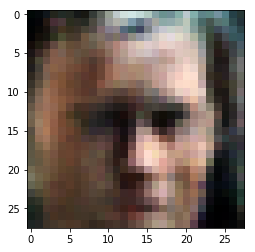

Epoch 1/1... Discriminator Loss: 1.7028... Generator Loss: 0.3495


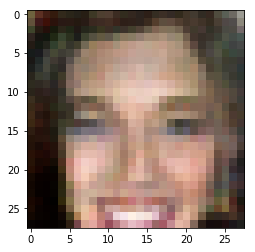

Epoch 1/1... Discriminator Loss: 1.8751... Generator Loss: 0.6986


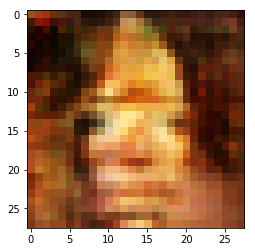

Epoch 1/1... Discriminator Loss: 1.9781... Generator Loss: 0.2764


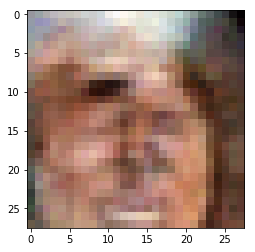

Epoch 1/1... Discriminator Loss: 1.7495... Generator Loss: 0.3679


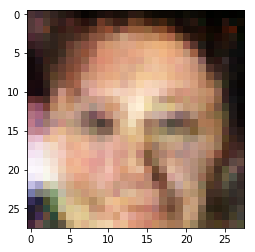

Epoch 1/1... Discriminator Loss: 1.6413... Generator Loss: 0.4689


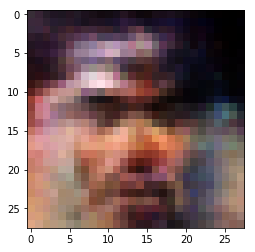

Epoch 1/1... Discriminator Loss: 1.8206... Generator Loss: 0.3225


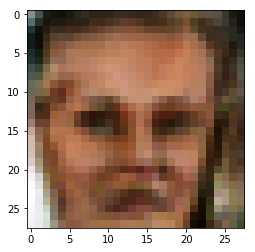

Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.3618


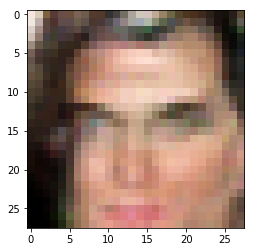

Epoch 1/1... Discriminator Loss: 1.6881... Generator Loss: 0.3709


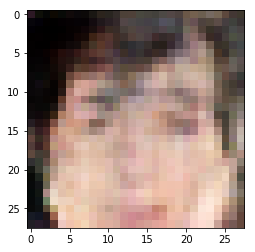

Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.3625


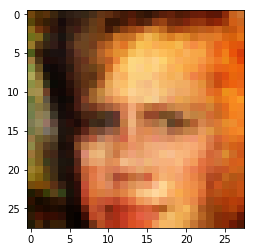

Epoch 1/1... Discriminator Loss: 1.5712... Generator Loss: 0.5390


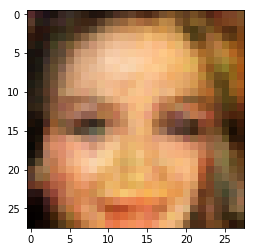

Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.5651


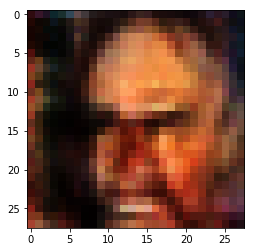

Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.4010


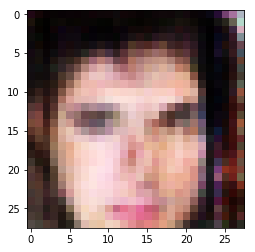

Epoch 1/1... Discriminator Loss: 1.8283... Generator Loss: 0.3303


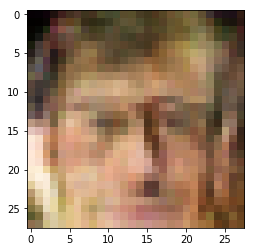

Epoch 1/1... Discriminator Loss: 1.7779... Generator Loss: 0.3780


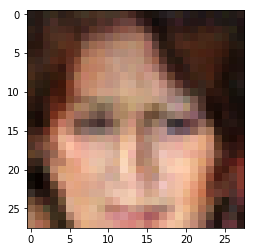

Epoch 1/1... Discriminator Loss: 1.7693... Generator Loss: 0.3319


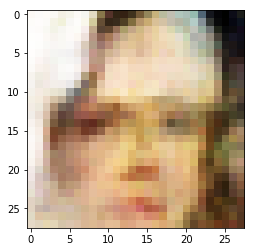

Epoch 1/1... Discriminator Loss: 1.8828... Generator Loss: 0.2720


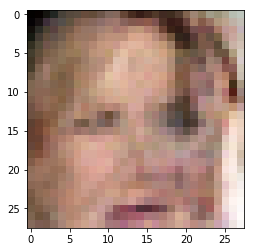

Epoch 1/1... Discriminator Loss: 1.7216... Generator Loss: 0.4853


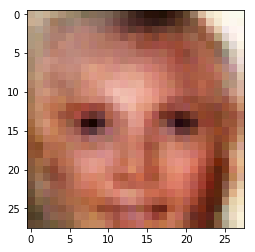

Epoch 1/1... Discriminator Loss: 1.7841... Generator Loss: 0.2500


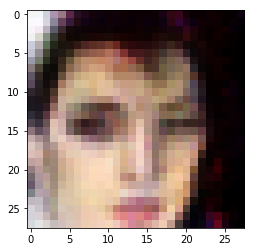

Epoch 1/1... Discriminator Loss: 1.6263... Generator Loss: 0.4311


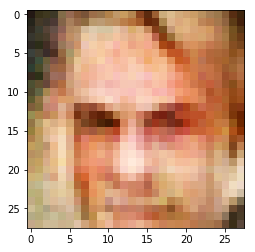

Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.5642


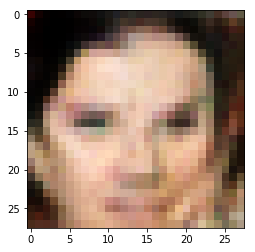

Epoch 1/1... Discriminator Loss: 1.7419... Generator Loss: 0.3050


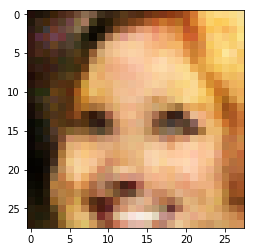

Epoch 1/1... Discriminator Loss: 1.7447... Generator Loss: 0.3437


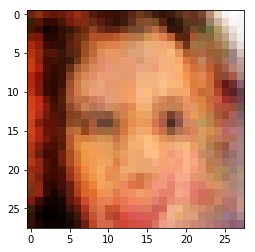

Epoch 1/1... Discriminator Loss: 1.7591... Generator Loss: 0.3661


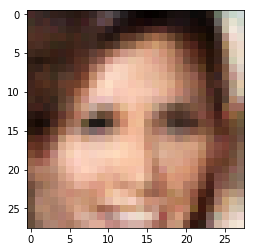

Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 0.5000


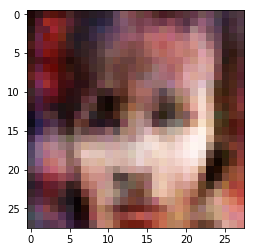

Epoch 1/1... Discriminator Loss: 1.6697... Generator Loss: 0.4635


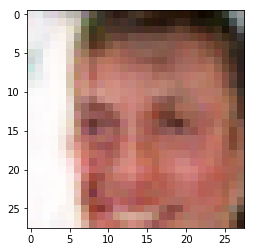

Epoch 1/1... Discriminator Loss: 2.0273... Generator Loss: 0.2062


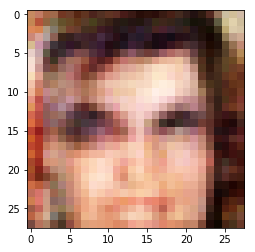

Epoch 1/1... Discriminator Loss: 1.9023... Generator Loss: 0.2669


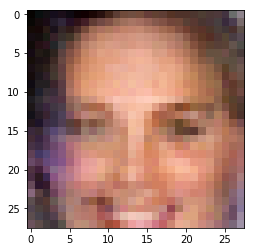

Epoch 1/1... Discriminator Loss: 2.0451... Generator Loss: 0.2587


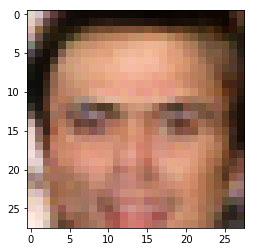

Epoch 1/1... Discriminator Loss: 1.8058... Generator Loss: 0.3006


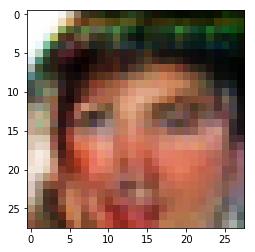

Epoch 1/1... Discriminator Loss: 1.7324... Generator Loss: 0.3371


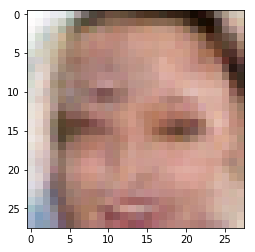

Epoch 1/1... Discriminator Loss: 1.8378... Generator Loss: 0.2793


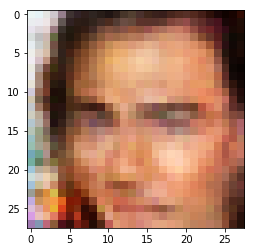

Epoch 1/1... Discriminator Loss: 1.5979... Generator Loss: 0.4223


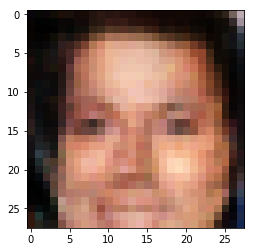

Epoch 1/1... Discriminator Loss: 1.6304... Generator Loss: 0.4305


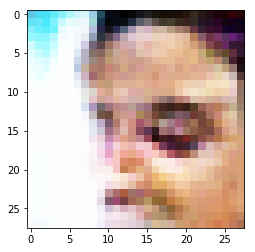

Epoch 1/1... Discriminator Loss: 1.9472... Generator Loss: 0.3049


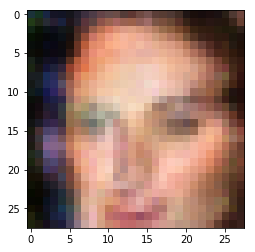

Epoch 1/1... Discriminator Loss: 1.8580... Generator Loss: 0.2643


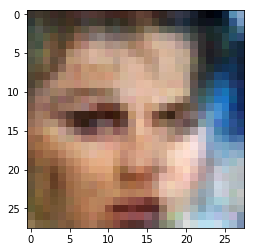

Epoch 1/1... Discriminator Loss: 2.0882... Generator Loss: 0.2428


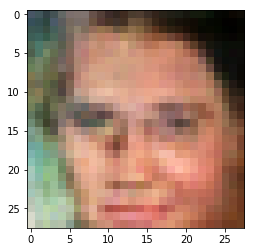

Epoch 1/1... Discriminator Loss: 1.8132... Generator Loss: 0.2727


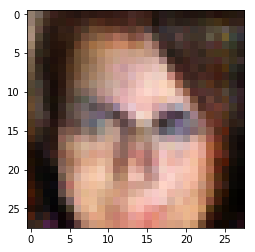

Epoch 1/1... Discriminator Loss: 1.7581... Generator Loss: 0.4545


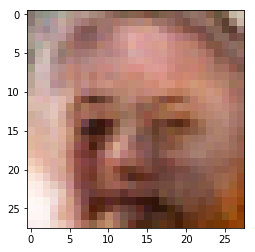

Epoch 1/1... Discriminator Loss: 1.9240... Generator Loss: 0.2288


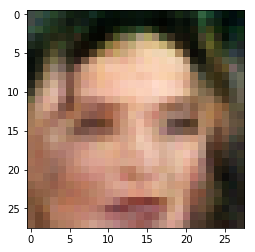

Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.5461


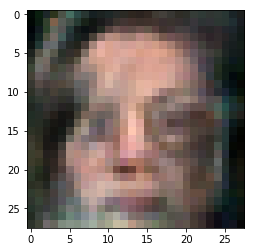

Epoch 1/1... Discriminator Loss: 1.7933... Generator Loss: 0.4521


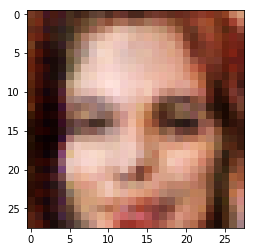

Epoch 1/1... Discriminator Loss: 1.8200... Generator Loss: 0.2726


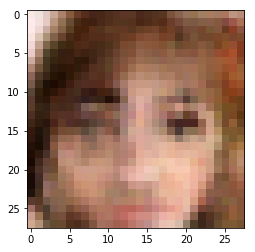

Epoch 1/1... Discriminator Loss: 2.0455... Generator Loss: 0.1961


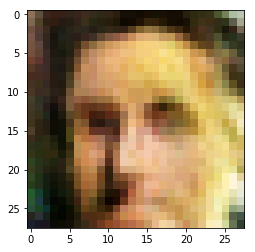

Epoch 1/1... Discriminator Loss: 2.2429... Generator Loss: 0.2489


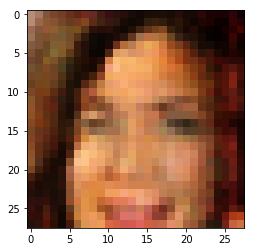

Epoch 1/1... Discriminator Loss: 1.6117... Generator Loss: 0.3871


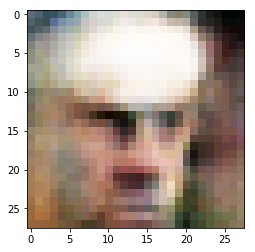

Epoch 1/1... Discriminator Loss: 1.8149... Generator Loss: 0.4082


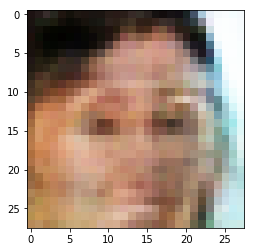

Epoch 1/1... Discriminator Loss: 1.7849... Generator Loss: 0.3359


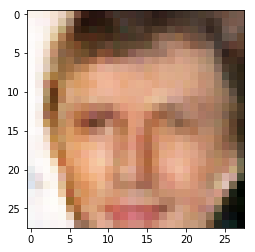

Epoch 1/1... Discriminator Loss: 2.0408... Generator Loss: 0.1733


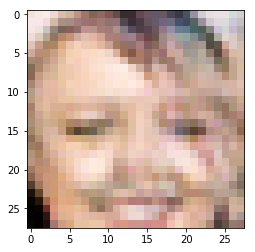

Epoch 1/1... Discriminator Loss: 1.6659... Generator Loss: 0.3436


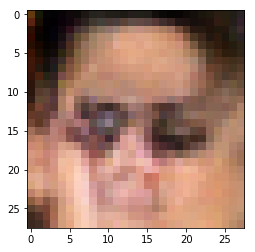

Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.5650


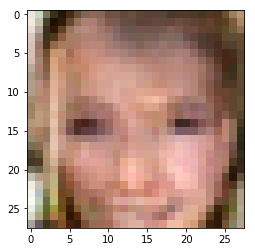

Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.4569


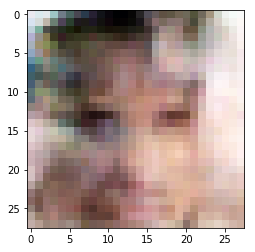

Epoch 1/1... Discriminator Loss: 1.6600... Generator Loss: 0.3609


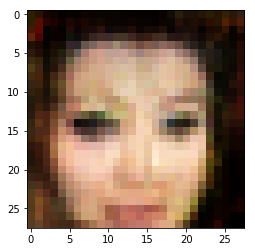

Epoch 1/1... Discriminator Loss: 1.9557... Generator Loss: 0.2836


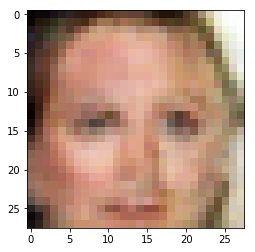

Epoch 1/1... Discriminator Loss: 1.6317... Generator Loss: 0.3167


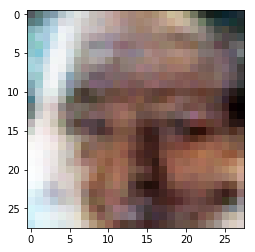

Epoch 1/1... Discriminator Loss: 1.6998... Generator Loss: 0.7269


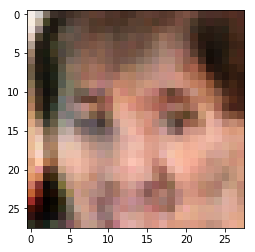

Epoch 1/1... Discriminator Loss: 2.1776... Generator Loss: 0.2113


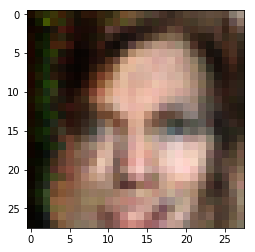

Epoch 1/1... Discriminator Loss: 2.0058... Generator Loss: 0.2251


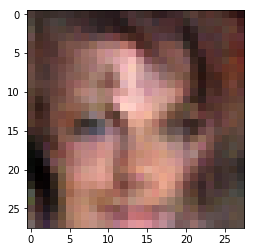

Epoch 1/1... Discriminator Loss: 1.6419... Generator Loss: 0.4439


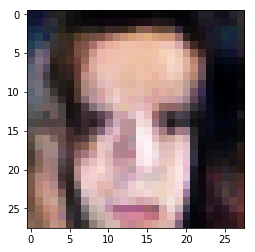

Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 0.4725


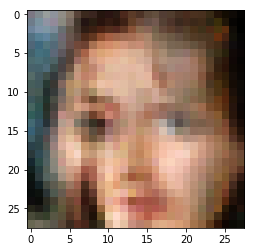

Epoch 1/1... Discriminator Loss: 1.7982... Generator Loss: 0.3567


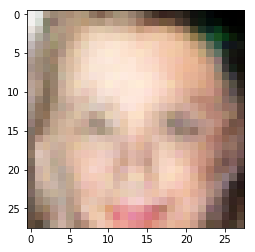

Epoch 1/1... Discriminator Loss: 1.8494... Generator Loss: 0.3223


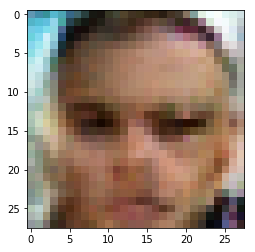

Epoch 1/1... Discriminator Loss: 2.0113... Generator Loss: 0.2469


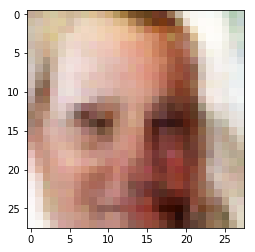

Epoch 1/1... Discriminator Loss: 1.8360... Generator Loss: 0.4404


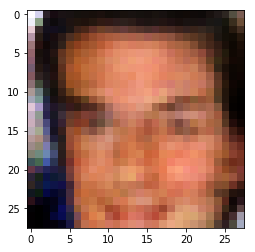

Epoch 1/1... Discriminator Loss: 1.8050... Generator Loss: 0.4573


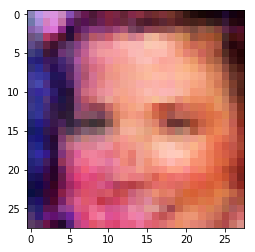

Epoch 1/1... Discriminator Loss: 1.6889... Generator Loss: 0.2816


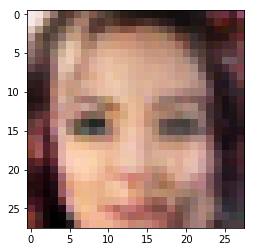

Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.6665


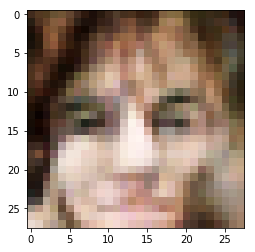

Epoch 1/1... Discriminator Loss: 1.6803... Generator Loss: 0.4072


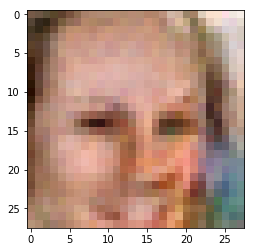

Epoch 1/1... Discriminator Loss: 1.9226... Generator Loss: 0.2931


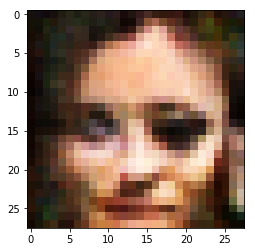

Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 0.6297


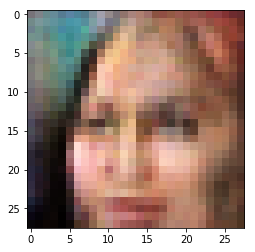

Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.5323


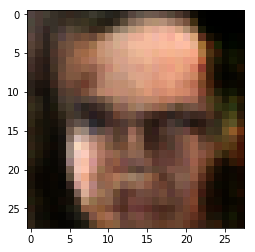

Epoch 1/1... Discriminator Loss: 1.8393... Generator Loss: 0.3254


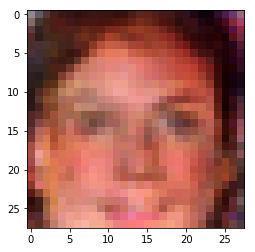

Epoch 1/1... Discriminator Loss: 1.8116... Generator Loss: 0.3812


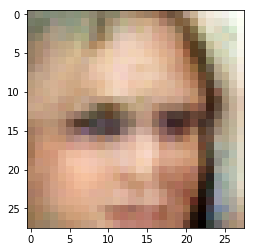

Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 0.4984


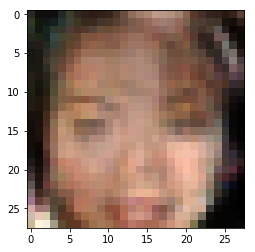

Epoch 1/1... Discriminator Loss: 1.6634... Generator Loss: 0.3401


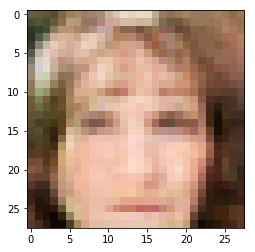

Epoch 1/1... Discriminator Loss: 1.9869... Generator Loss: 0.3307


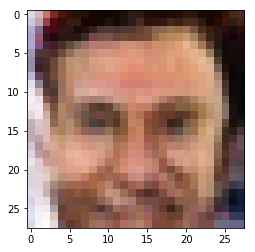

Epoch 1/1... Discriminator Loss: 1.7815... Generator Loss: 0.3317


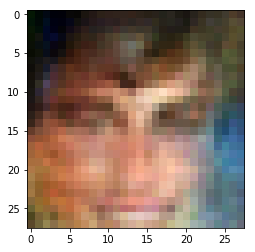

Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.5040


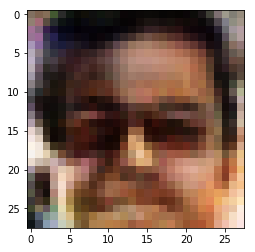

Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.3906


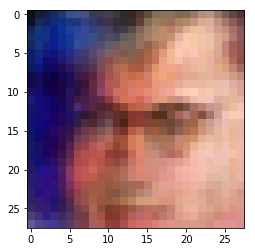

Epoch 1/1... Discriminator Loss: 1.7757... Generator Loss: 0.5912


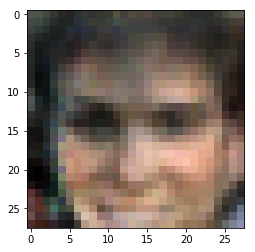

Epoch 1/1... Discriminator Loss: 1.7438... Generator Loss: 0.3590


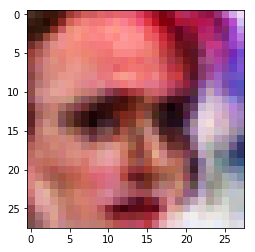

Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.5273


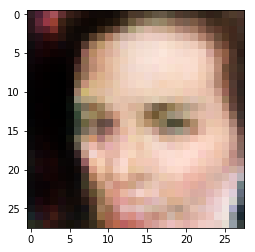

Epoch 1/1... Discriminator Loss: 1.8979... Generator Loss: 0.2441


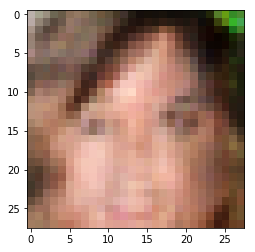

Epoch 1/1... Discriminator Loss: 1.7709... Generator Loss: 0.3235


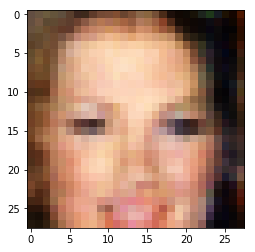

Epoch 1/1... Discriminator Loss: 1.8062... Generator Loss: 0.3269


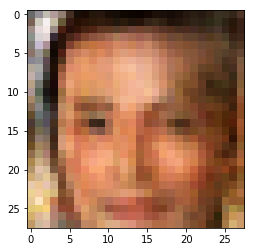

Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.4273


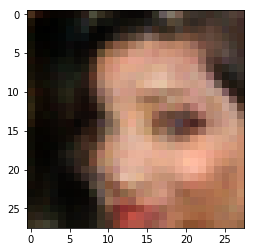

Epoch 1/1... Discriminator Loss: 1.9160... Generator Loss: 0.3354


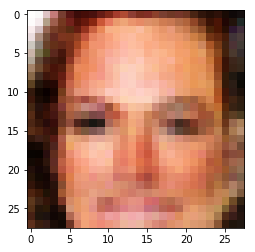

Epoch 1/1... Discriminator Loss: 1.6890... Generator Loss: 0.3967


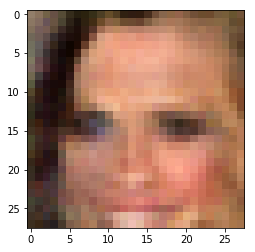

Epoch 1/1... Discriminator Loss: 1.6876... Generator Loss: 0.3507


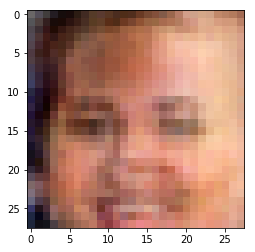

Epoch 1/1... Discriminator Loss: 1.5740... Generator Loss: 0.3505


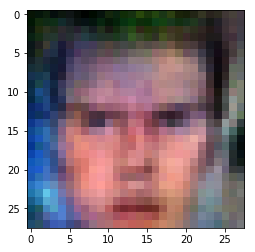

Epoch 1/1... Discriminator Loss: 1.7802... Generator Loss: 0.3517


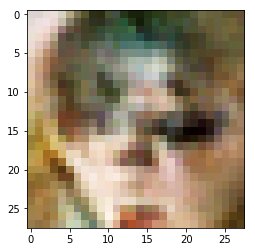

Epoch 1/1... Discriminator Loss: 1.8544... Generator Loss: 0.2581


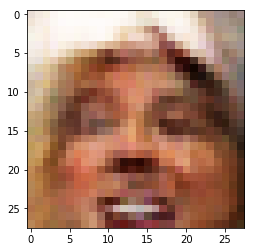

Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.5582


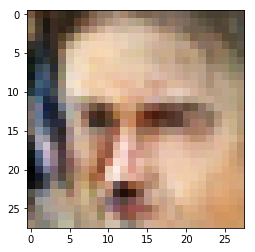

Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.5218


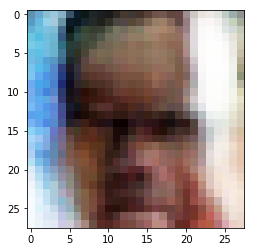

Epoch 1/1... Discriminator Loss: 1.7626... Generator Loss: 0.4125


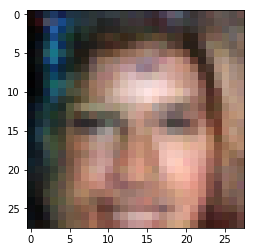

Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.5757


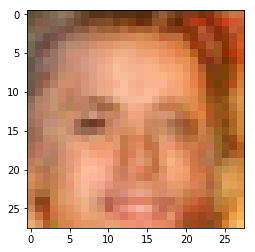

Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.4931


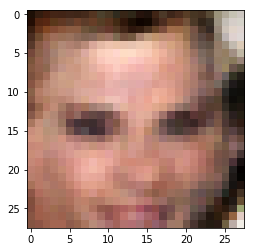

Epoch 1/1... Discriminator Loss: 1.8928... Generator Loss: 0.2611


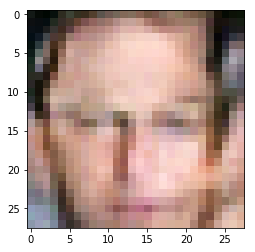

Epoch 1/1... Discriminator Loss: 1.9780... Generator Loss: 0.2388


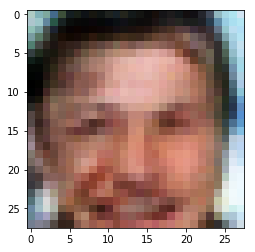

Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.3312


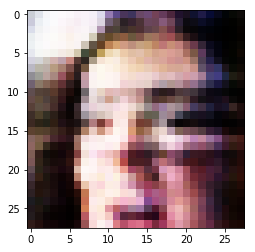

Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.6576


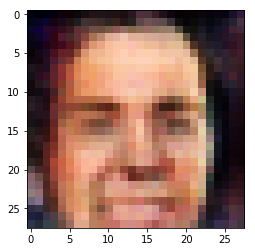

Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.4324


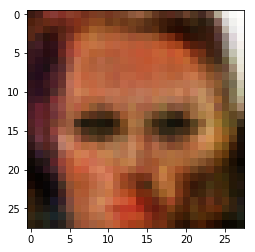

Epoch 1/1... Discriminator Loss: 1.7597... Generator Loss: 0.5035


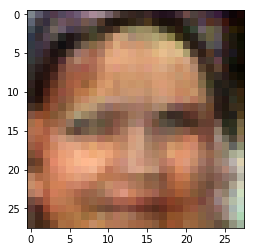

Epoch 1/1... Discriminator Loss: 1.7921... Generator Loss: 0.2714


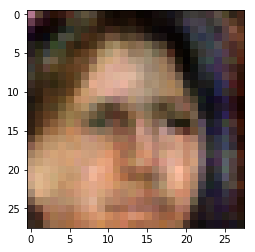

Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.5733


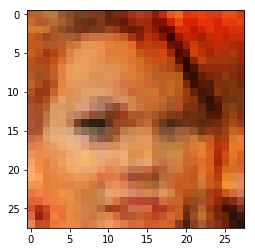

Epoch 1/1... Discriminator Loss: 1.8022... Generator Loss: 0.3507


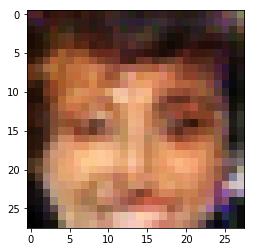

Epoch 1/1... Discriminator Loss: 1.7777... Generator Loss: 0.2810


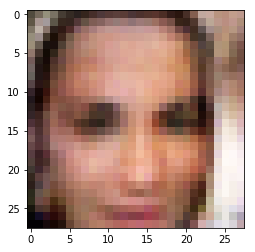

Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.5419


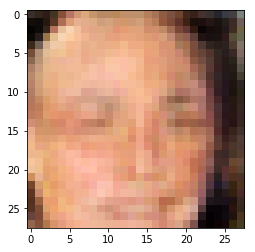

Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.8764


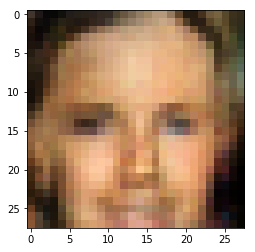

Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.5717


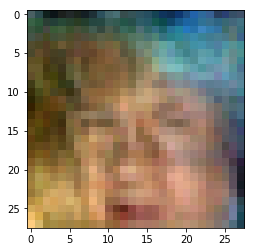

Epoch 1/1... Discriminator Loss: 1.7169... Generator Loss: 0.3747


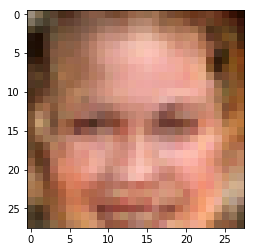

Epoch 1/1... Discriminator Loss: 1.6780... Generator Loss: 0.3601


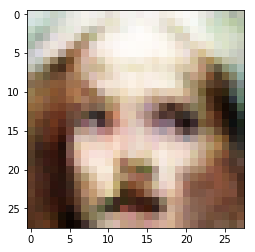

Epoch 1/1... Discriminator Loss: 1.5755... Generator Loss: 0.4141


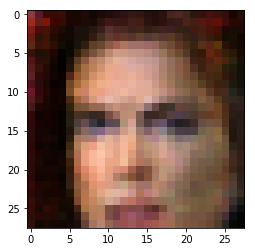

Epoch 1/1... Discriminator Loss: 1.6667... Generator Loss: 0.4502


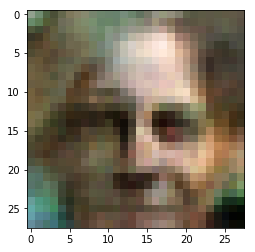

Epoch 1/1... Discriminator Loss: 1.5745... Generator Loss: 0.6077


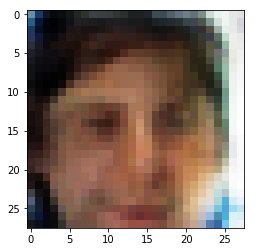

Epoch 1/1... Discriminator Loss: 1.8540... Generator Loss: 0.2646


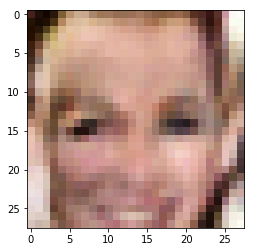

Epoch 1/1... Discriminator Loss: 1.7676... Generator Loss: 0.3857


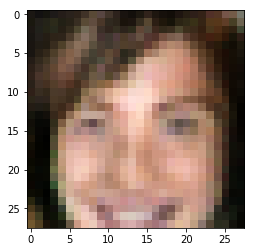

Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.6088


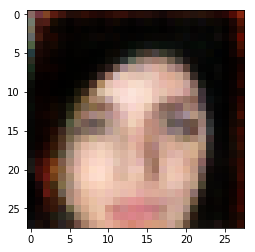

Epoch 1/1... Discriminator Loss: 1.6169... Generator Loss: 0.5764


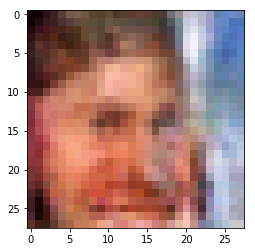

Epoch 1/1... Discriminator Loss: 1.5640... Generator Loss: 0.5221


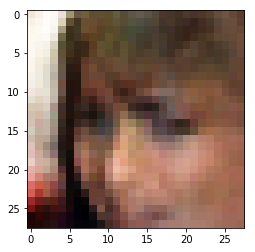

Epoch 1/1... Discriminator Loss: 1.5465... Generator Loss: 0.4758


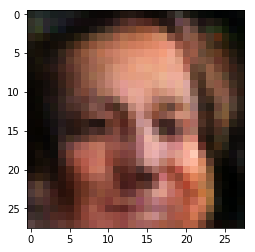

Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.4138


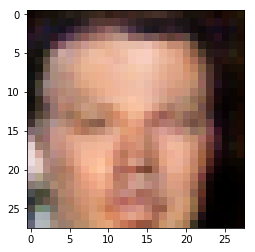

Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.5441


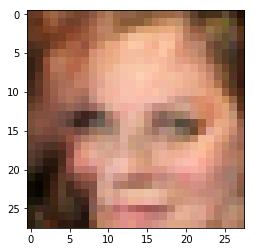

Epoch 1/1... Discriminator Loss: 1.7703... Generator Loss: 0.2833


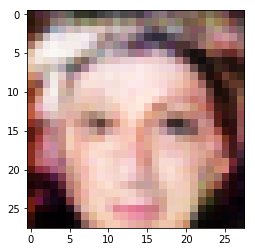

Epoch 1/1... Discriminator Loss: 1.6182... Generator Loss: 0.5760


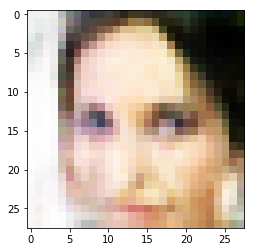

Epoch 1/1... Discriminator Loss: 1.6289... Generator Loss: 0.5579


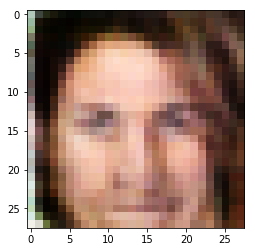

Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.4197


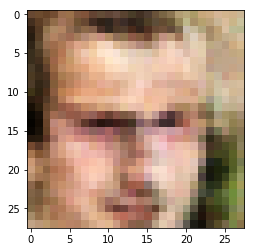

Epoch 1/1... Discriminator Loss: 1.8216... Generator Loss: 0.3708


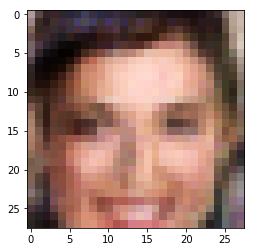

Epoch 1/1... Discriminator Loss: 1.5723... Generator Loss: 0.4135


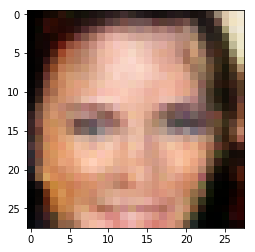

Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.5741


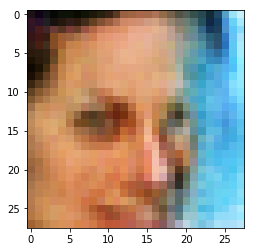

Epoch 1/1... Discriminator Loss: 1.6785... Generator Loss: 0.3441


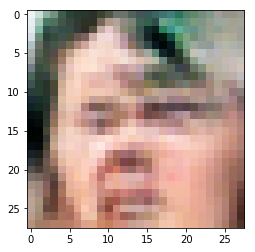

Epoch 1/1... Discriminator Loss: 1.9131... Generator Loss: 0.2423


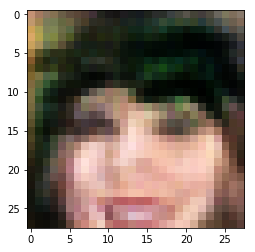

Epoch 1/1... Discriminator Loss: 1.8149... Generator Loss: 0.2688


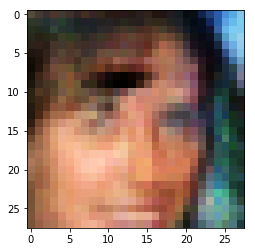

Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.6173


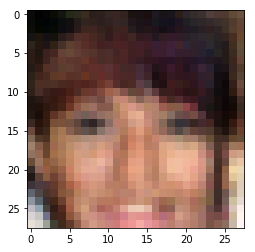

Epoch 1/1... Discriminator Loss: 1.6947... Generator Loss: 0.3662


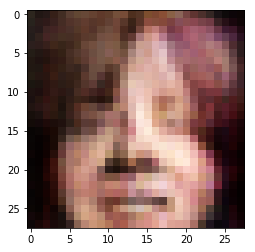

Epoch 1/1... Discriminator Loss: 1.5999... Generator Loss: 0.3496


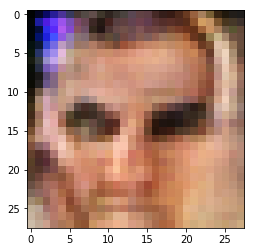

Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.4301


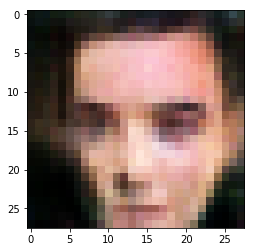

Epoch 1/1... Discriminator Loss: 1.6153... Generator Loss: 0.5264


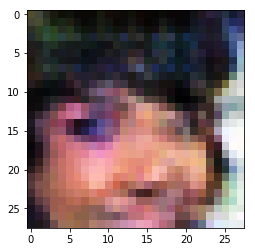

Epoch 1/1... Discriminator Loss: 1.6892... Generator Loss: 0.3154


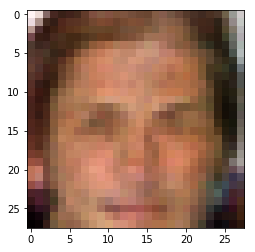

Epoch 1/1... Discriminator Loss: 1.7069... Generator Loss: 0.3272


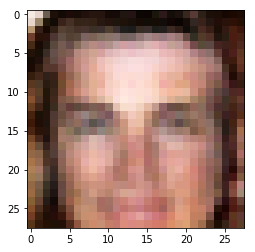

Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 0.4967


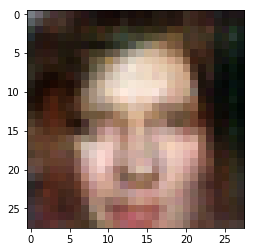

Epoch 1/1... Discriminator Loss: 1.5643... Generator Loss: 0.3914


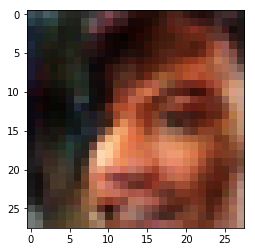

Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.4470


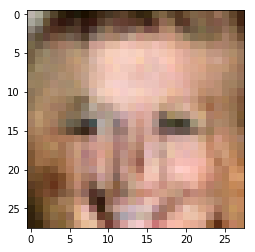

Epoch 1/1... Discriminator Loss: 1.6643... Generator Loss: 0.4067


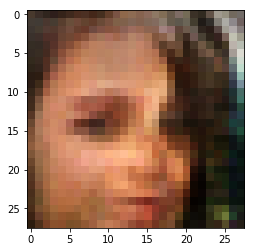

Epoch 1/1... Discriminator Loss: 1.9372... Generator Loss: 0.4382


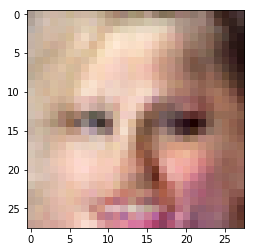

Epoch 1/1... Discriminator Loss: 1.9741... Generator Loss: 0.2440


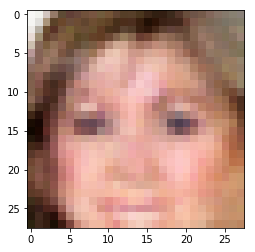

Epoch 1/1... Discriminator Loss: 1.9602... Generator Loss: 0.2208


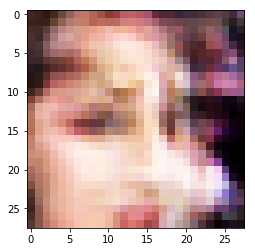

Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6324


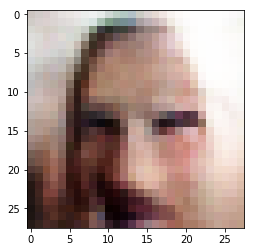

Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.4501


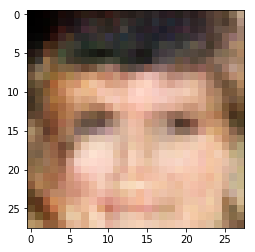

Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.5232


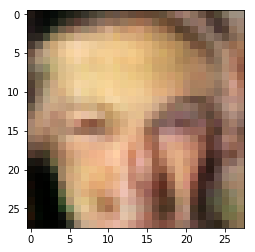

Epoch 1/1... Discriminator Loss: 1.8657... Generator Loss: 0.2306


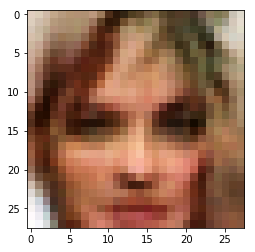

Epoch 1/1... Discriminator Loss: 1.7228... Generator Loss: 0.3330


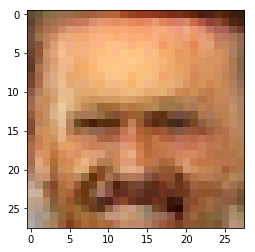

Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.5692


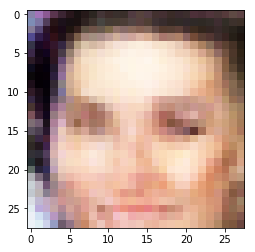

Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.4740


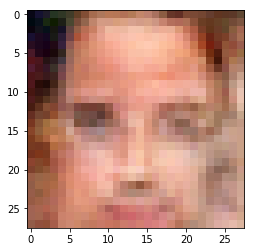

Epoch 1/1... Discriminator Loss: 1.7299... Generator Loss: 0.5585


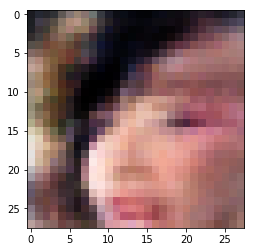

Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.5517


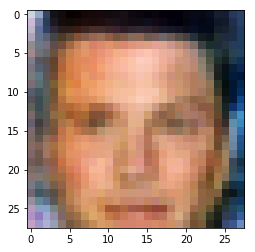

Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.4229


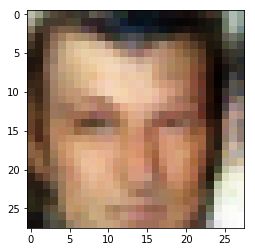

Epoch 1/1... Discriminator Loss: 1.8790... Generator Loss: 0.2345


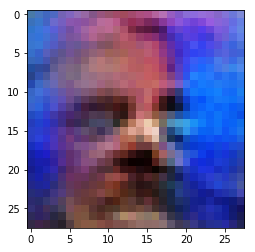

Epoch 1/1... Discriminator Loss: 1.9192... Generator Loss: 0.3402


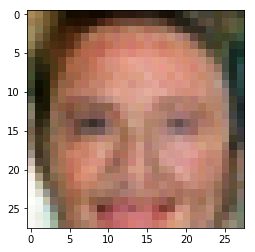

Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.3881


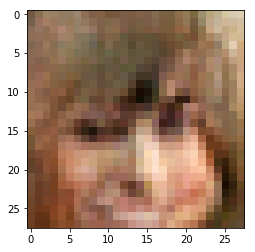

Epoch 1/1... Discriminator Loss: 1.6422... Generator Loss: 0.4196


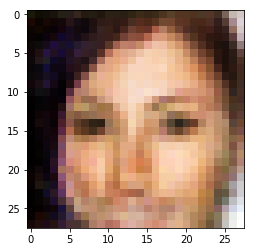

Epoch 1/1... Discriminator Loss: 1.8662... Generator Loss: 0.2993


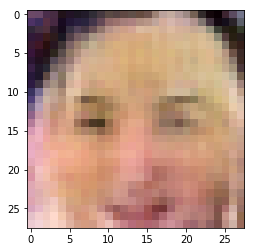

Epoch 1/1... Discriminator Loss: 1.7079... Generator Loss: 0.3274


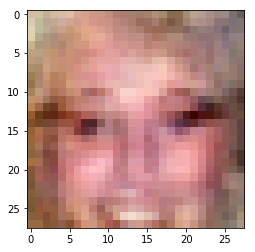

Epoch 1/1... Discriminator Loss: 1.8442... Generator Loss: 0.2972


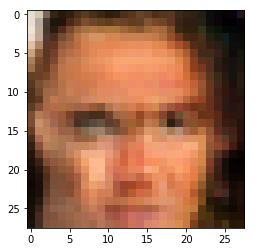

Epoch 1/1... Discriminator Loss: 1.6765... Generator Loss: 0.3742


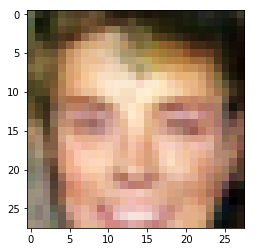

Epoch 1/1... Discriminator Loss: 1.8373... Generator Loss: 0.2623


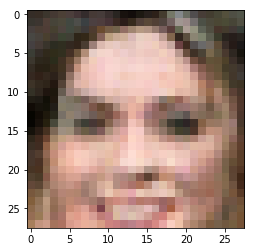

Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.4574


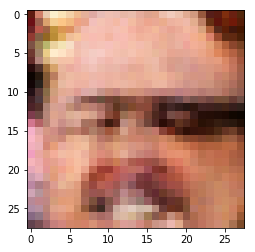

Epoch 1/1... Discriminator Loss: 1.6579... Generator Loss: 0.3368


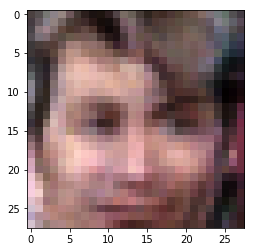

Epoch 1/1... Discriminator Loss: 1.5987... Generator Loss: 0.4275


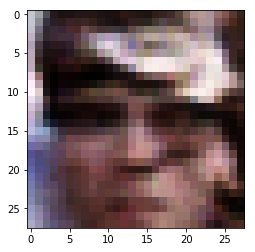

Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.4124


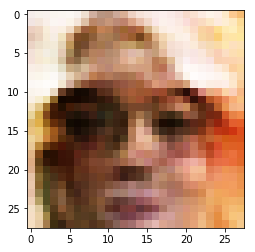

Epoch 1/1... Discriminator Loss: 1.5368... Generator Loss: 0.4704


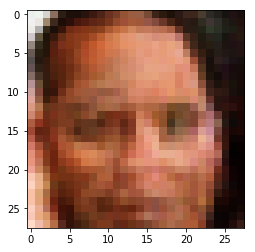

Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.5578


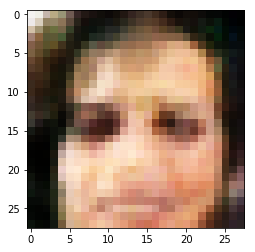

Epoch 1/1... Discriminator Loss: 1.9788... Generator Loss: 0.2840


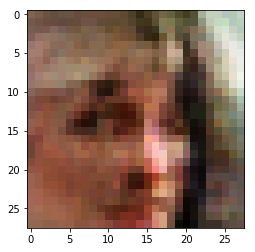

Epoch 1/1... Discriminator Loss: 1.8036... Generator Loss: 0.3218


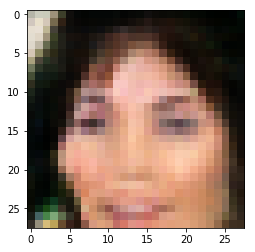

Epoch 1/1... Discriminator Loss: 1.5784... Generator Loss: 0.5585


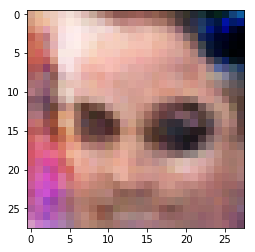

Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.4659


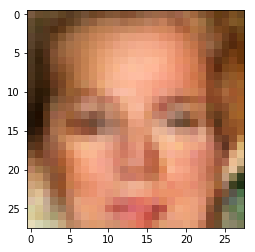

Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.6198


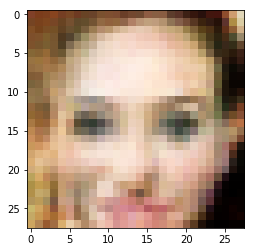

Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 0.4748


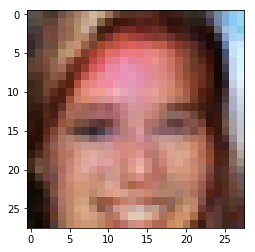

Epoch 1/1... Discriminator Loss: 1.5627... Generator Loss: 0.4966


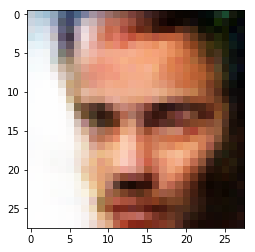

Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.4356


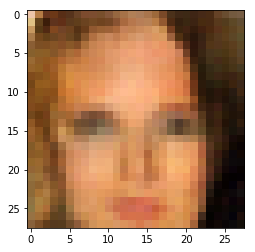

Epoch 1/1... Discriminator Loss: 1.6885... Generator Loss: 0.3917


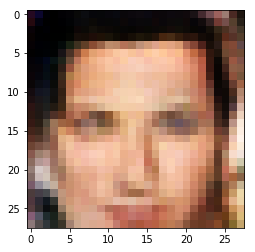

Epoch 1/1... Discriminator Loss: 1.6218... Generator Loss: 0.4018


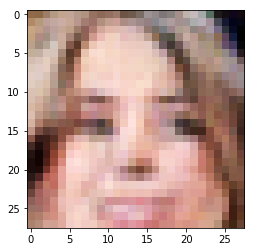

Epoch 1/1... Discriminator Loss: 1.6586... Generator Loss: 0.3634


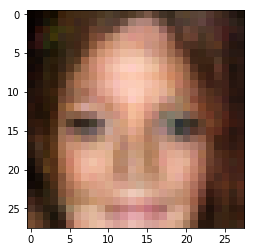

Epoch 1/1... Discriminator Loss: 1.5447... Generator Loss: 0.4502


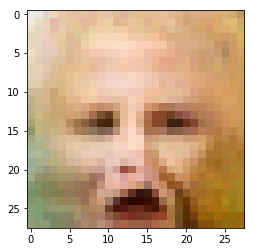

Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.6780


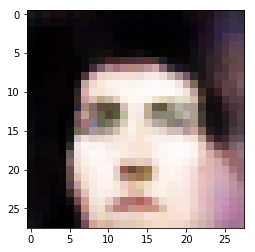

Epoch 1/1... Discriminator Loss: 1.5723... Generator Loss: 0.3361


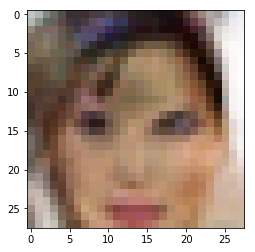

Epoch 1/1... Discriminator Loss: 1.6151... Generator Loss: 0.4163


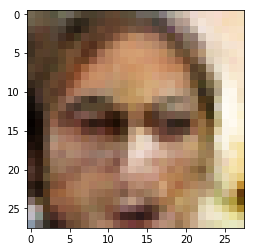

Epoch 1/1... Discriminator Loss: 1.9970... Generator Loss: 0.2090


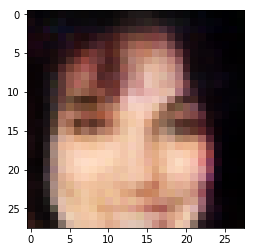

Epoch 1/1... Discriminator Loss: 1.7374... Generator Loss: 0.3007


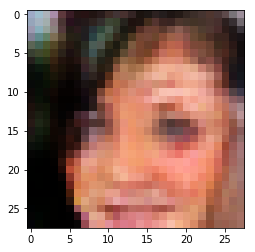

Epoch 1/1... Discriminator Loss: 1.7325... Generator Loss: 0.3366


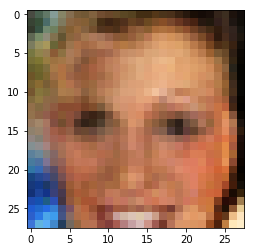

Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.5694


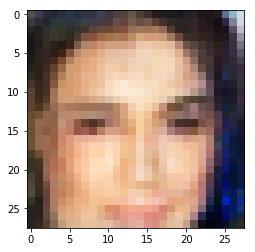

Epoch 1/1... Discriminator Loss: 1.6238... Generator Loss: 0.3964


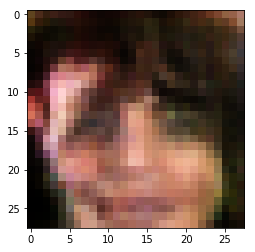

Epoch 1/1... Discriminator Loss: 1.8453... Generator Loss: 0.3556


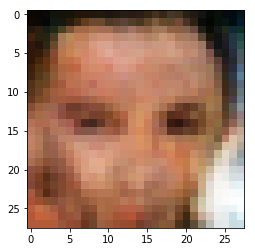

Epoch 1/1... Discriminator Loss: 1.7098... Generator Loss: 0.4878


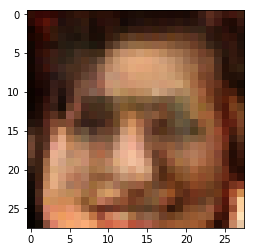

Epoch 1/1... Discriminator Loss: 1.5985... Generator Loss: 0.4125


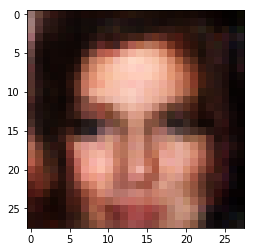

Epoch 1/1... Discriminator Loss: 1.8059... Generator Loss: 0.3351


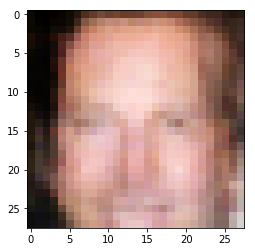

Epoch 1/1... Discriminator Loss: 1.7747... Generator Loss: 0.3002


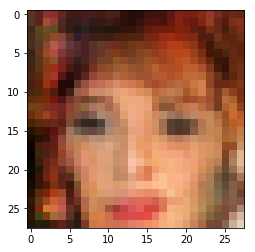

Epoch 1/1... Discriminator Loss: 1.6097... Generator Loss: 0.3458


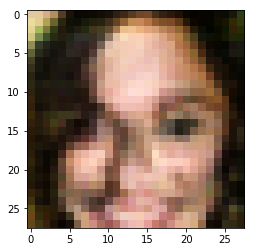

Epoch 1/1... Discriminator Loss: 1.8429... Generator Loss: 0.3342


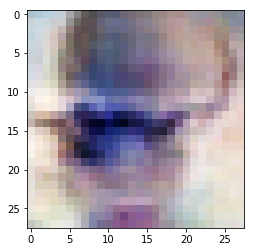

Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 0.4482


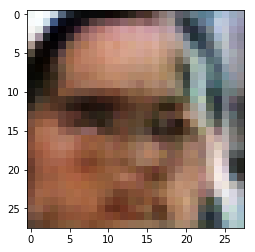

Epoch 1/1... Discriminator Loss: 2.3664... Generator Loss: 0.2018


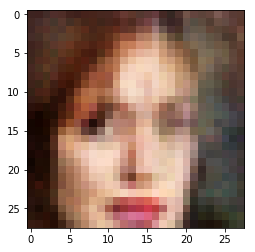

Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.5091


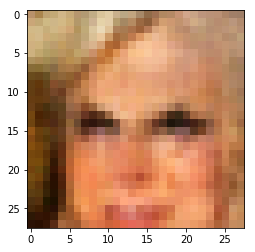

Epoch 1/1... Discriminator Loss: 1.7007... Generator Loss: 0.4658


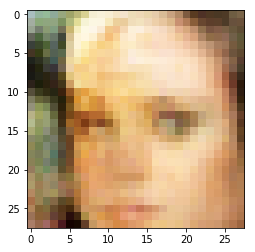

Epoch 1/1... Discriminator Loss: 1.6161... Generator Loss: 0.9746


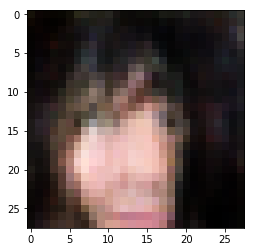

Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.5006


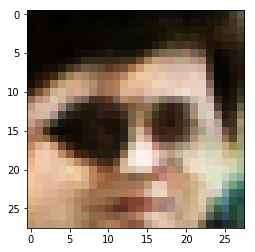

Epoch 1/1... Discriminator Loss: 1.8223... Generator Loss: 0.2868


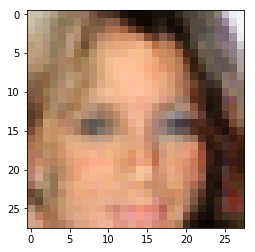

Epoch 1/1... Discriminator Loss: 1.6909... Generator Loss: 0.4198


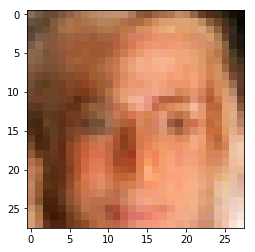

Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.5646


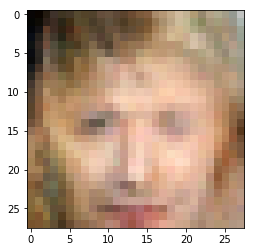

Epoch 1/1... Discriminator Loss: 1.7904... Generator Loss: 0.2648


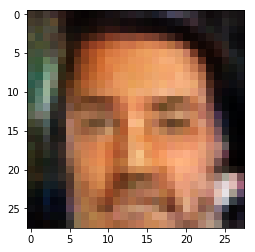

Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.5806


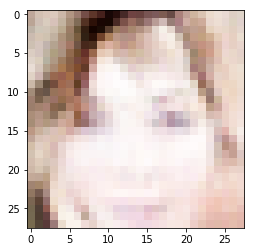

Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.5718


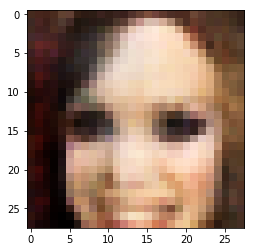

Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.6108


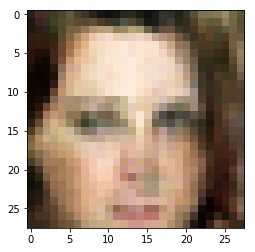

Epoch 1/1... Discriminator Loss: 1.8483... Generator Loss: 0.3316


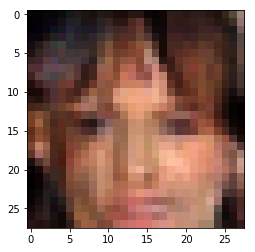

Epoch 1/1... Discriminator Loss: 1.8064... Generator Loss: 0.2828


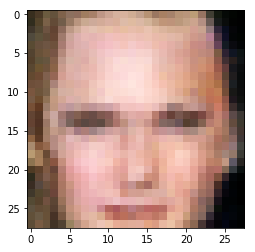

Epoch 1/1... Discriminator Loss: 1.7286... Generator Loss: 0.3460


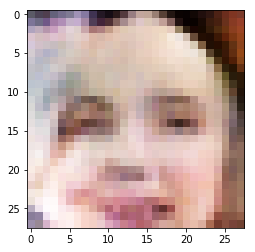

Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.3742


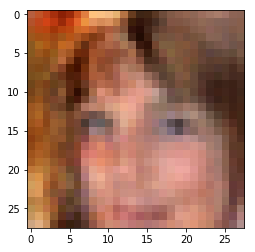

Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.5892


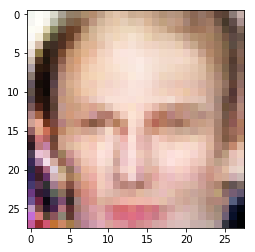

Epoch 1/1... Discriminator Loss: 1.8869... Generator Loss: 0.2645


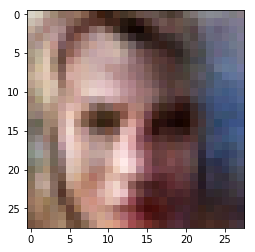

Epoch 1/1... Discriminator Loss: 1.7150... Generator Loss: 0.4264


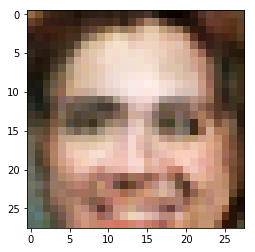

Epoch 1/1... Discriminator Loss: 1.6366... Generator Loss: 0.3380


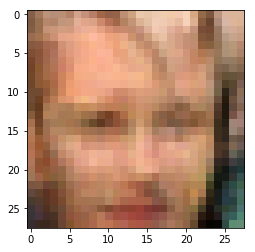

Epoch 1/1... Discriminator Loss: 1.7179... Generator Loss: 0.3274


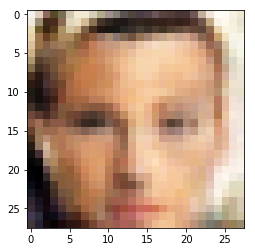

Epoch 1/1... Discriminator Loss: 1.9110... Generator Loss: 0.2279


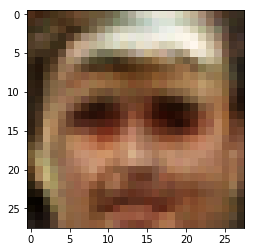

Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.5951


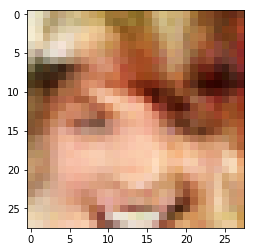

Epoch 1/1... Discriminator Loss: 1.6628... Generator Loss: 0.3715


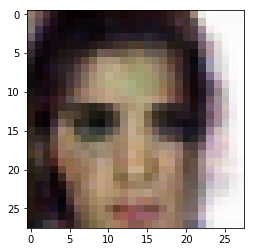

Epoch 1/1... Discriminator Loss: 1.7588... Generator Loss: 0.3662


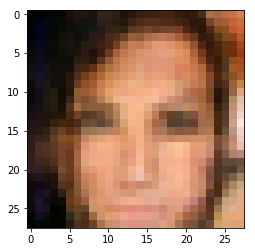

Epoch 1/1... Discriminator Loss: 1.6317... Generator Loss: 0.3532


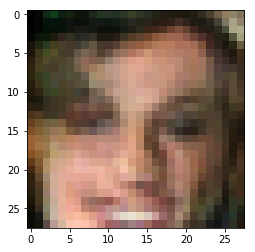

Epoch 1/1... Discriminator Loss: 1.7604... Generator Loss: 0.3286


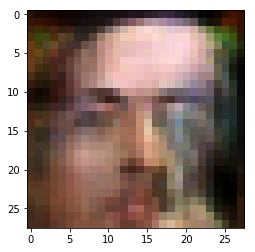

Epoch 1/1... Discriminator Loss: 1.5825... Generator Loss: 0.7981


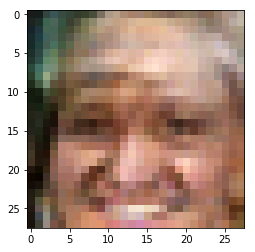

Epoch 1/1... Discriminator Loss: 1.6930... Generator Loss: 0.4020


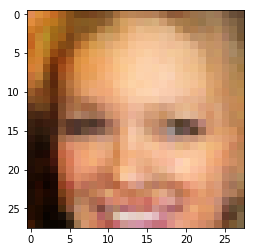

Epoch 1/1... Discriminator Loss: 1.6837... Generator Loss: 0.3716


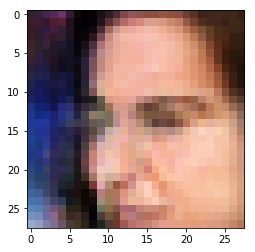

Epoch 1/1... Discriminator Loss: 1.9848... Generator Loss: 0.2598


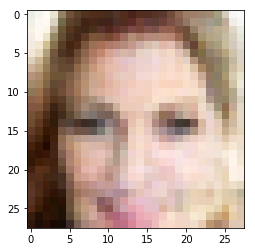

Epoch 1/1... Discriminator Loss: 1.6157... Generator Loss: 0.3156


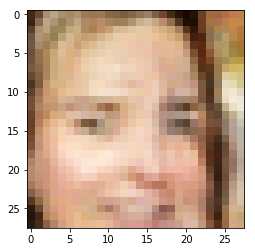

Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.5321


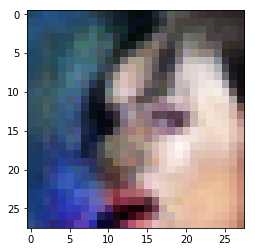

Epoch 1/1... Discriminator Loss: 1.7857... Generator Loss: 0.3469


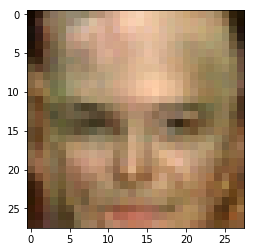

Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6121


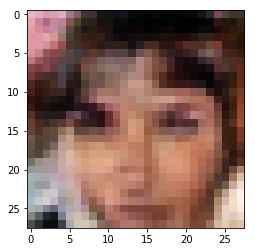

Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.4361


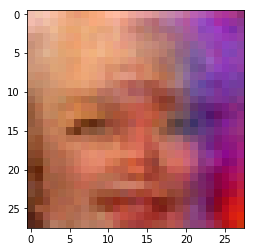

Epoch 1/1... Discriminator Loss: 1.5922... Generator Loss: 0.4127


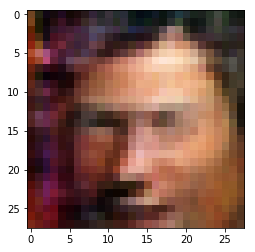

Epoch 1/1... Discriminator Loss: 2.0068... Generator Loss: 0.1715


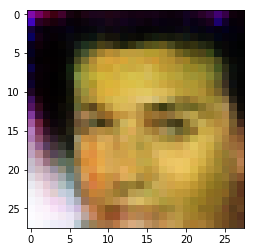

Epoch 1/1... Discriminator Loss: 1.6736... Generator Loss: 0.4918


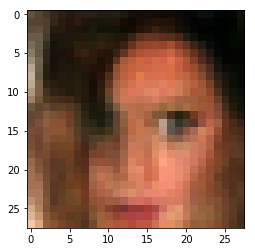

Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.6271


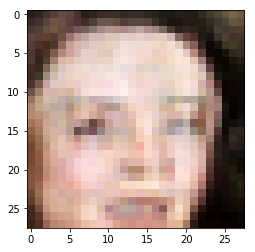

Epoch 1/1... Discriminator Loss: 2.1891... Generator Loss: 0.2217


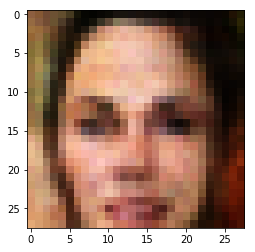

Epoch 1/1... Discriminator Loss: 1.7134... Generator Loss: 0.4236


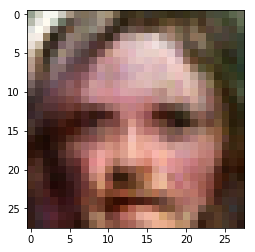

Epoch 1/1... Discriminator Loss: 2.0501... Generator Loss: 0.2483


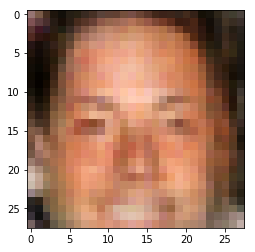

Epoch 1/1... Discriminator Loss: 1.8083... Generator Loss: 0.3063


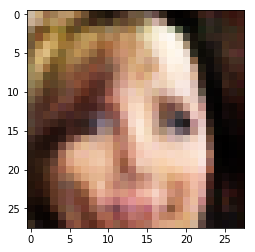

Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.5707


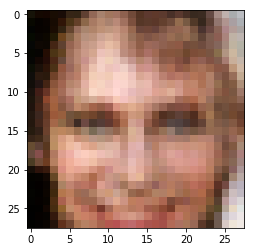

Epoch 1/1... Discriminator Loss: 1.7027... Generator Loss: 0.3448


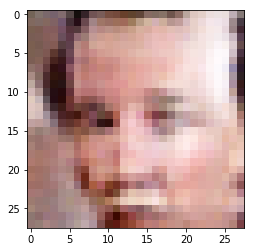

Epoch 1/1... Discriminator Loss: 1.6729... Generator Loss: 0.3385


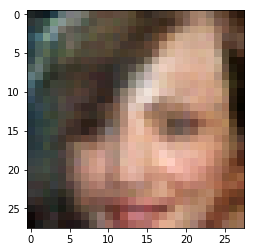

Epoch 1/1... Discriminator Loss: 1.6549... Generator Loss: 0.3820


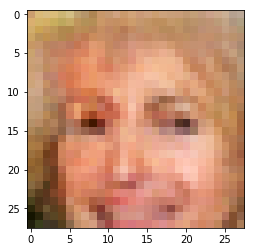

Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.5419


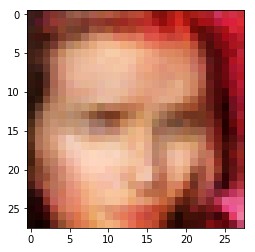

Epoch 1/1... Discriminator Loss: 1.7661... Generator Loss: 0.5966


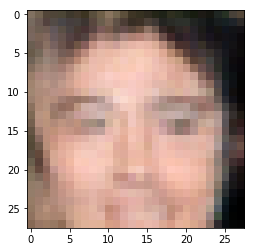

Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.5359


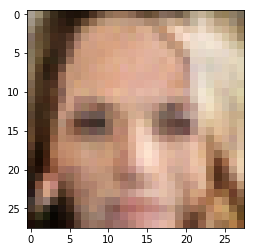

Epoch 1/1... Discriminator Loss: 1.7083... Generator Loss: 0.3280


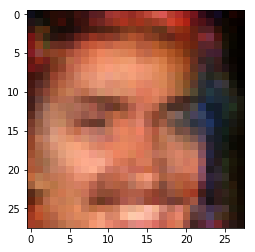

Epoch 1/1... Discriminator Loss: 1.6508... Generator Loss: 0.3863


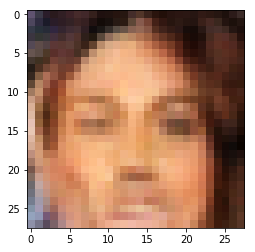

Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7695


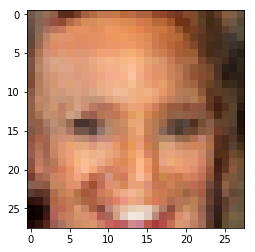

Epoch 1/1... Discriminator Loss: 1.6108... Generator Loss: 0.3485


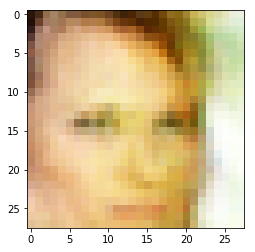

Epoch 1/1... Discriminator Loss: 1.6153... Generator Loss: 0.3688


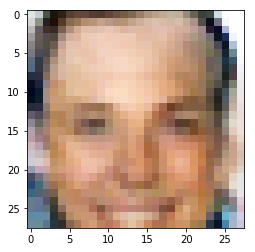

Epoch 1/1... Discriminator Loss: 1.8416... Generator Loss: 0.3288


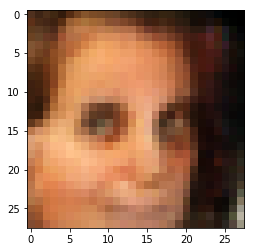

Epoch 1/1... Discriminator Loss: 1.7018... Generator Loss: 0.3359


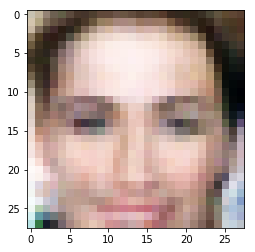

Epoch 1/1... Discriminator Loss: 1.9146... Generator Loss: 0.2980


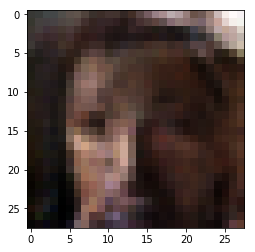

Epoch 1/1... Discriminator Loss: 1.7740... Generator Loss: 0.3491


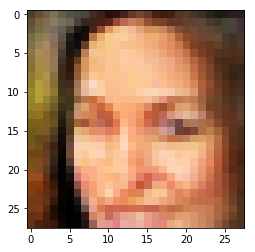

Epoch 1/1... Discriminator Loss: 1.7235... Generator Loss: 0.2894


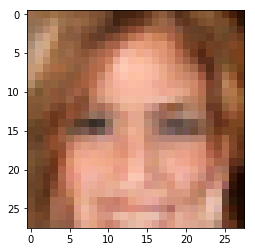

Epoch 1/1... Discriminator Loss: 1.7576... Generator Loss: 0.3026


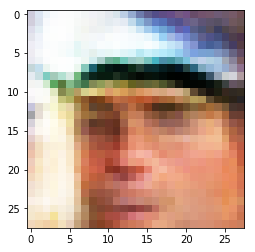

Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.5840


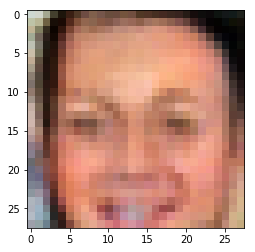

Epoch 1/1... Discriminator Loss: 1.7518... Generator Loss: 0.3986


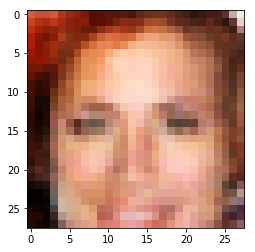

Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.4888


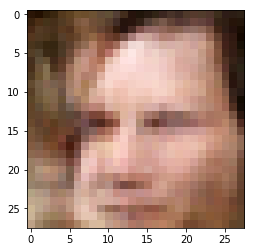

Epoch 1/1... Discriminator Loss: 1.8281... Generator Loss: 0.3599


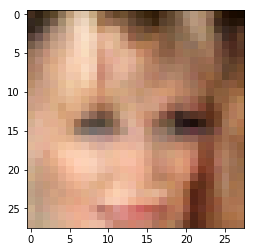

Epoch 1/1... Discriminator Loss: 1.7745... Generator Loss: 0.4097


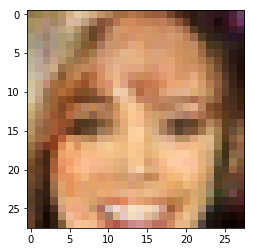

Epoch 1/1... Discriminator Loss: 1.8379... Generator Loss: 0.3512


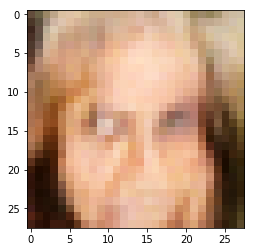

Epoch 1/1... Discriminator Loss: 1.6199... Generator Loss: 0.6525


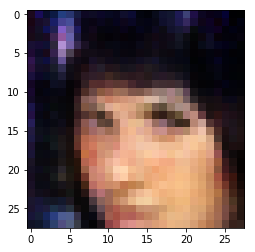

Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 0.4071


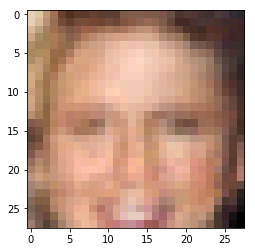

Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.5390


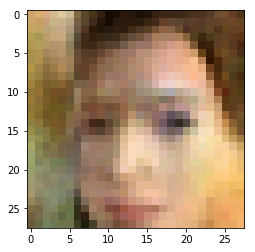

Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.3735


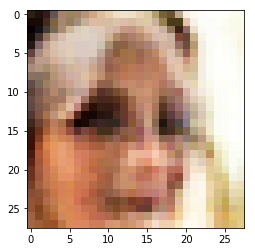

Epoch 1/1... Discriminator Loss: 1.6171... Generator Loss: 0.5233


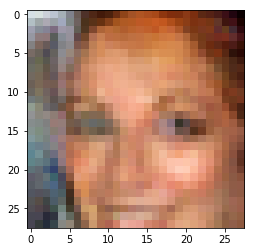

Epoch 1/1... Discriminator Loss: 1.5736... Generator Loss: 0.4604


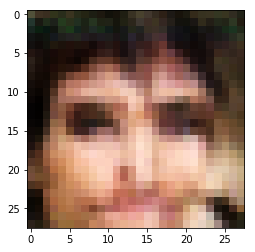

Epoch 1/1... Discriminator Loss: 1.6389... Generator Loss: 0.4447


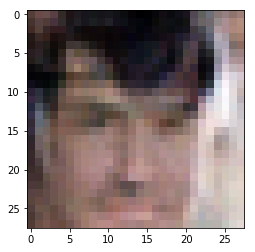

Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.6818


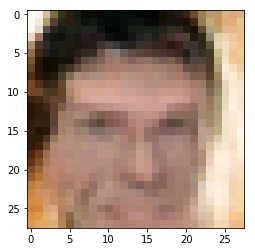

Epoch 1/1... Discriminator Loss: 1.5840... Generator Loss: 0.4439


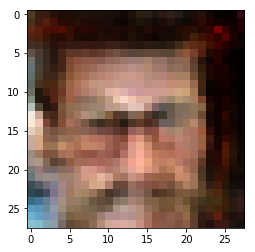

Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 0.4685


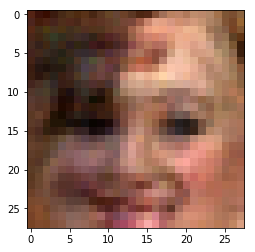

Epoch 1/1... Discriminator Loss: 1.8450... Generator Loss: 0.2485


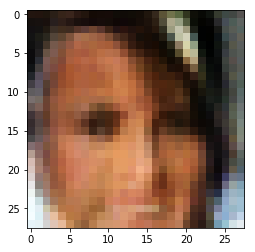

Epoch 1/1... Discriminator Loss: 1.7190... Generator Loss: 0.3784


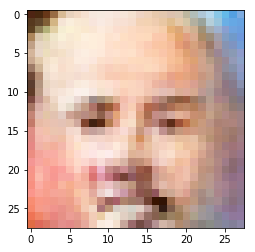

Epoch 1/1... Discriminator Loss: 1.6996... Generator Loss: 0.3539


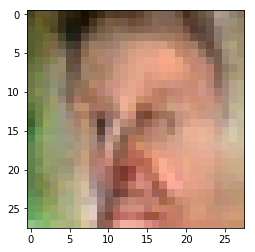

Epoch 1/1... Discriminator Loss: 1.5853... Generator Loss: 0.4015


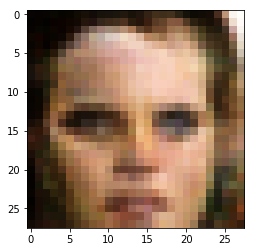

Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6652


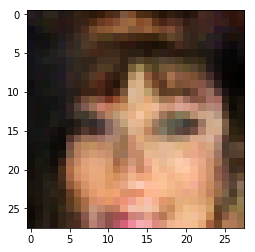

Epoch 1/1... Discriminator Loss: 1.6840... Generator Loss: 0.5379


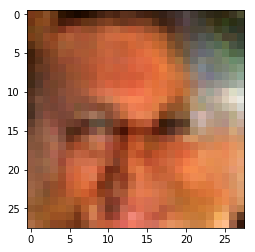

Epoch 1/1... Discriminator Loss: 1.5642... Generator Loss: 0.5268


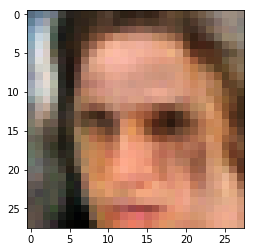

Epoch 1/1... Discriminator Loss: 1.7339... Generator Loss: 0.2958


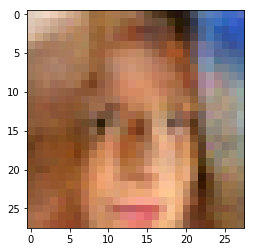

Epoch 1/1... Discriminator Loss: 1.6351... Generator Loss: 0.4466


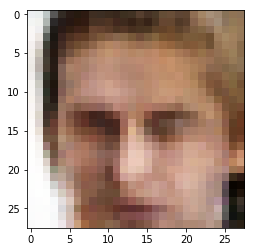

Epoch 1/1... Discriminator Loss: 1.7591... Generator Loss: 0.3385


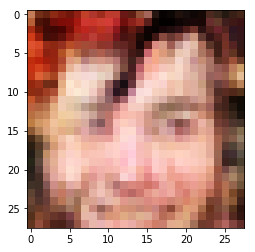

Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.5031


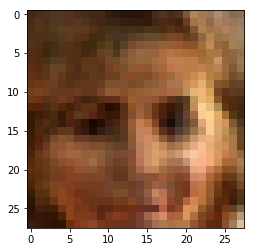

Epoch 1/1... Discriminator Loss: 1.6713... Generator Loss: 0.3428


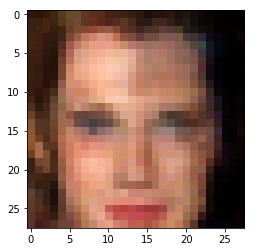

Epoch 1/1... Discriminator Loss: 1.7802... Generator Loss: 0.3262


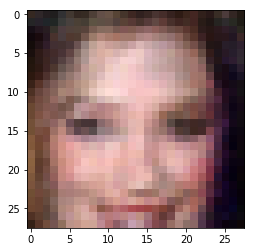

Epoch 1/1... Discriminator Loss: 1.6390... Generator Loss: 0.3717


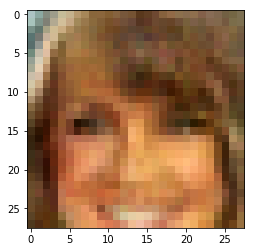

Epoch 1/1... Discriminator Loss: 1.8266... Generator Loss: 0.3185


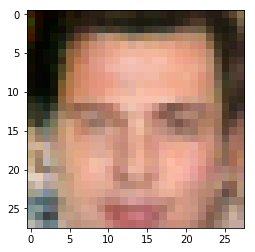

Epoch 1/1... Discriminator Loss: 1.9112... Generator Loss: 0.2528


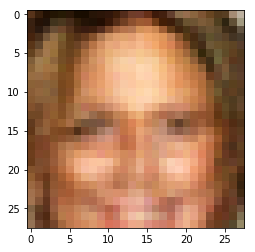

Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.4601


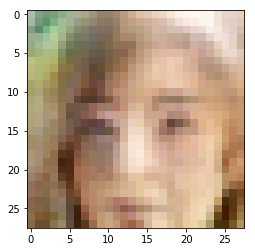

Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.4256


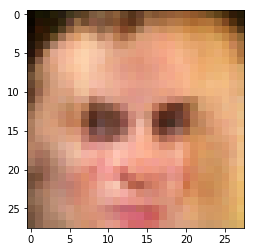

Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.5139


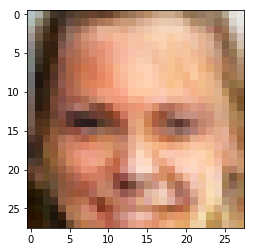

Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.3712


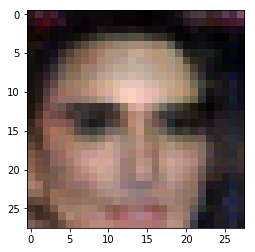

Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.4712


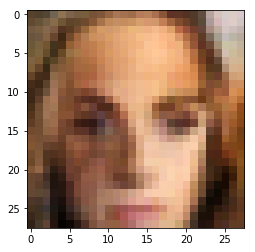

Epoch 1/1... Discriminator Loss: 1.7350... Generator Loss: 0.3880


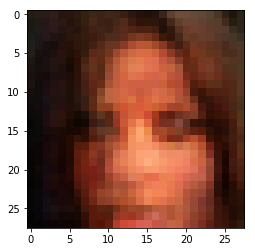

Epoch 1/1... Discriminator Loss: 1.7324... Generator Loss: 0.2881


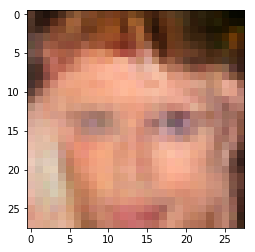

Epoch 1/1... Discriminator Loss: 1.9194... Generator Loss: 0.2812


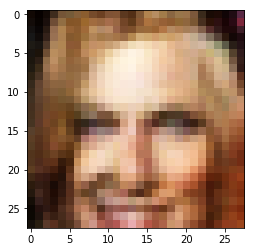

Epoch 1/1... Discriminator Loss: 1.6454... Generator Loss: 0.3534


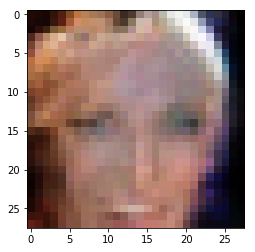

Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 0.3922


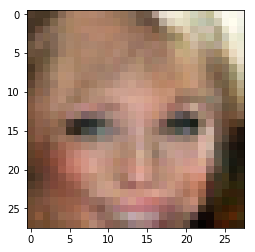

Epoch 1/1... Discriminator Loss: 1.8648... Generator Loss: 0.2505


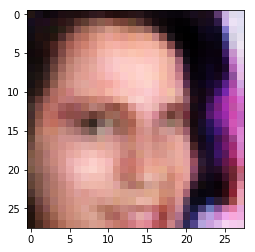

Epoch 1/1... Discriminator Loss: 1.6922... Generator Loss: 0.3062


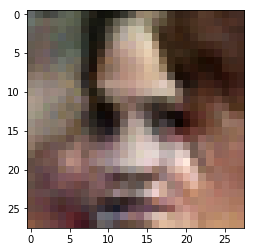

Epoch 1/1... Discriminator Loss: 1.8399... Generator Loss: 0.2844


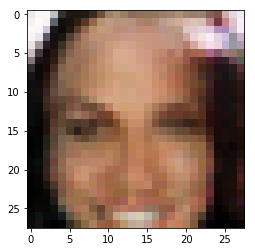

Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.5272


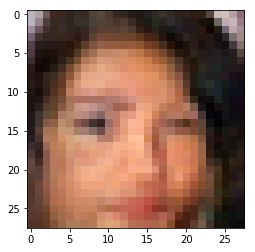

Epoch 1/1... Discriminator Loss: 2.0608... Generator Loss: 0.2903


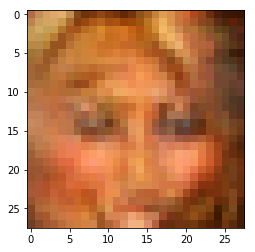

Epoch 1/1... Discriminator Loss: 1.6126... Generator Loss: 0.4067


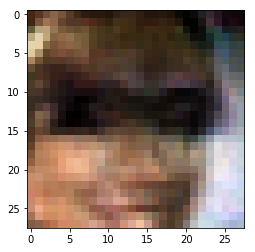

Epoch 1/1... Discriminator Loss: 1.7414... Generator Loss: 0.3168


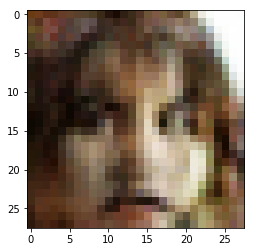

Epoch 1/1... Discriminator Loss: 1.9630... Generator Loss: 0.2109


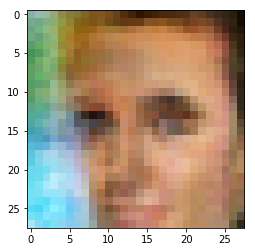

Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.4549


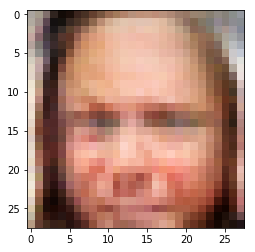

Epoch 1/1... Discriminator Loss: 1.6872... Generator Loss: 0.3670


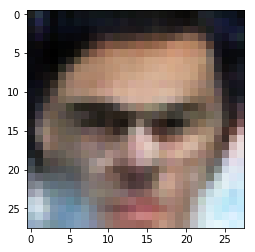

Epoch 1/1... Discriminator Loss: 2.1223... Generator Loss: 0.2150


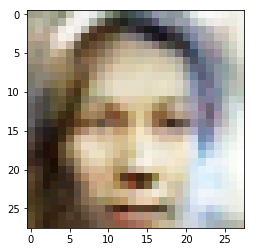

Epoch 1/1... Discriminator Loss: 1.7256... Generator Loss: 0.3193


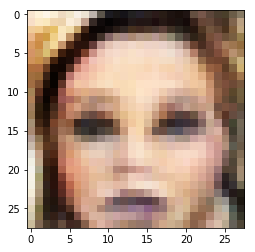

Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.7439


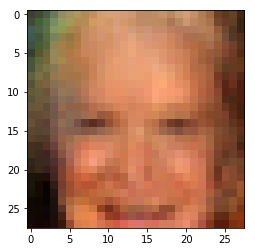

Epoch 1/1... Discriminator Loss: 1.7100... Generator Loss: 0.3763


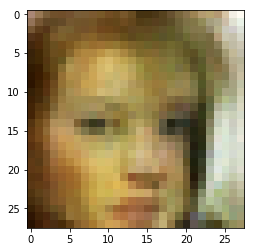

Epoch 1/1... Discriminator Loss: 1.5331... Generator Loss: 0.5165


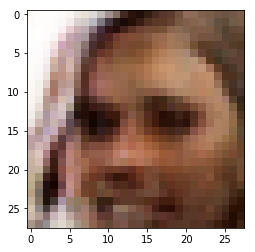

Epoch 1/1... Discriminator Loss: 1.6844... Generator Loss: 0.3598


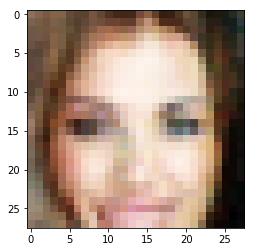

Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.5124


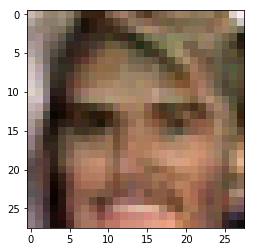

Epoch 1/1... Discriminator Loss: 1.9660... Generator Loss: 0.2052


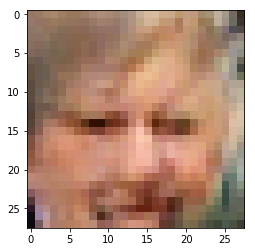

Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.5115


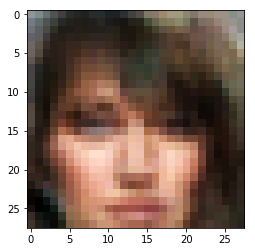

Epoch 1/1... Discriminator Loss: 1.7657... Generator Loss: 0.3316


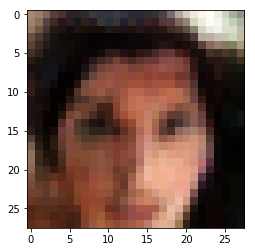

Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.6052


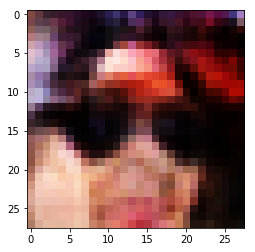

Epoch 1/1... Discriminator Loss: 1.5809... Generator Loss: 0.3313


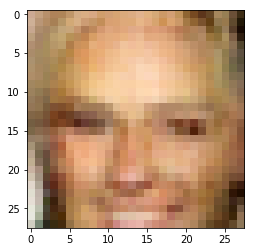

Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.5423


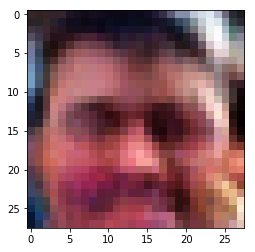

Epoch 1/1... Discriminator Loss: 1.7428... Generator Loss: 0.3188


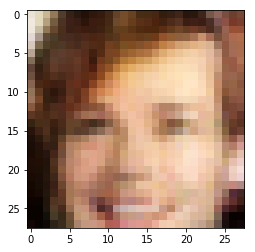

Epoch 1/1... Discriminator Loss: 1.6918... Generator Loss: 0.2890


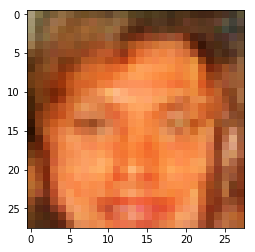

Epoch 1/1... Discriminator Loss: 1.8261... Generator Loss: 0.2488


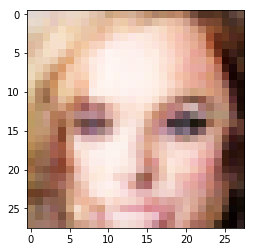

Epoch 1/1... Discriminator Loss: 1.8902... Generator Loss: 0.2502


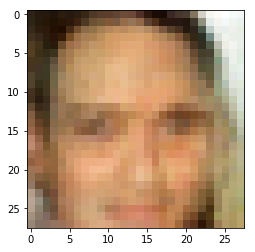

Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.5545


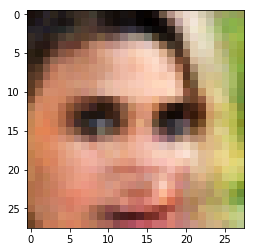

Epoch 1/1... Discriminator Loss: 1.8318... Generator Loss: 0.2930


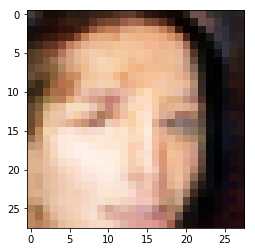

Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.4210


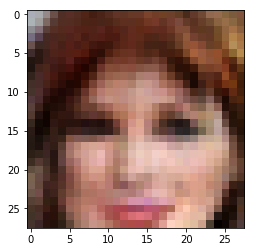

Epoch 1/1... Discriminator Loss: 1.8970... Generator Loss: 0.2495


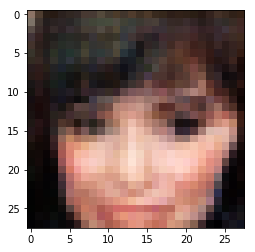

Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.4567


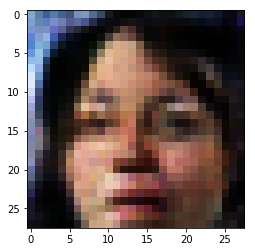

Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.5669


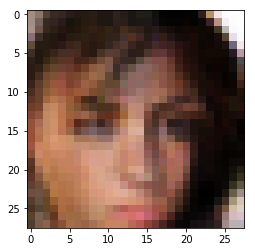

Epoch 1/1... Discriminator Loss: 1.6336... Generator Loss: 0.3920


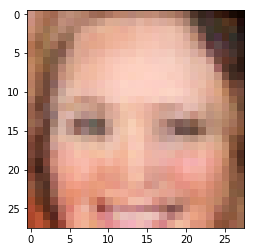

Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 0.4530


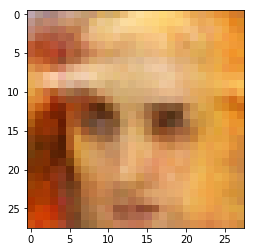

Epoch 1/1... Discriminator Loss: 1.8872... Generator Loss: 0.2349


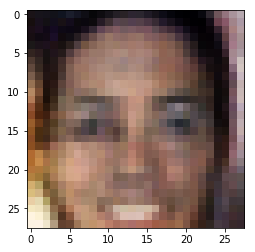

Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.6744


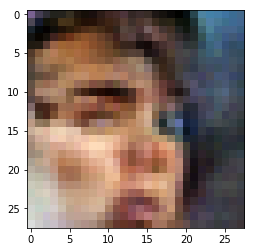

Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.5965


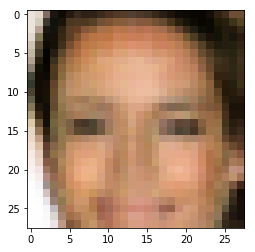

Epoch 1/1... Discriminator Loss: 1.6235... Generator Loss: 0.4454


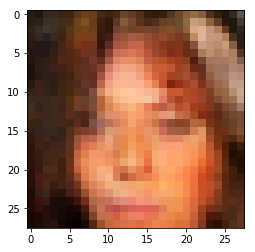

Epoch 1/1... Discriminator Loss: 1.7146... Generator Loss: 0.3465


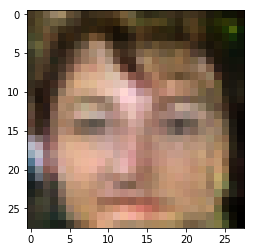

Epoch 1/1... Discriminator Loss: 1.6178... Generator Loss: 0.3518


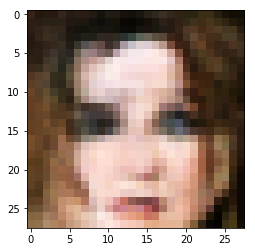

Epoch 1/1... Discriminator Loss: 1.6116... Generator Loss: 0.3869


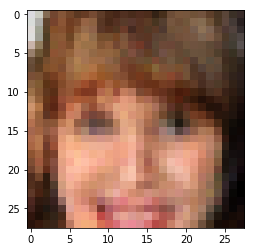

Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.6748


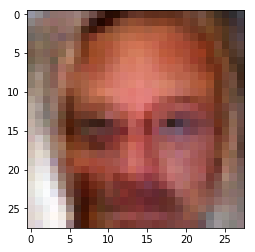

Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.4541


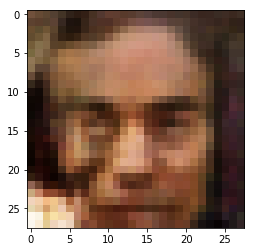

Epoch 1/1... Discriminator Loss: 1.8155... Generator Loss: 0.3136


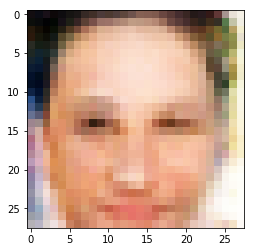

Epoch 1/1... Discriminator Loss: 1.7079... Generator Loss: 0.4422


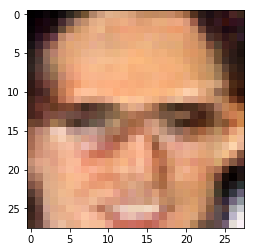

Epoch 1/1... Discriminator Loss: 1.7580... Generator Loss: 0.3481


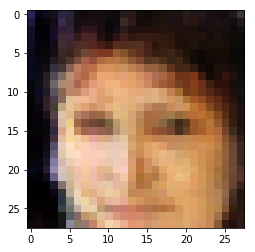

Epoch 1/1... Discriminator Loss: 1.6331... Generator Loss: 0.4595


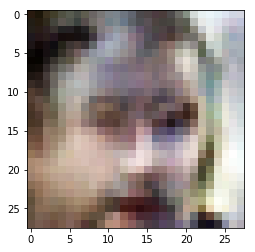

Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.4557


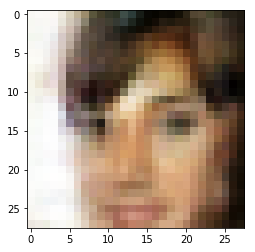

Epoch 1/1... Discriminator Loss: 1.7789... Generator Loss: 0.3335


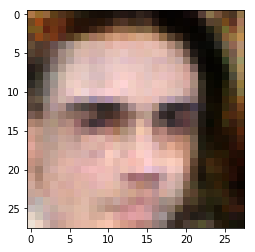

Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.4422


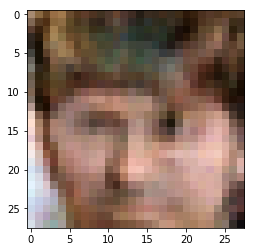

Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.5232


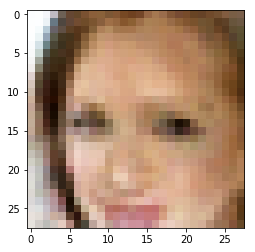

Epoch 1/1... Discriminator Loss: 1.6263... Generator Loss: 0.4204


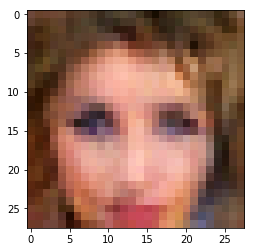

Epoch 1/1... Discriminator Loss: 1.7437... Generator Loss: 0.3541


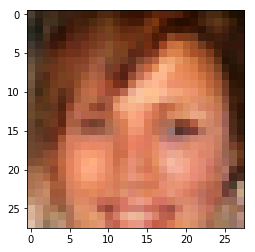

Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.5315


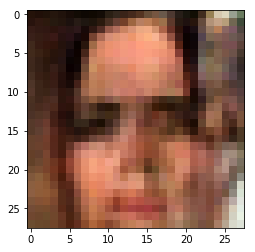

Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.4381


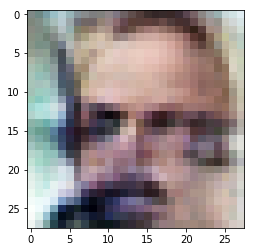

Epoch 1/1... Discriminator Loss: 1.7534... Generator Loss: 0.3414


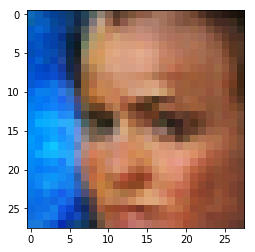

Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.5214


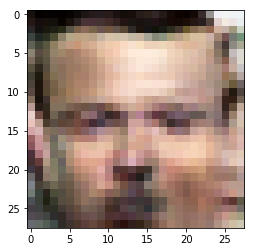

In [14]:
batch_size = 32
z_dim = 512
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.